In [ ]:
!pip install optuna
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

import scipy.stats as stats
import statsmodels.api as sm
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import optuna

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.interpolate import make_interp_spline

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("talhabarkaatahmad/laptop-prices-dataset-october-2023")

print("Path to dataset files:", path)

100%|██████████| 63.1k/63.1k [00:00<00:00, 49.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/talhabarkaatahmad/laptop-prices-dataset-october-2023/versions/1


In [ ]:
df = pd.read_csv(f'{path}/amazon_laptop_prices_v01.csv')

In [ ]:
df.head()

brand                  model   screen_size       color harddisk  \
0   ROKC                    NaN     14 Inches        Blue  1000 GB   
1     HP                    NaN   15.6 Inches      Silver  1000 GB   
2    MSI  Vector GP66 12UGS-267  15.66 Inches  Core Black      NaN   
3  Apple            MacBook Air   13.3 Inches      Silver   256 GB   
4  Apple            MacBook Air   15.3 Inches    Midnight   256 GB   

             cpu    ram               OS  special_features    graphics  \
0  Intel Core i7   8 GB       Windows 11               NaN  Integrated   
1  Intel Core i5  64 GB   Windows 11 Pro  Backlit Keyboard  Integrated   
2  Intel Core i9  32 GB  Windows 11 Home               NaN   Dedicated   
3        Unknown   8 GB           Mac OS  Backlit Keyboard  Integrated   
4        Unknown   8 GB           Mac OS               NaN  Integrated   

  graphics_coprocessor cpu_speed  rating       price  
0                Intel   1.2 GHz     NaN    $589.99   
1                Intel       NaN     4.5    $999.99   
2                  NaN   1.8 GHz     5.0  $1,599.00   
3                  NaN       NaN     4.8    $689.99   
4                  NaN       NaN     4.8  $1,144.48

# Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446 entries, 0 to 4445
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   brand                 4446 non-null   object 
 1   model                 3282 non-null   object 
 2   screen_size           4417 non-null   object 
 3   color                 3867 non-null   object 
 4   harddisk              3870 non-null   object 
 5   cpu                   4346 non-null   object 
 6   ram                   4385 non-null   object 
 7   OS                    4420 non-null   object 
 8   special_features      2054 non-null   object 
 9   graphics              4381 non-null   object 
 10  graphics_coprocessor  2574 non-null   object 
 11  cpu_speed             1520 non-null   object 
 12  rating                2174 non-null   float64
 13  price                 4441 non-null   object 
dtypes: float64(1), object(13)
memory usage: 486.4+ KB


## Codebook

- **brand**: Thương hiệu của laptop  
- **model**: Mẫu mã của laptop  
- **screen size**: Kích thước màn hình của laptop (tính bằng inch)  
- **color**: Màu sắc của laptop  
- **hard disk**: Ổ cứng được lắp đặt (tính bằng GB hoặc TB)  
- **CPU**: Bộ vi xử lý được lắp đặt  
- **RAM**: RAM được lắp đặt trong laptop  
- **Operating system (OS)**: Hệ điều hành của laptop  
- **Special Features**: Các tính năng đặc biệt  
- **Graphics card**: Card đồ họa  
- **Graphics coprocessor**: Đồng xử lý đồ họa (card đồ họa)  
- **CPU rating**: Đánh giá CPU  
- **Rating**: Đánh giá trung bình của khách hàng (trên thang điểm 5) tính đến tháng 10/2023  
- **Price**: Giá của sản phẩm (tính bằng USD) tính đến tháng 10/2023

# EDA before preprocessing

In [ ]:
df['screen_size'].head()

0       14 Inches
1     15.6 Inches
2    15.66 Inches
3     13.3 Inches
4     15.3 Inches
Name: screen_size, dtype: object

In [ ]:
df['cpu_speed'].head()

0    1.2 GHz
1        NaN
2    1.8 GHz
3        NaN
4        NaN
Name: cpu_speed, dtype: object

In [ ]:
df['harddisk'].head()

0    1000 GB
1    1000 GB
2        NaN
3     256 GB
4     256 GB
Name: harddisk, dtype: object

In [ ]:
df['ram'].head()

0     8 GB
1    64 GB
2    32 GB
3     8 GB
4     8 GB
Name: ram, dtype: object

In [ ]:
df['price'].head()

0      $589.99 
1      $999.99 
2    $1,599.00 
3      $689.99 
4    $1,144.48 
Name: price, dtype: object

## Thống kê mô tả

### Biến phân loại

In [ ]:

def num_of_unique(df):
  for col in df.columns:
    print(f'{col} : có {df[col].nunique()} unique values')
num_of_unique(df)

brand : có 50 unique values
model : có 1083 unique values
screen_size : có 35 unique values
color : có 187 unique values
harddisk : có 41 unique values
cpu : có 141 unique values
ram : có 18 unique values
OS : có 49 unique values
special_features : có 188 unique values
graphics : có 109 unique values
graphics_coprocessor : có 209 unique values
cpu_speed : có 60 unique values
rating : có 32 unique values
price : có 1858 unique values


Nhận xét : Các biến phân loại có thể là

In [ ]:
categorical_columns = ["brand",  "model", "color","cpu","OS","special_features","graphics","graphics_coprocessor"]

def calculate_frequency(series):
    frequency = series.value_counts(normalize=True).reset_index()
    frequency.columns = ['Value', 'Frequency']
    return frequency

def statistical_category(df: pd.DataFrame):
    columns = list(df.columns)
    for i in range(len(columns)):
        freqs = calculate_frequency(df[columns[i]])
        print(f"Sự phân bổ giá trị phân loại trong thuộc tính {columns[i]}")
        print(freqs)
        print("-"*70)
df_cate = df[categorical_columns]
statistical_category(df_cate)

Sự phân bổ giá trị phân loại trong thuộc tính brand
                            Value  Frequency
0                            Dell   0.355601
1                              HP   0.180837
2                            ROKC   0.143275
3                             MSI   0.106388
4                          Lenovo   0.069276
5                            ASUS   0.035987
6                            DELL   0.033063
7                            acer   0.024291
8                              LG   0.008772
9                           Apple   0.006523
10                        SAMSUNG   0.005173
11                      Microsoft   0.003374
12                      Alienware   0.003149
13                      Panasonic   0.002699
14                           Acer   0.002474
15                       Gigabyte   0.002474
16                      Toughbook   0.002474
17                             hp   0.001350
18                          Razer   0.001350
19                         LENOVO   0.001350
20 

các giá trị cột model chứa nhiều thông tin hơn là tên của model sỡ hữu

Cột special_features có thể tận dụng khi train nhưng cấu trúc khá phức tạp

Có thể giảm unique values cột color về các màu chủ đạo của nó (dark gray -> gray)

### Biến kiểu số (chưa thực hiện được do chưa tiền xử lý)

## Kiểm định

#### Biến phân loại

In [ ]:
# Kiểm định Chi-Squared
def Chi2_categorical_features(df: pd.DataFrame, df_target):
    features = []
    p_values = []
    chi2_stats = []
    for col in df.columns:
        if col == 'price':
            continue
        contingency_table = pd.crosstab(df[col], df_target['price'])
        chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

        if p_value < 0.05:
            print(f"Có sự tác động của biến {col.strip()} lên biến mục tiêu Price!")
            features.append(col)
            p_values.append(p_value)
            chi2_stats.append(chi2_stat)
        else:
            print(f"Không có sự tác động của biến {col.strip()} lên biến mục tiêu Price!")
    return pd.DataFrame({
        'Categorical_Features': features,
        'Statistical': chi2_stats,
        'P-Value': p_values
    })


In [ ]:
Chi2_categorical_features(df_cate, df)

Có sự tác động của biến brand lên biến mục tiêu Price!
Có sự tác động của biến model lên biến mục tiêu Price!
Có sự tác động của biến color lên biến mục tiêu Price!
Có sự tác động của biến cpu lên biến mục tiêu Price!
Có sự tác động của biến OS lên biến mục tiêu Price!
Có sự tác động của biến special_features lên biến mục tiêu Price!
Có sự tác động của biến graphics lên biến mục tiêu Price!
Có sự tác động của biến graphics_coprocessor lên biến mục tiêu Price!


Categorical_Features   Statistical  P-Value
0                 brand  1.549519e+05      0.0
1                 model  2.412741e+06      0.0
2                 color  4.984654e+05      0.0
3                   cpu  4.175751e+05      0.0
4                    OS  1.704854e+05      0.0
5      special_features  2.829153e+05      0.0
6              graphics  3.816181e+05      0.0
7  graphics_coprocessor  4.115947e+05      0.0

#### Biến kiểu số (Chưa thực hiện được do chưa tiền xử lý

## Missing Value

In [ ]:
def missing_val_percent(X):
    """
    Hàm tính phần trăm giá trị bị thiếu (missing values) trong mỗi cột của DataFrame.

    Args:
        X (pd.DataFrame): DataFrame cần kiểm tra giá trị bị thiếu.

    Returns:
        None: In ra tên các cột có giá trị bị thiếu và phần trăm giá trị bị thiếu trong từng cột.
    """

    range = len(X)
    for col in X.columns:
        if X[col].isnull().sum() != 0:
            print(f'{col} : {(X[col].isnull().sum() / range) * 100}%')

missing_val_percent(df)

model : 26.180836707152494%
screen_size : 0.6522717049032839%
color : 13.022941970310391%
harddisk : 12.955465587044534%
cpu : 2.249212775528565%
ram : 1.3720197930724245%
OS : 0.5847953216374269%
special_features : 53.80116959064327%
graphics : 1.461988304093567%
graphics_coprocessor : 42.10526315789473%
cpu_speed : 65.8119658119658%
rating : 51.102114260009%
price : 0.11246063877642824%


Biến model sẽ được loại bỏ

graphics và graphics_coprocessor sẽ được process với nhau

cpu_speed sẽ được fill bằng DecisionTreeRegressor (biến kiểu số liên tục)

harddisk sẽ được fill bằng KNNClassifier (do đây là kiểu phân loại)

# Pre-Processing

## Data Clearning

### Screen_size (Loại bỏ "Inch")

In [ ]:
df.screen_size.value_counts()

screen_size
15.6 Inches     1995
14 Inches       1113
16 Inches        362
15.66 Inches     196
13.3 Inches      194
17.3 Inches      150
17 Inches         89
11.6 Inches       84
13.4 Inches       43
18 Inches         41
13 Inches         36
15 Inches         25
13.5 Inches       11
12.5 Inches       10
14.1 Inches        9
12 Inches          7
10.1 Inches        7
13.1 Inches        6
16.1 Inches        5
14.5 Inches        4
16.2 Inches        4
13.6 Inches        4
15.4 Inches        3
12.3 Inches        3
13.9 Inches        3
11 Inches          2
12.4 Inches        2
12.45 Inches       2
10.5 Inches        1
12.2 Inches        1
14.4 Inches        1
15.3 Inches        1
22 Inches          1
27 Inches          1
10 Inches          1
Name: count, dtype: int64

In [ ]:
df.screen_size.replace(" Inches","", inplace=True, regex=True)
df.screen_size

<ipython-input-6-0208b82ebe29>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.screen_size.replace(" Inches","", inplace=True, regex=True)


0          14
1        15.6
2       15.66
3        13.3
4        15.3
        ...  
4441     15.6
4442       14
4443     15.6
4444       14
4445       14
Name: screen_size, Length: 4446, dtype: object

### HardDisk + RAM (loại bỏ "MB", "GB", "TB")

In [ ]:
df.harddisk.value_counts()

harddisk
1000 GB    1334
512 GB      747
256 GB      476
1 TB        315
64 GB       194
1152 GB     177
2000 GB     165
2 TB        124
128 GB      114
32 GB        48
4000 GB      47
500 GB       34
4 TB         26
8000 GB      18
320 GB        8
16 GB         8
160 GB        4
6000 GB       3
480 GB        2
240 GB        2
8 GB          2
8 TB          2
1024 GB       2
2048 GB       1
1512 GB       1
640 GB        1
512 MB        1
1.5 TB        1
256           1
1.92 TB       1
32 MB         1
1256 GB       1
64 MB         1
250 GB        1
128 MB        1
512           1
300 GB        1
120 GB        1
65 GB         1
64            1
3 TB          1
Name: count, dtype: int64

In [ ]:
df.harddisk.replace(" GB","", inplace=True, regex=True)


df['harddisk'] = df['harddisk'].astype(str)
df['harddisk'] = df['harddisk'].apply(
    lambda x: str(float(x.split()[0]) * 1024) if 'TB' in x else x
)
df['harddisk'] = df['harddisk'].apply(
    lambda x: str(float(x.split()[0]) / 1024) if 'MB' in x else x
)

df.harddisk.value_counts()

<ipython-input-8-5d50dd4b599e>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.harddisk.replace(" GB","", inplace=True, regex=True)


harddisk
1000       1334
512         748
nan         576
256         477
1024.0      315
64          195
1152        177
2000        165
2048.0      124
128         114
32           48
4000         47
500          34
4096.0       26
8000         18
320           8
16            8
160           4
6000          3
8             2
8192.0        2
480           2
240           2
1024          2
0.125         1
1966.08       1
65            1
2048          1
640           1
0.5           1
1536.0        1
1512          1
250           1
1256          1
120           1
300           1
0.0625        1
0.03125       1
3072.0        1
Name: count, dtype: int64

In [ ]:
df.ram.value_counts()

ram
16 GB       1344
32 GB       1092
8 GB         791
64 GB        502
20 GB        331
4 GB         216
12 GB         40
24 GB         21
40 GB         13
48 GB         12
2 GB           9
1 GB           4
128 GB         3
6 GB           3
64 MB          1
5 GB           1
96 GB          1
31.99 GB       1
Name: count, dtype: int64

In [ ]:
df.ram.replace(" GB","", inplace=True, regex=True)
df['ram'] = df['ram'].astype(str)
df['ram'] = df['ram'].apply(
    lambda x: str(float(x.split()[0]) / 1024) if 'MB' in x else x
)

df.ram.replace("31.99","32", inplace=True, regex=True)
df.ram.replace("nan",np.nan, inplace=True, regex=True)

<ipython-input-10-4542c575e138>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.ram.replace(" GB","", inplace=True, regex=True)
<ipython-input-10-4542c575e138>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [ ]:
df.ram.value_counts()

ram
16        1344
32        1093
8          791
64         502
20         331
4          216
12          40
24          21
40          13
48          12
2            9
1            4
128          3
6            3
0.0625       1
5            1
96           1
Name: count, dtype: int64

### cpu_speed

In [ ]:
df.cpu_speed.value_counts()

cpu_speed
1.1 GHz         509
1.8 GHz         410
1.2 GHz         312
2.6 GHz          31
2.4 GHz          24
1.7 GHz          17
1 GHz            12
2.8 GHz          12
2.3 GHz          11
5 GHz            11
3.5 GHz          11
3 GHz            10
2 GHz             9
2.2 GHz           8
4.5 GHz           7
3.4 GHz           7
1.6 GHz           7
4.6 GHz           6
2.7 GHz           6
3.7 GHz           6
4.2 GHz           6
2.1 GHz           6
2.5 GHz           6
4.7 GHz           6
1.9 GHz           5
4.8 GHz           5
3.6 GHz           5
2.9 GHz           4
1.3 GHz           4
5.6 GHz           3
3.8 GHz           3
4.4 GHz           3
4 GHz             2
3.2 GHz           2
3.9 GHz           2
3.4               2
2.53 GHz          2
3.3 GHz           2
5.1 GHz           2
4.3 GHz           2
3.3               2
4.1 GHz           2
5.2 GHz           1
2 Hz              1
3.1 GHz           1
1.9               1
2.5, 3.1 GHz      1
3200 Hz           1
2.2, 3.9 GHz      1
2133 MHz          1
4.7               1
1.8               1
9120 GHz          1
2.4               1
2.66 GHz          1
2.6               1
1.4 GHz           1
1.5 GHz           1
3.49 GHz          1
0.9 GHz           1
Name: count, dtype: int64

In [ ]:
df.cpu_speed.replace(" GHz","", inplace=True, regex=True)
df.cpu_speed.replace("2133 MHz","2.1", inplace=True, regex=True)
df.cpu_speed.replace("3200 Hz","3.2", inplace=True, regex=True) # này chắc là MHz
df.cpu_speed.replace(" Hz","", inplace=True, regex=True) # đổi lại thành GhZ vì Hz thì sai vl
df.cpu_speed.value_counts()

<ipython-input-13-df9ae7adb3a2>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.cpu_speed.replace(" GHz","", inplace=True, regex=True)
<ipython-input-13-df9ae7adb3a2>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

cpu_speed
1.1         509
1.8         411
1.2         312
2.6          32
2.4          25
1.7          17
1            12
2.8          12
5            11
2.3          11
3.5          11
3            10
2            10
3.4           9
2.2           8
4.7           7
2.1           7
1.6           7
4.5           7
1.9           6
4.6           6
3.7           6
2.7           6
4.2           6
2.5           6
4.8           5
3.6           5
2.9           4
1.3           4
3.3           4
4.4           3
3.8           3
3.2           3
5.6           3
5.1           2
4             2
2.53          2
4.1           2
4.3           2
3.9           2
3.49          1
1.5           1
2.66          1
1.4           1
5.2           1
9120          1
2.2, 3.9      1
2.5, 3.1      1
3.1           1
0.9           1
Name: count, dtype: int64

In [ ]:
df.cpu_speed.replace("9120","9.1", inplace=True, regex=True) # có vẻ nhầm là MHz
df.cpu_speed.replace("2.2, 3.9","3.1", inplace=True, regex=True) # lấy trung bình
df.cpu_speed.replace("2.5, 3.1","2.8", inplace=True, regex=True) # lấy trung bình
df.cpu_speed.value_counts()

<ipython-input-14-15b72f43fd1b>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.cpu_speed.replace("9120","9.1", inplace=True, regex=True) # có vẻ nhầm là MHz
<ipython-input-14-15b72f43fd1b>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

cpu_speed
1.1     509
1.8     411
1.2     312
2.6      32
2.4      25
1.7      17
2.8      13
1        12
3.5      11
2.3      11
5        11
2        10
3        10
3.4       9
2.2       8
4.7       7
1.6       7
2.1       7
4.5       7
1.9       6
4.2       6
4.6       6
2.7       6
2.5       6
3.7       6
3.6       5
4.8       5
1.3       4
3.3       4
2.9       4
5.6       3
3.2       3
4.4       3
3.8       3
2.53      2
4         2
4.1       2
4.3       2
3.1       2
5.1       2
3.9       2
9.1       1
2.66      1
1.4       1
1.5       1
3.49      1
5.2       1
0.9       1
Name: count, dtype: int64

### price

In [ ]:
df.price.value_counts()

price
$389.99       315
$589.99       310
$999.99       252
$1,599.00     210
$1,699.00     204
             ... 
$2,629.98       1
$1,659.67       1
$245.01         1
$2,951.99       1
$938.99         1
Name: count, Length: 1858, dtype: int64

In [ ]:
df.price = df.price.str.replace('$', '')
df.price = df.price.str.replace(',', '')
df.price.value_counts()

price
389.99      315
589.99      310
999.99      252
1599.00     210
1699.00     204
           ... 
2629.98       1
1659.67       1
245.01        1
2951.99       1
938.99        1
Name: count, Length: 1858, dtype: int64

### Object Features

In [ ]:
def get_nunique(df, column_name):
    """
    Tìm số lượng giá trị duy nhất trong một cột cụ thể của DataFrame.

    Args:
        df (pd.DataFrame): DataFrame cần kiểm tra.
        column_name (str): Tên của cột cần tính nunique.

    Returns:
        int: Số lượng giá trị duy nhất trong cột.
    """
    if column_name in df.columns:
        return df[column_name].nunique()
    else:
        raise ValueError(f"Cột '{column_name}' không tồn tại trong DataFrame.")

In [ ]:
objects = ['brand','model','special_features','graphics','graphics_coprocessor','OS','color']
for i in objects:
    print(f'{i} : {get_nunique(df, i)}')

brand : 50
model : 1083
special_features : 188
graphics : 109
graphics_coprocessor : 209
OS : 49
color : 187


In [ ]:
brands = df.brand.unique()
brands.sort()
brands

array(['ASUS', 'AWOW', 'Acer', 'Alienware', 'Apple', 'Asus',
       'Best Notebooks', 'CTL', 'Carlisle FoodService Products',
       'Computer Upgrade King', 'Corsair', 'DELL', 'Dell', 'Elo',
       'Gateway', 'Gigabyte', 'GizPro', 'Goldengulf', 'HP', 'IVIEW',
       'JTD', 'LENOVO', 'LG', 'LPT', 'Latitude', 'Lenovo', 'Luqeeg',
       'MAINGEAR', 'MICROTELLA', 'MSI', 'Microsoft', 'Mytrix', 'ONN',
       'Panasonic', 'Quality Refurbished Computers', 'ROKC', 'Razer',
       'SAMSUNG', 'SHOXLAB', 'TOPOSH', 'Tocosy', 'Toughbook', 'VAIO',
       'XAMMUE', 'XPG', 'acer', 'asus', 'dell', 'hp', 'lenovo'],
      dtype=object)

In [ ]:
def process_string_columns(df, columns):
    """
    Xử lý các cột chuỗi trong DataFrame:
    - Chuyển thành chữ thường.
    - Loại bỏ khoảng trắng thừa ở đầu và cuối.

    Args:
        df (pd.DataFrame): DataFrame cần xử lý.
        columns (list): Danh sách các cột cần xử lý.

    Returns:
        pd.DataFrame: DataFrame sau khi xử lý.
    """
    for column in columns:
        if column in df.columns:
            df[column] = df[column].str.lower().str.strip()
        else:
            print(f"Cột '{column}' không tồn tại trong DataFrame.")
    return df

In [ ]:
df = process_string_columns(df, objects)

In [ ]:
for i in objects:
    print(f'{i} : {get_nunique(df, i)}')

brand : 42
model : 1058
special_features : 184
graphics : 109
graphics_coprocessor : 205
OS : 48
color : 175


In [ ]:
brand : 42
model : 1083
color : 187
cpu : 141
OS : 48
special_features : 184
graphics : 109
graphics_coprocessor : 205

### color

In [ ]:
## đưa về màu chủ đạo
main_colors = ['black', 'blue', 'red', 'white', 'silver', 'gray', 'gold', 'green', 'pink', 'purple', 'yellow']

# Hàm tìm màu chủ đạo trong chuỗi
def extract_main_color(color_string, return_type):
    if pd.isna(color_string):  # Nếu giá trị là NaN, trả về NaN
        return None
    for color in main_colors:
        if color in color_string.lower():  # Kiểm tra màu có trong chuỗi
            return color
    return color_string if return_type == 'remain' else "Other" # Nếu không khớp màu nào, gán là 'unknown'


df['color'] = df['color'].apply(lambda x: extract_main_color(x, return_type='other'))



In [ ]:
df.color.value_counts()

color
black     1683
silver     937
blue       551
gray       297
Other      216
gold       149
white       15
green       12
red          6
pink         1
Name: count, dtype: int64

### OS

In [ ]:
standard_os = ["windows 11", "chrome os", "mac os", "linux", "windows 7", "windows 10", "windows 8"]
def extract_main_OS(color_string, return_type):
    if pd.isna(color_string):  # Nếu giá trị là NaN, trả về NaN
        return None
    for color in standard_os:
        if color in color_string.lower():  # Kiểm tra màu có trong chuỗi
            return color
    return color_string if return_type == 'remain' else "Other"  # Nếu không khớp màu nào, gán là 'unknown'

df['OS'] = df['OS'].apply(lambda x: extract_main_OS(x, return_type='remain'))

abbreations = {
    "win 10" : "windows 10 ",
    "win 11" : "windows 11 ",
    "win 7" : "windows 7 ",
    "macos" : "mac os "
}

for i in abbreations.keys():
  df.OS.replace(i, abbreations[i], inplace=True, regex=True)

df['OS'] = df['OS'].apply(lambda x: extract_main_OS(x, return_type='other'))




<ipython-input-25-80ad1a94ab4c>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.OS.replace(i, abbreations[i], inplace=True, regex=True)


In [ ]:
df.OS.value_counts()

OS
windows 11    3117
windows 10    1092
chrome os      125
windows 7       31
mac os          30
Other           13
windows 8       11
linux            1
Name: count, dtype: int64

### cpu

Cách 1 (cũ)

In [ ]:
# standard_cpu = ["pentium", "celeron", "core i5", "core i7", "core i9", "ryzen 3", "ryzen 5", "ryzen 7","ryzen 9"]
# def extract_main_cpu(color_string, return_type):
#     if pd.isna(color_string):  # Nếu giá trị là NaN, trả về NaN
#         return None
#     for color in standard_cpu:
#         if color in color_string.lower():  # Kiểm tra màu có trong chuỗi
#             return color
#     return color_string if return_type == 'remain' else "Other"  # Nếu không khớp màu nào, gán là 'unknown'
# df['cpu'] = df['cpu'].apply(lambda x: extract_main_cpu(x, return_type='remain'))
# abbreations = {
#     "Corei7" : "core i7"
# }

# for i in abbreations.keys():
#   df.cpu.replace(i, abbreations[i], inplace=True, regex=True)

# df['cpu'] = df['cpu'].apply(lambda x: extract_main_cpu(x, return_type='other'))

Cách 2 (mới)

In [ ]:
standard_cpu = ["pentium", "celeron"]

def extract_main_cpu(color_string, return_type):
    if pd.isna(color_string):  # Nếu giá trị là NaN, trả về NaN
        return None
    for color in standard_cpu:
        if color in color_string.lower():  # Kiểm tra màu có trong chuỗi
            return color
    return color_string if return_type == 'remain' else "Other"  # Nếu không khớp màu nào, gán là 'unknown'

df['cpu'] = df['cpu'].apply(lambda x: extract_main_cpu(x, return_type='remain'))

abbreations = {
    "Intel Core i5" : "Core i5",
    "Intel Core i7" : "Core i7",
    "Intel Core i9" : "Core i9",
    "Intel Core i3" : "Core i3",
    "Core i3 Family" : "Core i3",
    "Core i7 Family" : "Core i7",
    "Core i5 Family" : "Core i5",
}

for i in abbreations.keys():
  df.cpu.replace(i, abbreations[i], inplace=True, regex=True)

df.cpu.value_counts()

<ipython-input-26-710133148e0b>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.cpu.replace(i, abbreations[i], inplace=True, regex=True)


cpu
Core i7                        1395
Core i5                        1232
Core i9                         568
pentium                         368
celeron                         264
                               ... 
A-Series Dual-Core A4-3300M       1
AMD Ryzen 3 2300X                 1
Core i3 8130U                     1
68000                             1
core_m                            1
Name: count, Length: 121, dtype: int64

In [ ]:
def find_gen(value):
    """
    Hàm này tìm gen (đời thứ ith của tên)

    Args:
        value (str): Chuỗi cần xử lý.

    Returns:
        đời thứ : i (số nguyên)
    """
    try:
        # Lấy giá trị tại vị trí -6 và -5
        substring = value[-5:]
        numeric_chars = [char for char in substring if char.isnumeric()]
        if len(numeric_chars) == 3:
          return "1"
        # Kiểm tra nếu có bất kỳ chữ cái nào
        if any(char.isalpha() for char in substring):
            alphabet_chars = [char for char in substring if char.isalpha()]
            # Tính độ dài của danh sách các chữ cái
            alphabet_length = len(alphabet_chars)
            a = value[-5-alphabet_length]
            b = value[-4-alphabet_length]
        else:
            a = value[-5]
            b = value[-4]

        # Kiểm tra nếu -6 không phải số
        if not a.isnumeric():
            return b.replace("-", "")  # Remove "-" from b
        else:
            return (a + b).replace("-", "")  # Concatenate and remove "-"
    except IndexError:
        # Trường hợp chuỗi không đủ dài
        return "Invalid input"

import re

def extract_series(value):
    """
    Tìm dòng CPU ('Core iX' hoặc 'Ryzen X') từ chuỗi CPU và trả về số series (ví dụ: i7 hoặc Ryzen 9).

    Args:
        value (str): Chuỗi chứa thông tin CPU.

    Returns:
        str: Số dòng CPU (ví dụ: 7 hoặc 9).
    """
    value = value.strip().lower()

    # Tìm số series cho "core iX" hoặc "ryzen X"
    core_match = re.search(r'core i(\d)', value)
    if core_match is None:
      core_match = re.search(r'corei(\d)', value)
    ryzen_match = re.search(r'ryzen (\d)', value)

    if core_match:
        return f"Core i{core_match.group(1)}"
    elif ryzen_match:
        return f"Ryzen {ryzen_match.group(1)}"
    else:
        return "Unknown series"

not_touch_dic = {
    "pentium" : 1,
    "celeron" : 1,
    "Core i5" : 1,
    "Core i7" : 1,
    "Core i9" : 1
}

def simplify_cpu_column(value):
    """
    Giảm thiểu giá trị CPU trong cột bằng cách chuẩn hóa hoặc gắn nhãn 'other'.

    Args:
        value (str): Giá trị từ cột 'cpu'.

    Returns:
        str: Giá trị đã được chuẩn hóa hoặc 'other'.
    """
    if not isinstance(value, str):
        return "other"  # Gắn 'other' cho các giá trị không phải chuỗi (e.g., NaN)
    if not not_touch_dic.get(value):
      value = value.strip()  # Loại bỏ khoảng trắng thừa
      if 'core' in value.lower() or 'ryzen' in value.lower():  # Lọc CPU chứa 'core' hoặc 'ryzen'
          series = extract_series(value)  # Lấy series (Core i5, Ryzen 9, ...)
          gen = find_gen(value)  # Tìm thế hệ (gen)
          # Trả về giá trị chỉ nếu series và gen hợp lệ
          if series != "Unknown series" and gen != "Invalid input" and gen.isnumeric():
              return f"{series} gen {gen}"
      return "other"  # Gắn 'other' nếu không hợp lệ
    else:
      return value

In [ ]:


# Áp dụng hàm vào cột 'cpu' trong DataFrame
df['cpu'].astype(str)
if 'cpu' in df.columns:
    df['cpu'] = df['cpu'].apply(simplify_cpu_column)



In [ ]:
df.cpu.value_counts()

cpu
Core i7           1395
Core i5           1232
Core i9            568
other              460
pentium            368
celeron            264
Core i5 gen 11      22
Core i7 gen 10      20
Core i7 gen 11      12
Core i5 gen 10       9
Core i7 gen 8        8
Core i7 gen 1        7
Core i5 gen 4        7
Ryzen 3 gen 3        7
Core i3 gen 10       7
Ryzen 7 gen 5        7
Core i7 gen 12       4
Core i5 gen 5        4
Core i3 gen 11       4
Ryzen 5 gen 5        4
Ryzen 7 gen 4        3
Core i5 gen 6        3
Core i5 gen 8        3
Ryzen 5 gen 4        3
Core i5 gen 3        3
Core i5 gen 2        2
Core i7 gen 7        2
Core i3 gen 1        2
Ryzen 5 gen 3        2
Core i5 gen 7        1
Core i9 gen 7        1
Ryzen 3 gen 4        1
Ryzen 3 gen 2        1
Ryzen 5 gen 2        1
Ryzen 9 gen 7        1
Core i3 gen 8        1
Core i5 gen 1        1
Core i7 gen 4        1
Core i7 gen 13       1
Core i7 gen 6        1
Ryzen 3 gen 1        1
Ryzen 7 gen 2        1
Ryzen 9 gen 5        1
Name: count, dtype: int64

In [ ]:
len(df.cpu.value_counts())

43

### graphics và graphics_coprocessor

Vì hai cột `graphics` và `graphics_coprocessor` bổ trợ cho nhau, nên thông tin từ hai cột này sẽ được chiết xuất thành một cột mới tên là `VGA`.

In [ ]:
def format_vga_name(vga_name, cpu_name):
    """
    Định dạng và chuẩn hóa tên GPU (VGA) dựa trên thông tin đầu vào.

    Hàm này thực hiện các bước sau:
    1. Kiểm tra tính hợp lệ của tên GPU (`vga_name`). Nếu không hợp lệ (NaN hoặc rỗng), trả về "Unknown".
    2. Chuẩn hóa tên GPU: loại bỏ khoảng trắng thừa và chuyển sang chữ thường.
    3. Nhận diện thương hiệu và loại GPU:
        - NVIDIA: Nhận diện dựa trên từ khóa như "nvidia", "geforce", "rtx", "gtx" và trích xuất model (vd: RTX 3080).
        - AMD: Nhận diện dựa trên từ khóa như "amd", "radeon", "vega" và trích xuất model (vd: Radeon RX 6700).
        - Intel: Nhận diện dựa trên từ khóa như "intel", "iris", "uhd", "xe".
    4. Xử lý GPU onboard hoặc đồ họa chia sẻ: Dựa vào tên CPU (`cpu_name`) để xác định tên GPU onboard.
    5. Nếu không thuộc các loại trên, loại bỏ khoảng trắng và trả về tên GPU.

    Args:
        vga_name (str): Tên GPU (VGA) từ dữ liệu đầu vào.
        cpu_name (str): Tên CPU, sử dụng để xác định GPU onboard nếu cần.

    Returns:
        str: Tên GPU đã được chuẩn hóa hoặc giá trị mặc định ("Unknown").
    """

    if pd.isna(vga_name) or not vga_name.strip():
        return "Unknown"

    vga_name = vga_name.strip().lower()

    if "nvidia" in vga_name or "geforce" in vga_name or "rtx" in vga_name or "gtx" in vga_name:
        match = re.search(r'(rtx|gtx|quadro|t\d+|a\d+|mx)\s*(\d+.*)', vga_name)
        if match:
            return f"nvidia{match.group(1)}{match.group(2).replace(' ', '')}"
        else:
            return "nvidia"

    elif "amd" in vga_name or "radeon" in vga_name:
        match = re.search(r'(radeon|vega|prowx)\s*(\d+.*)', vga_name)
        if match:
            return f"amd{match.group(1)}{match.group(2).replace(' ', '')}"
        else:
            return "amdradeon"

    elif "intel" in vga_name or "iris" in vga_name or "uhd" in vga_name or "xe" in vga_name:
        return "intel"

    if "graphics" in vga_name or vga_name in ["integrated", "shared"]:
        return find_onboard_gpu(str(cpu_name))

    return vga_name.replace(" ", "")




def find_onboard_gpu(cpu_name):
    if "intel" in cpu_name.lower() or "pentinum" in cpu_name.lower() or "celeron" in cpu_name.lower() or "core" in cpu_name.lower():
        return "intel"
    else:
        return "amd"



def find_graphic(string_1, string_2, cpu_name):
    if pd.isna(string_1) and pd.isna(string_2):
        return "Unknown"
    elif pd.isna(string_2):
        if string_1.lower() in ["integrated", "dedicated", "shared"]:
            return find_onboard_gpu(str(cpu_name))
        else:
            return format_vga_name(string_1, cpu_name)
    else :
        return format_vga_name(string_2, cpu_name)
    return graphic



for i in range(len(df)):
    df.loc[i,'VGA'] = find_graphic(df.graphics[i], df.graphics_coprocessor[i], df.cpu[i])

In [ ]:
df.VGA.value_counts()

VGA
intel                            3269
nvidiartx3070                     208
amd                               201
amdradeon                         101
nvidiartx4070                      55
                                 ... 
nvidiartx4000                       1
nvidiartx3070tiirisxegraphics       1
amdradeon7500                       1
nvidiaa30006gbgddr6                 1
shared,integrated                   1
Name: count, Length: 119, dtype: int64

Drop 2 cột graphics và graphics_coprocessor

In [ ]:
df.drop(columns=["graphics","graphics_coprocessor"], inplace=True)

## Feature Engineering

In [ ]:
# convert screen_size, harddisk, RAM. price to numeric

df.ram = pd.to_numeric(df.ram)
df.screen_size = pd.to_numeric(df.screen_size)
df.price = pd.to_numeric(df.price)
df['harddisk'] = df['harddisk'].replace('nan', np.nan)
df.harddisk = pd.to_numeric(df.harddisk)
df.cpu_speed = pd.to_numeric(df.cpu_speed)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446 entries, 0 to 4445
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brand             4446 non-null   object 
 1   model             3282 non-null   object 
 2   screen_size       4417 non-null   float64
 3   color             3867 non-null   object 
 4   harddisk          3870 non-null   float64
 5   cpu               4446 non-null   object 
 6   ram               4385 non-null   float64
 7   OS                4420 non-null   object 
 8   special_features  2054 non-null   object 
 9   cpu_speed         1520 non-null   float64
 10  rating            2174 non-null   float64
 11  price             4441 non-null   float64
 12  VGA               4446 non-null   object 
dtypes: float64(6), object(7)
memory usage: 451.7+ KB


#### Unique Values

In [ ]:
for i in df.columns:
    if(df.dtypes[i] == 'object'):
        print(f'{i} : {df[i].nunique()}')

brand : 42
model : 1058
color : 10
cpu : 43
OS : 8
special_features : 184
VGA : 119


## Handle Missing Values

### Utils funtions

In [ ]:
def missing_val_percent(X):
    """
    Hàm tính phần trăm giá trị bị thiếu (missing values) trong mỗi cột của DataFrame.

    Args:
        X (pd.DataFrame): DataFrame cần kiểm tra giá trị bị thiếu.

    Returns:
        None: In ra tên các cột có giá trị bị thiếu và phần trăm giá trị bị thiếu trong từng cột.
    """

    range = len(X)
    for col in X.columns:
        if X[col].isnull().sum() != 0:
            print(f'{col} : {(X[col].isnull().sum() / range) * 100}%')

df_before_fill_OS_color = df.copy()
missing_val_percent(df)

model : 26.180836707152494%
screen_size : 0.6522717049032839%
color : 13.022941970310391%
harddisk : 12.955465587044534%
ram : 1.3720197930724245%
OS : 0.5847953216374269%
special_features : 53.80116959064327%
cpu_speed : 65.8119658119658%
rating : 51.102114260009%
price : 0.11246063877642824%


In [ ]:
def plot_correlation_heatmap(df):
    """
    Vẽ heatmap correlation cho DataFrame.

    Args:
        df (pd.DataFrame): DataFrame cần tính và vẽ heatmap correlation.

    Returns:
        None: Hiển thị heatmap.
    """
    # Tính ma trận tương quan
    correlation_matrix = df.corr()

    # Vẽ heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

In [ ]:
# mất mát nhiều : graphics_coprocessor, cpu_speed, rating, special_features (>40%)
# mất mát trung bình : model, color, harddisk (>12% <27%)
# mất mát ít : price, OS, screen_size, graphics, ram, cpu (<3%)

# đối với các mất mát nhiều (maybe drop NaN) : kiểu số (cpu_speed, rating), kiểu object (graphics_coprocessor, special_features)
# mất mát trung bình (lấy mô hình học để dự đoán) : toàn là kiểu object
# mất mát ít : kiểu số (price, screen_size, ram, cpu), kiểu object (OS, graphics)

Đối với model : Nhận thấy các giá trị cột model chứa nhiều thông tin hơn là tên của model sỡ hữu, bởi thế nên sẽ sinh ra nhiều giá trị khác nhau. Vì thế nhóm không sử dụng "model" trong quá trình training.

### Drop values, columns

In [ ]:
df.drop(columns=["model"], inplace=True)

Target là price -> nếu price = None thì drop

In [ ]:
df.dropna(subset=['price'], inplace=True)

Vì tỉ lệ NA của ram và screen_size thấp -> những rows None -> drop

In [ ]:
df.dropna(subset=['ram', 'screen_size'], inplace=True)

Fill giá trị NA của cột 'rating' thành 0 vì 'rating'=None khi chưa có ai đánh giá sản phẩm đó (ta mặc định = 0)

In [ ]:
df.rating.fillna(0, inplace=True)

<ipython-input-37-d3e90b7da8db>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.rating.fillna(0, inplace=True)


bỏ cột special features (có thể tận dụng để train nhưng cấu trúc khá phức tạp)

In [ ]:
df.drop(columns=["special_features"], inplace=True)

fill Null cột OS và color bằng mode của cột đó

In [ ]:
mode_os = df['OS'].mode()[0]
df['OS'] = df['OS'].fillna(mode_os)

mode_color = df['color'].mode()[0]
df['color'] = df['color'].fillna(mode_color)

df_after_fill_OS_color = df.copy()

### Encoding biến phân loại

Encoding các objects dtype (tại giá trị cố định + lặp lại)

In [ ]:
le = LabelEncoder()
label_mappings = {}
for i in df.columns:
    if(df.dtypes[i] == 'object'):
        df[i] = le.fit_transform(df[i])
        label_mappings[i] = dict(zip(le.classes_, le.transform(le.classes_)))

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4353 entries, 0 to 4444
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   brand        4353 non-null   int64  
 1   screen_size  4353 non-null   float64
 2   color        4353 non-null   int64  
 3   harddisk     3803 non-null   float64
 4   cpu          4353 non-null   int64  
 5   ram          4353 non-null   float64
 6   OS           4353 non-null   int64  
 7   cpu_speed    1490 non-null   float64
 8   rating       4353 non-null   float64
 9   price        4353 non-null   float64
 10  VGA          4353 non-null   int64  
dtypes: float64(6), int64(5)
memory usage: 408.1 KB


In [ ]:
df_before_fill_NA = df.copy()

### Fill NA

Sử dùng KNN để điền missing cho "harddisk"

In [ ]:
# Khởi tạo KNN Imputer
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import KBinsDiscretizer

# tóm lại cái hàm này lọc ra những hàng ko bị null ở bất cứ cột nào
# discret encoding các unique values của "harddisk" (tại vì harddisk toàn gồm giá trị số cố định)
# sau đó sử dụng KNN để học các hàng dữ liệu ko bị null để fill vô những hàng cột "harddisk" bị null

def knn_imputer_with_encoding(df, target_col, n_neighbors=5, bins=10):
    """
        Điền giá trị thiếu (missing values) trong một cột mục tiêu bằng cách:
        - Mã hóa giá trị liên tục thành các nhóm (bins) rời rạc.
        - Huấn luyện mô hình KNeighborsClassifier dựa trên dữ liệu đã mã hóa.
        - Giải mã lại kết quả thành giá trị liên tục ban đầu.

        Tham số:
            df (pd.DataFrame): DataFrame chứa dữ liệu cần xử lý.
            target_col (str): Tên cột cần điền giá trị thiếu.
            n_neighbors (int): Số lượng hàng xóm gần nhất (KNN), mặc định là 5.
            bins (int): Số lượng nhóm (bins) dùng để phân chia dữ liệu, mặc định là 10.

        Kết quả:
            pd.DataFrame: DataFrame với các giá trị thiếu trong cột mục tiêu đã được điền.
    """

    if target_col not in df.columns:
        raise ValueError(f"Column '{target_col}' not found in DataFrame.")

    df[target_col] = pd.to_numeric(df[target_col], errors='coerce')

    not_null_target = df[df[target_col].notnull()]
    null_target = df[df[target_col].isnull()]

    if null_target.empty:
        print(f"No missing values to impute in column '{target_col}'.")
        return df

    discretizer = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
    not_null_target[target_col] = discretizer.fit_transform(not_null_target[[target_col]]).astype(int)


    training_data = not_null_target.dropna()


    X_train = training_data.drop(columns=[target_col])
    y_train = training_data[target_col]

    X_pred = null_target.drop(columns=[target_col])

    X_train = X_train.fillna(X_train.mean())
    X_pred = X_pred.fillna(X_train.mean())

    knn_imputer = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_imputer.fit(X_train, y_train)

    imputed_discrete_values = knn_imputer.predict(X_pred)

    imputed_continuous_values = discretizer.inverse_transform(imputed_discrete_values.reshape(-1, 1)).flatten()

    df.loc[df[target_col].isnull(), target_col] = imputed_continuous_values

    return df

cols = ['harddisk'] # harddisk
for col in cols:
  df = knn_imputer_with_encoding(df, col)

<ipython-input-42-d5a732e34779>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_null_target[target_col] = discretizer.fit_transform(not_null_target[[target_col]]).astype(int)


Vì là các giá trị số nên train DecisionTreeRegressor để điền vào những vị trí bị khuyết

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd

def decision_tree_imputer(col):
    """
        Điền giá trị thiếu (missing values) trong một cột mục tiêu bằng cách:
        - Huấn luyện mô hình DecisionTreeRegressor dựa trên phần dữ liệu không null còn lại

        Tham số:
            df (pd.DataFrame): DataFrame chứa dữ liệu cần xử lý.
            target_col (str): Tên cột cần điền giá trị thiếu.

        Kết quả:
            pd.DataFrame: DataFrame với các giá trị thiếu trong cột mục tiêu đã được điền.
    """
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

        not_null = df[df[col].notnull()]
        null = df[df[col].isnull()]
        if null.empty:
            return

        X_train = not_null.drop(columns=[col])
        y_train = not_null[col]
        X_pred = null.drop(columns=[col])

        tree_imputer = DecisionTreeRegressor(random_state=0)
        tree_imputer.fit(X_train, y_train)

        imputed_values = tree_imputer.predict(X_pred)

        df.loc[df[col].isnull(), col] = imputed_values
cols = ['cpu_speed']
for col in cols:
  decision_tree_imputer(col)

In [ ]:
df_after_fill_NA = df.copy()

## Handle Outlier (IQR method)

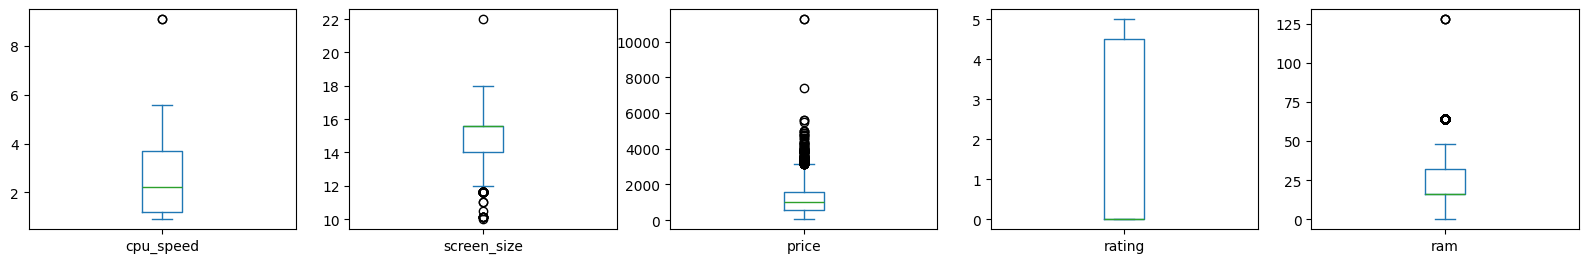

In [ ]:
numeric_cols = ['cpu_speed','screen_size','price','rating','ram']
df[numeric_cols].plot(kind='box', subplots=True, figsize=(20,20), layout=(6,5))
plt.show()

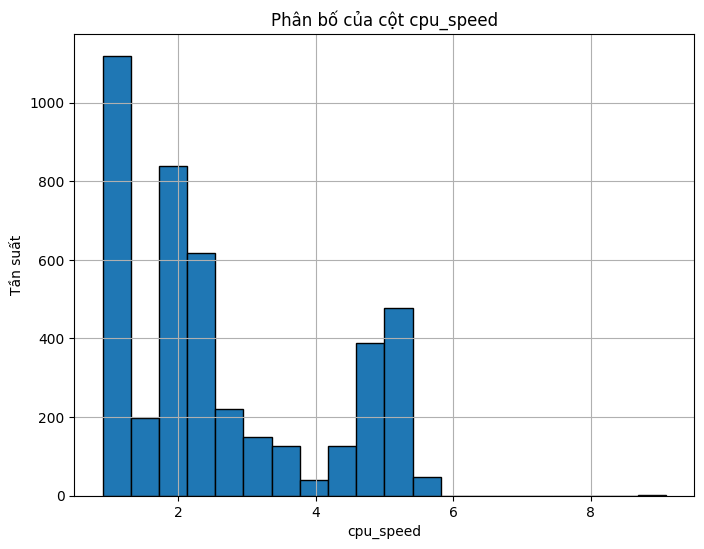

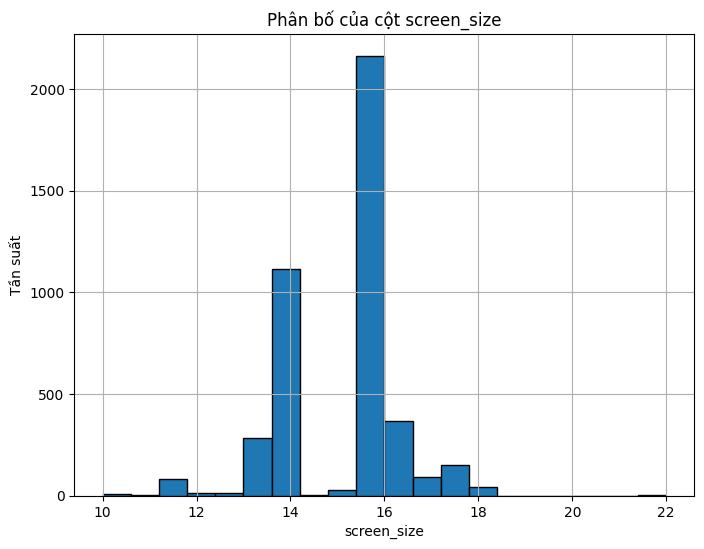

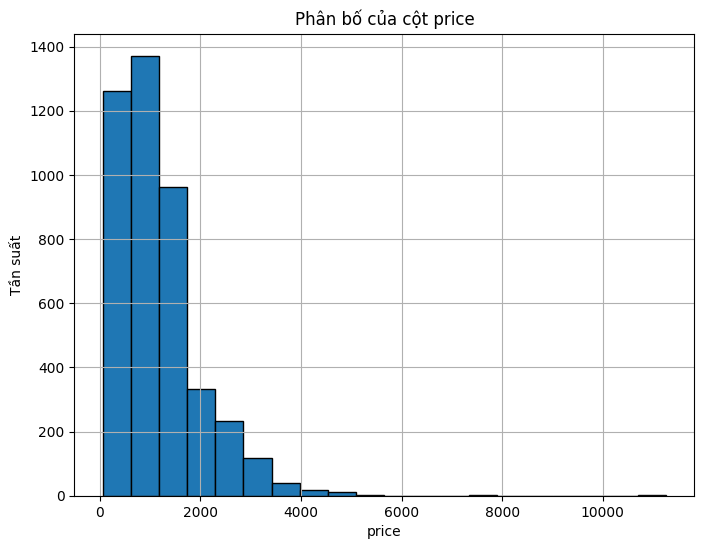

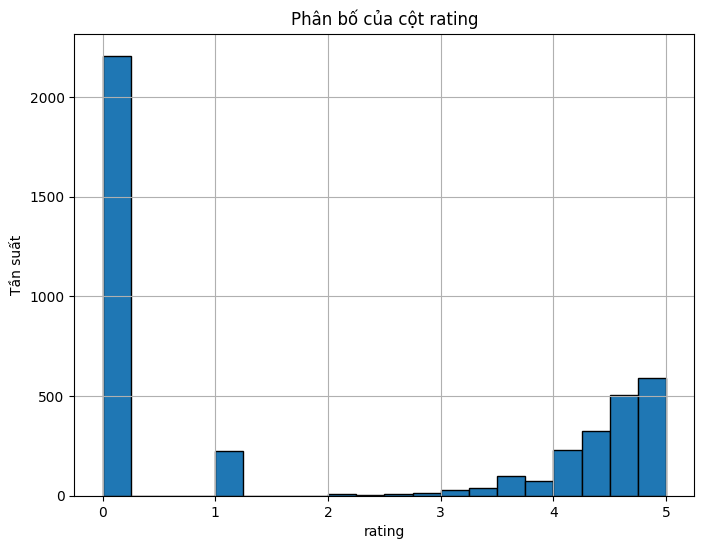

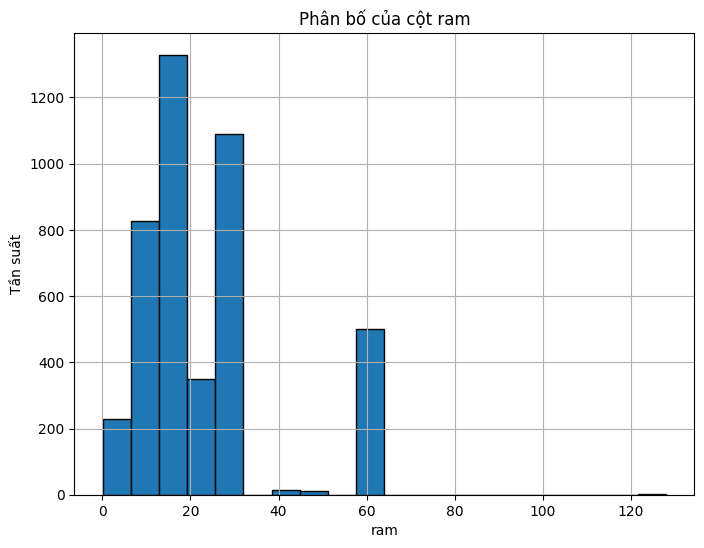

In [ ]:
import matplotlib.pyplot as plt
df2 = df.copy()
numeric_cols = ['cpu_speed','screen_size','price','rating','ram']
for column in numeric_cols:
    # Vẽ histogram
    plt.figure(figsize=(8, 6))  # Điều chỉnh kích thước hình nếu cần
    plt.hist(df[column], bins=20, edgecolor='black')  # Điều chỉnh số bins nếu cần
    plt.title(f'Phân bố của cột {column}')
    plt.xlabel(column)
    plt.ylabel('Tần suất')
    plt.grid(True)
    plt.show()
# loại bỏ outlier ở screen_size, cpu_speed (maybe), price

In [ ]:
def print_boundaries_IQR(col,df):
  Q1 = df[col].quantile(0.25)  # Phân vị thứ 25
  Q3 = df[col].quantile(0.75)  # Phân vị thứ 75
  IQR = Q3 - Q1  # Khoảng tứ phân vị

  # Xác định giới hạn dưới và trên
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df= df[(df[col] >= lower_bound) & (df[col] <= upper_bound)] # what if
  return df

df_plot_before_IQR = df.copy()
numeric_cols = ['cpu_speed','screen_size','price'] # ko bỏ cột ram (tại vì tính chất nó ko phải do lỗi nhập liệu), ko bỏ cột rating (yếu tố phụ, ảnh hưởng ít tới model)
for col in numeric_cols:
  df = print_boundaries_IQR(col,df)


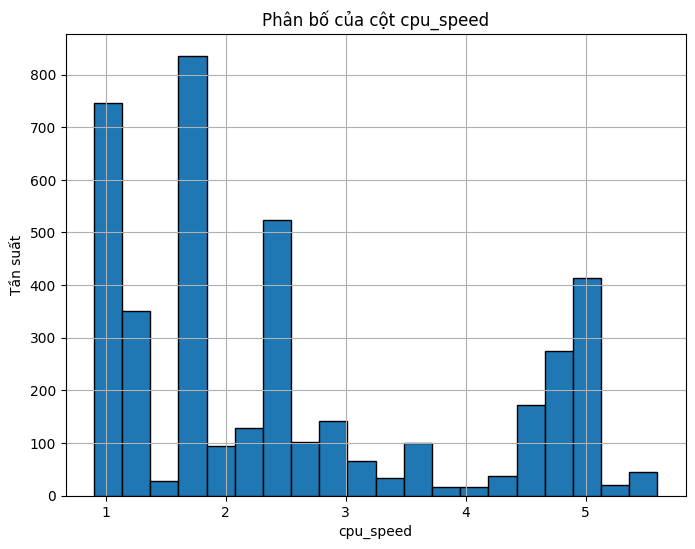

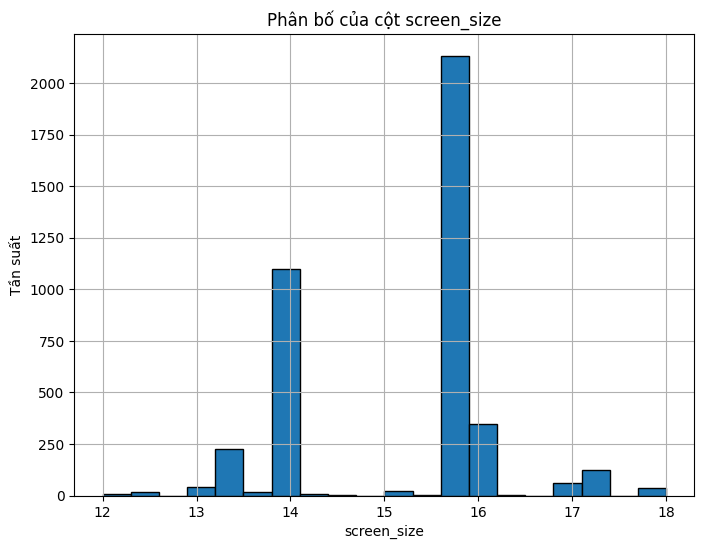

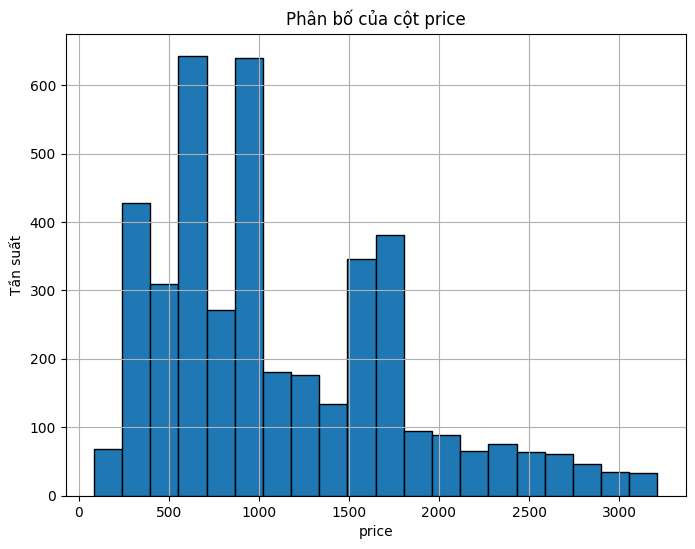

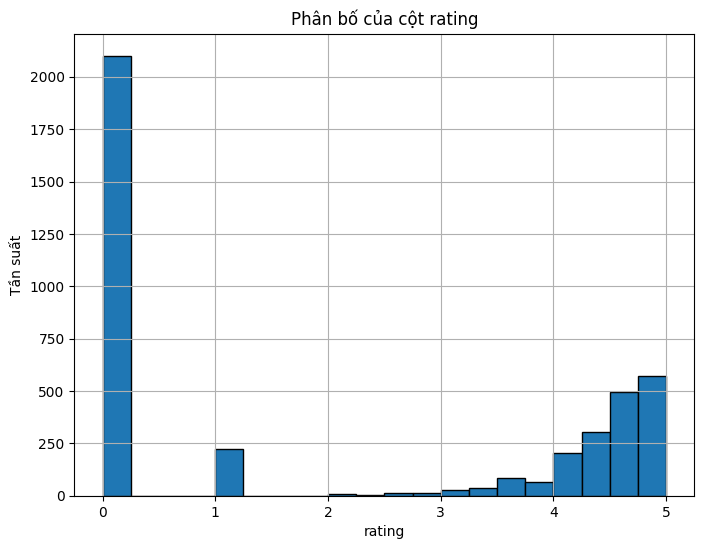

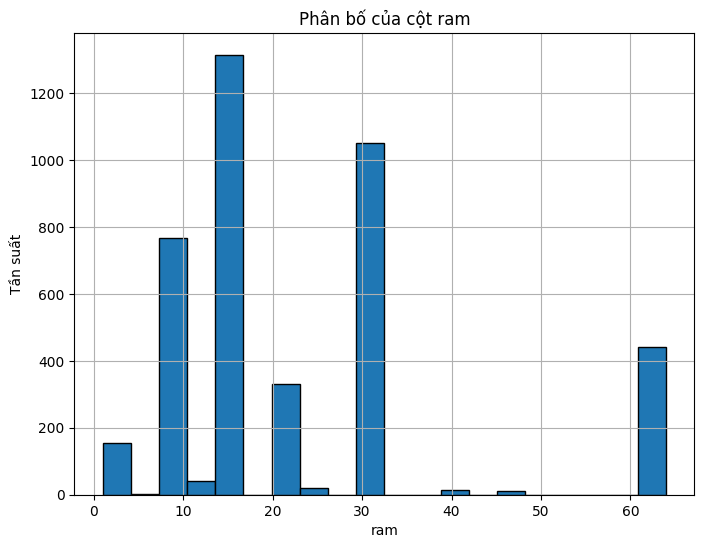

In [ ]:
numeric_cols = ['cpu_speed','screen_size','price','rating','ram']
for column in numeric_cols:
    # Vẽ histogram
    plt.figure(figsize=(8, 6))  # Điều chỉnh kích thước hình nếu cần
    plt.hist(df[column], bins=20, edgecolor='black')  # Điều chỉnh số bins nếu cần
    plt.title(f'Phân bố của cột {column}')
    plt.xlabel(column)
    plt.ylabel('Tần suất')
    plt.grid(True)
    plt.show()

## Kiểm định (Chọn features)

### Biến phân loại

In [ ]:
# Kiểm định Chi-Squared
def Chi2_categorical_features(df: pd.DataFrame):
    features = []
    p_values = []
    chi2_stats = []
    for col in df.columns:
        if col == 'price':
            continue
        contingency_table = pd.crosstab(df[col], df['price'])
        chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

        if p_value < 0.05:
            print(f"Có sự tác động của biến {col.strip()} lên biến mục tiêu price!")
            features.append(col)
            p_values.append(p_value)
            chi2_stats.append(chi2_stat)
        else:
            print(f"Không có sự tác động của biến {col.strip()} lên biến mục tiêu price!")
    return pd.DataFrame({
        'Categorical_Features': features,
        'Statistical': chi2_stats,
        'P-Value': p_values
    })

In [ ]:
categorical_df = Chi2_categorical_features(df[['brand','color','OS','VGA','price']])
print(categorical_df)
categorical_cols = list(categorical_df['Categorical_Features'])

Có sự tác động của biến brand lên biến mục tiêu price!
Có sự tác động của biến color lên biến mục tiêu price!
Có sự tác động của biến OS lên biến mục tiêu price!
Có sự tác động của biến VGA lên biến mục tiêu price!
  Categorical_Features    Statistical  P-Value
0                brand  103047.242611      0.0
1                color   27429.896964      0.0
2                   OS   22902.941667      0.0
3                  VGA  270582.513057      0.0


### Biến số

In [ ]:
def corr_numerical_features(df: pd.DataFrame, alpha: float = 0.05, threshold: float = 0.2):
    """
      Phân tích mối tương quan giữa các biến số độc lập và biến phụ thuộc `price`.

      Hàm này sử dụng hệ số tương quan Spearman để tính toán mức độ tương quan giữa
      các cột số (numerical features) trong DataFrame với cột `price`. Hàm cũng kiểm tra
      ý nghĩa thống kê dựa trên giá trị p-value và ngưỡng tương quan đã định nghĩa.
    """
    features = []
    p_values = []
    corr_values = []
    for col in df.columns:
        if col == 'price':
            continue
        corr, p_value = stats.spearmanr(df['price'], df[col])
        if p_value >= alpha:
            print(f"Không có ý nghĩa thống kê của biến độc lập {col} tác động đến biến phụ thuộc price!")
            continue
        if abs(corr) >= threshold:
            print(f"Có sự tương quan giữa biến độc lập {col} và biến phụ thuộc price!")
            features.append(col)
            p_values.append(p_value)
            corr_values.append(corr)
        else:
            print(f"Không có sự tương quan giữa biến độc lập {col} và biến phụ thuộc price!")
    return pd.DataFrame({
        'Numerical_Features': features,
        'Correlation': corr_values,
        'P-Value': p_values
    })

In [ ]:
numerical_df = corr_numerical_features(df[['screen_size','harddisk','cpu','ram', 'cpu_speed' ,'rating','price']])
print(numerical_df)
numerical_cols = list(numerical_df['Numerical_Features'])

Có sự tương quan giữa biến độc lập screen_size và biến phụ thuộc price!
Không có sự tương quan giữa biến độc lập harddisk và biến phụ thuộc price!
Không có sự tương quan giữa biến độc lập cpu và biến phụ thuộc price!
Có sự tương quan giữa biến độc lập ram và biến phụ thuộc price!
Có sự tương quan giữa biến độc lập cpu_speed và biến phụ thuộc price!
Có sự tương quan giữa biến độc lập rating và biến phụ thuộc price!
  Numerical_Features  Correlation        P-Value
0        screen_size     0.323092  2.505804e-101
1                ram     0.483563  6.090591e-242
2          cpu_speed     0.505711  4.593796e-268
3             rating    -0.212330   1.827478e-43


## Chuẩn hóa dữ liệu

Chuẩn hóa biến số

In [ ]:
df_after_IQR = df.copy()

In [ ]:
scaler = StandardScaler()
for i in ['screen_size','harddisk','cpu','ram', 'cpu_speed' ,'rating','price']:
    if i != 'price' and df.dtypes[i] in ['int64', 'float64']:
        df[i] = scaler.fit_transform(df[[i]])

## Dataset sau khi preprocess

In [ ]:
refined_df = pd.concat((df[categorical_cols], df[numerical_cols], df[['price']]), axis=1)

# EDA after preprocessing

## Thống kê mô tả

### Biến phân loại

In [ ]:

categorical_columns = ["brand", "color","cpu","OS","VGA"]
df_cate = df2[categorical_columns]

In [ ]:
statistical_category(df_cate)

Sự phân bổ giá trị phân loại trong thuộc tính brand
    Value  Frequency
0      10   0.387549
1      16   0.183552
2      33   0.146106
3      27   0.108201
4      20   0.069837
5       3   0.036986
6       0   0.025270
7      21   0.008959
8       2   0.005284
9      34   0.005054
10     25   0.003216
11      1   0.002986
12     30   0.002757
13     13   0.002527
14     37   0.002527
15     32   0.001378
16     19   0.000689
17      7   0.000459
18     35   0.000459
19      9   0.000459
20     23   0.000459
21     31   0.000459
22     12   0.000459
23     17   0.000459
24     40   0.000230
25     26   0.000230
26     18   0.000230
27     39   0.000230
28     36   0.000230
29     24   0.000230
30     14   0.000230
31     11   0.000230
32      6   0.000230
33     38   0.000230
34      8   0.000230
35     29   0.000230
36     15   0.000230
37     22   0.000230
38      5   0.000230
39      4   0.000230
40     28   0.000230
------------------------------------------------------------------

### Biến kiểu số

In [ ]:
numerical_cols = ["screen_size", "cpu_speed", "ram","rating","harddisk"]
# biểu đồ phân bố
# biểu đồ boxplot
# heatmap


def visualize_hists(df: pd.DataFrame, numerical_cols):
    """
    Vẽ biểu đồ phân bố (histogram) cho các cột số.
    """
    # Xác định số hàng và cột cho subplot
    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

    # Tạo các subplots
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))

    # Duyệt qua các cột và vẽ biểu đồ
    for i, col in enumerate(numerical_cols):
        row, col_pos = divmod(i, n_cols)
        sns.histplot(data=df, x=col, kde=True, bins=40, ax=ax[row, col_pos])
        ax[row, col_pos].set_title(f"Figure {i+1}: Biểu đồ phân bố của {col}")

    # Ẩn các subplot dư thừa
    for j in range(len(numerical_cols), n_rows * n_cols):
        fig.delaxes(ax.flatten()[j])

    plt.tight_layout()
    plt.show()

def visualize_boxplots(df: pd.DataFrame, numerical_cols):
    """
    Vẽ biểu đồ BoxPlot cho các cột số.
    """
    # Xác định số hàng và cột cho subplot
    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

    # Tạo các subplots
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))

    # Duyệt qua các cột và vẽ biểu đồ
    for i, col in enumerate(numerical_cols):
        row, col_pos = divmod(i, n_cols)
        sns.boxplot(data=df, x=col, ax=ax[row, col_pos])
        ax[row, col_pos].set_title(f"Figure {i+1}: BoxPlot của {col}")

    # Ẩn các subplot dư thừa
    for j in range(len(numerical_cols), n_rows * n_cols):
        fig.delaxes(ax.flatten()[j])

    plt.tight_layout()
    plt.show()

def visualize_hists_for_obj_cols(df: pd.DataFrame, cols):
    """
    Vẽ biểu đồ phân bố (histogram) kèm line plot cho các cột số.
    """
    # Xác định số hàng và cột cho subplot
    n_cols = 2
    n_rows = 1

    # Tạo các subplots
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 9, n_rows * 6))

    # Đảm bảo `ax` là mảng 2D
    if n_rows == 1:
        ax = np.array([ax])  # Chuyển thành mảng 2D nếu chỉ có 1 hàng

    # Duyệt qua các cột và vẽ biểu đồ
    for i, col in enumerate(cols):
        row, col_pos = divmod(i, n_cols)
        sns.histplot(data=df, x=col, kde=True, bins=10, ax=ax[row, col_pos], shrink=0.8)

        # Vẽ thêm đường line (nếu cần)
        values = df[col].dropna().value_counts().sort_index()

        # Cài đặt tiêu đề và chú thích
        ax[row, col_pos].set_title(f"Figure {i+1}: Biểu đồ phân bố của {col}")

    # Ẩn các subplot dư thừa
    for j in range(len(cols), n_rows * n_cols):
        fig.delaxes(ax.flatten()[j])

    # Điều chỉnh khoảng cách giữa các subplots
    plt.tight_layout(pad=3.0)
    plt.show()

#### Phân phối của các cột số

Trước khi fill NA

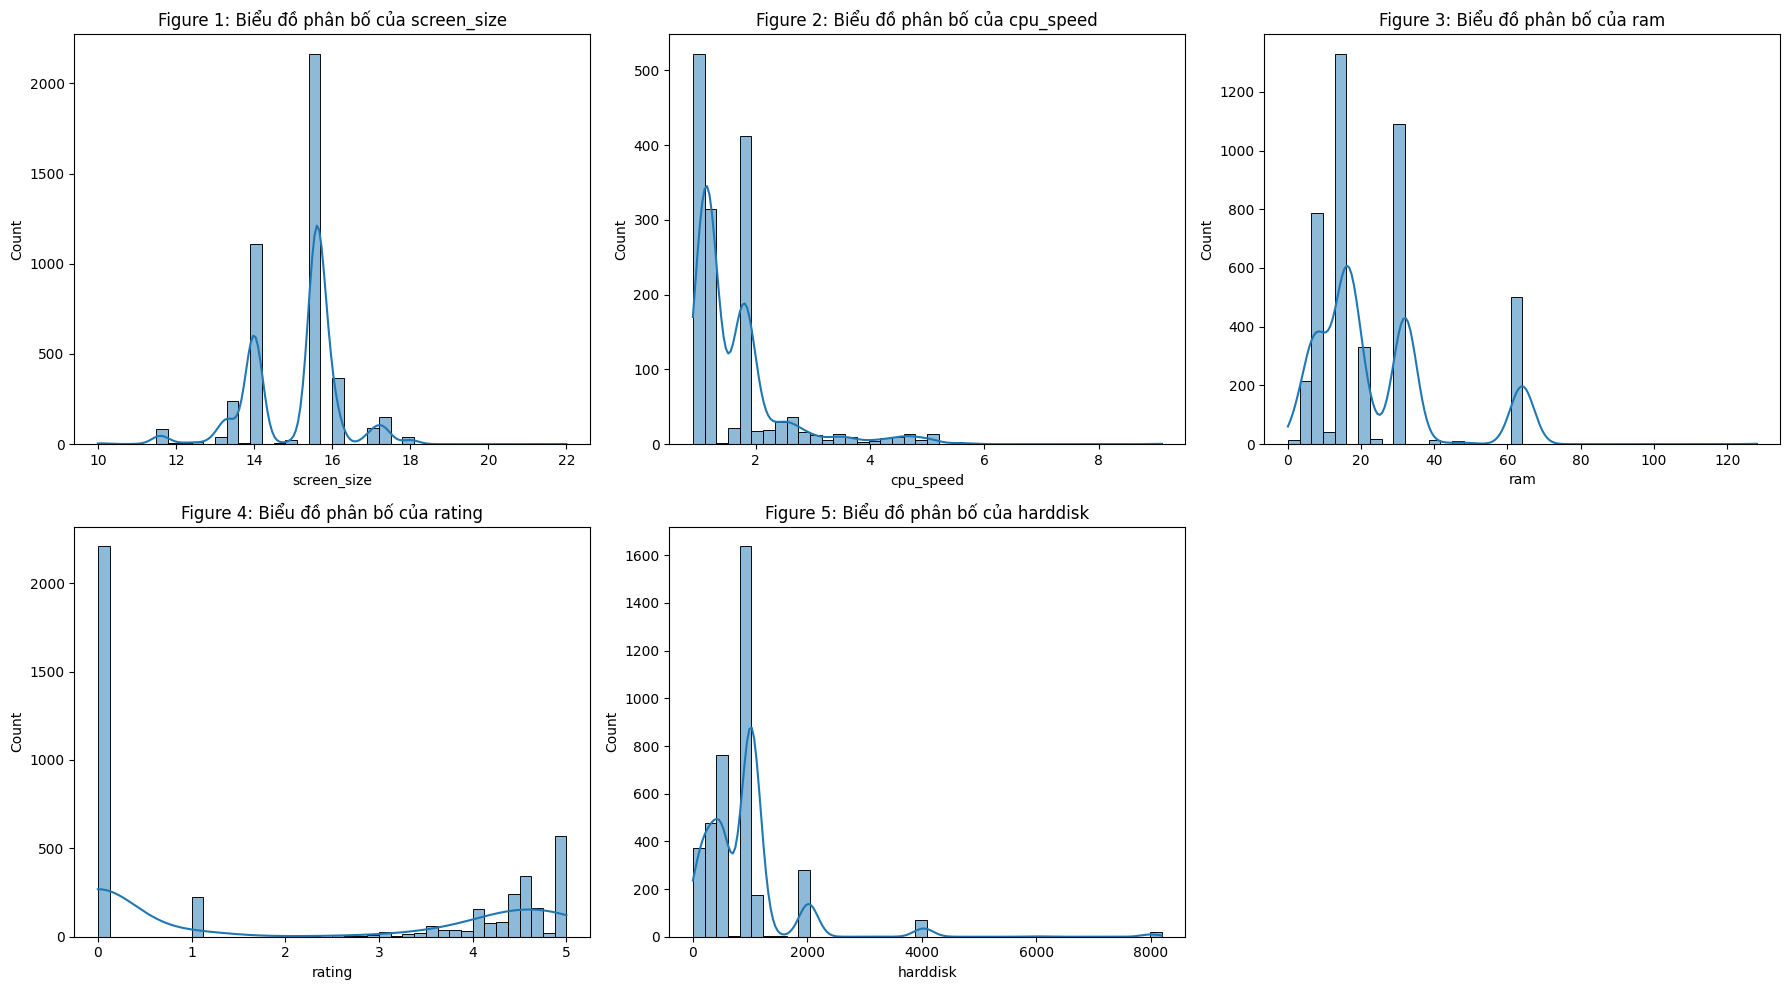

In [ ]:
visualize_hists(df_before_fill_NA, numerical_cols)

OS và Color trước khi fill NA

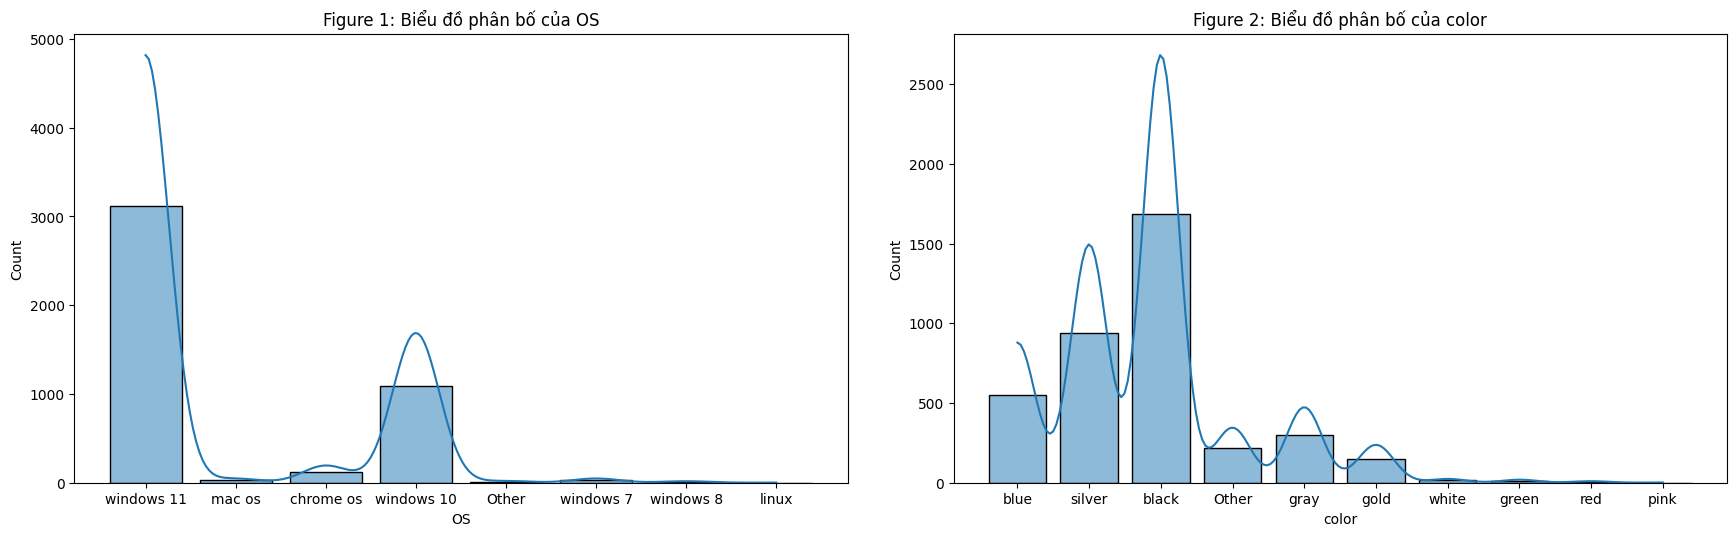

In [ ]:
os_cols = ["OS","color"]
visualize_hists_for_obj_cols(df_before_fill_OS_color, os_cols)

OS và color sau khi fill NA

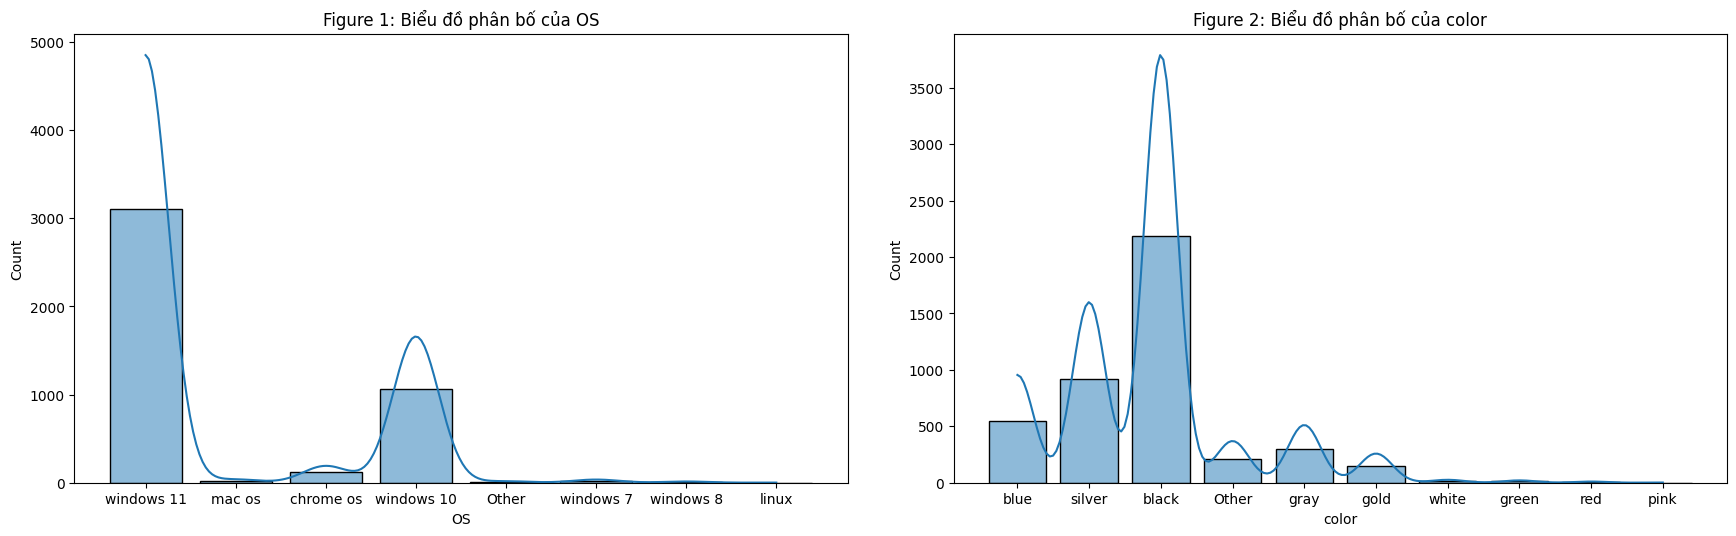

In [ ]:
visualize_hists_for_obj_cols(df_after_fill_OS_color, os_cols)

Sau khi fill NA

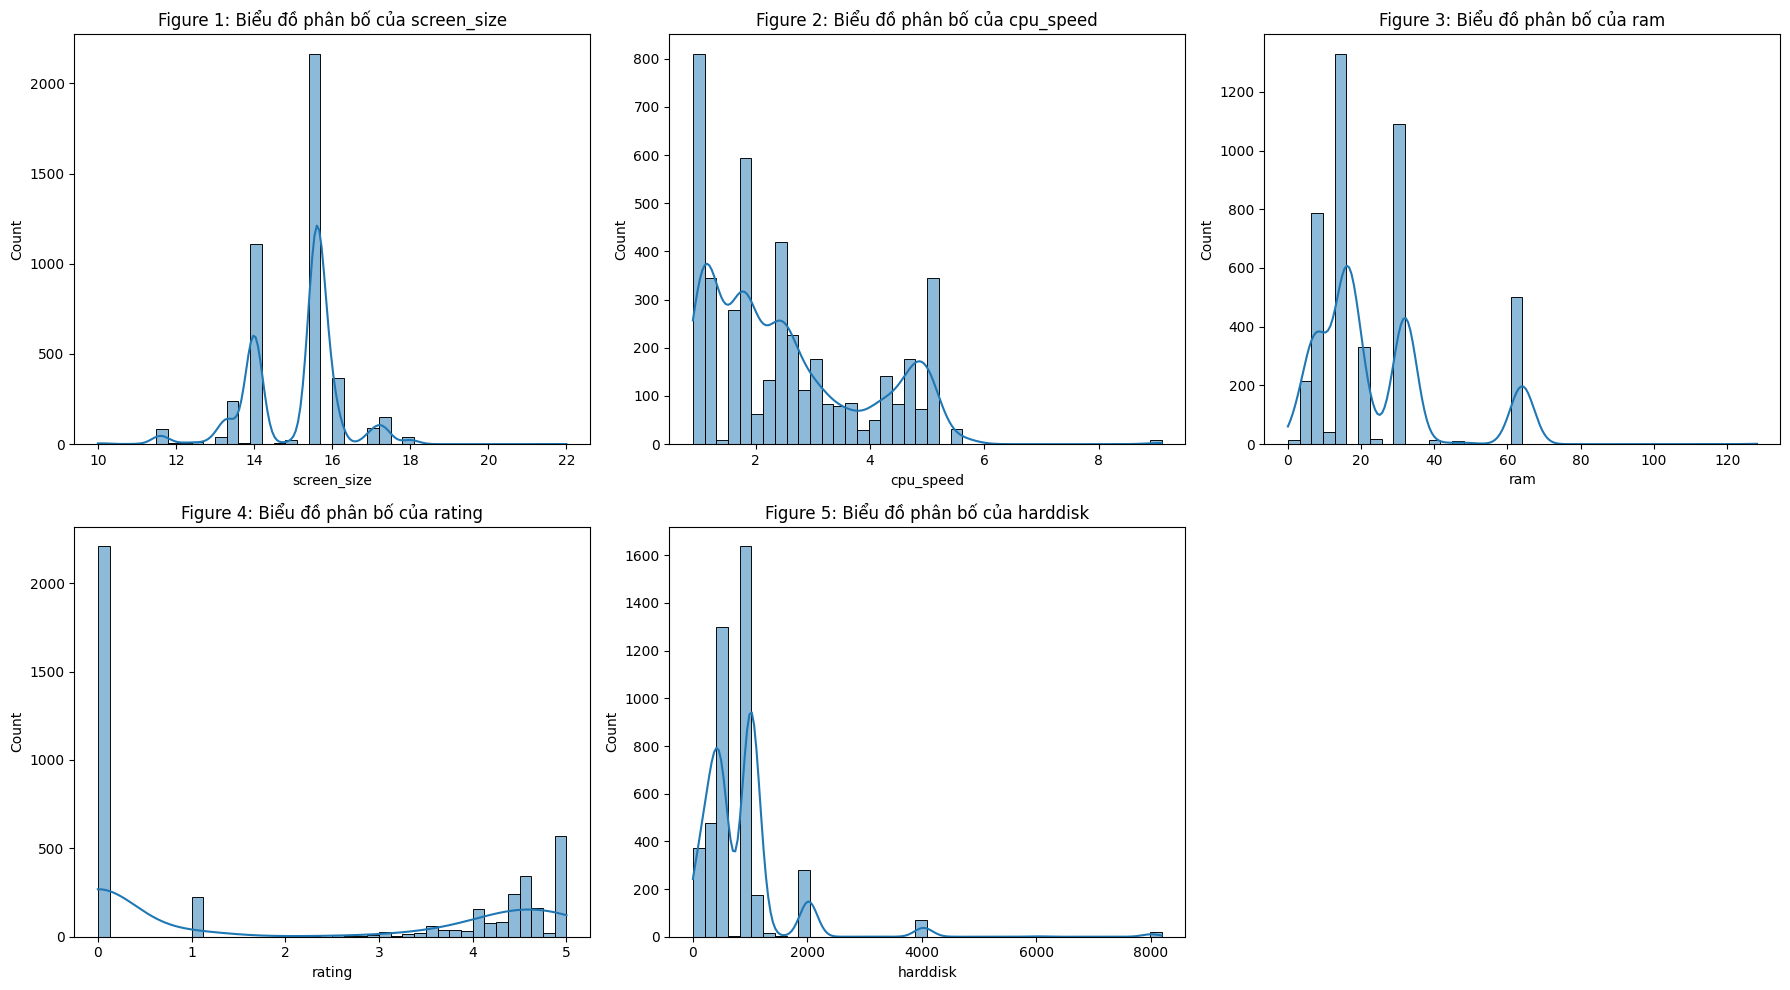

In [ ]:
visualize_hists(df_after_fill_NA, numerical_cols)

Sau khi fill NA + IQR

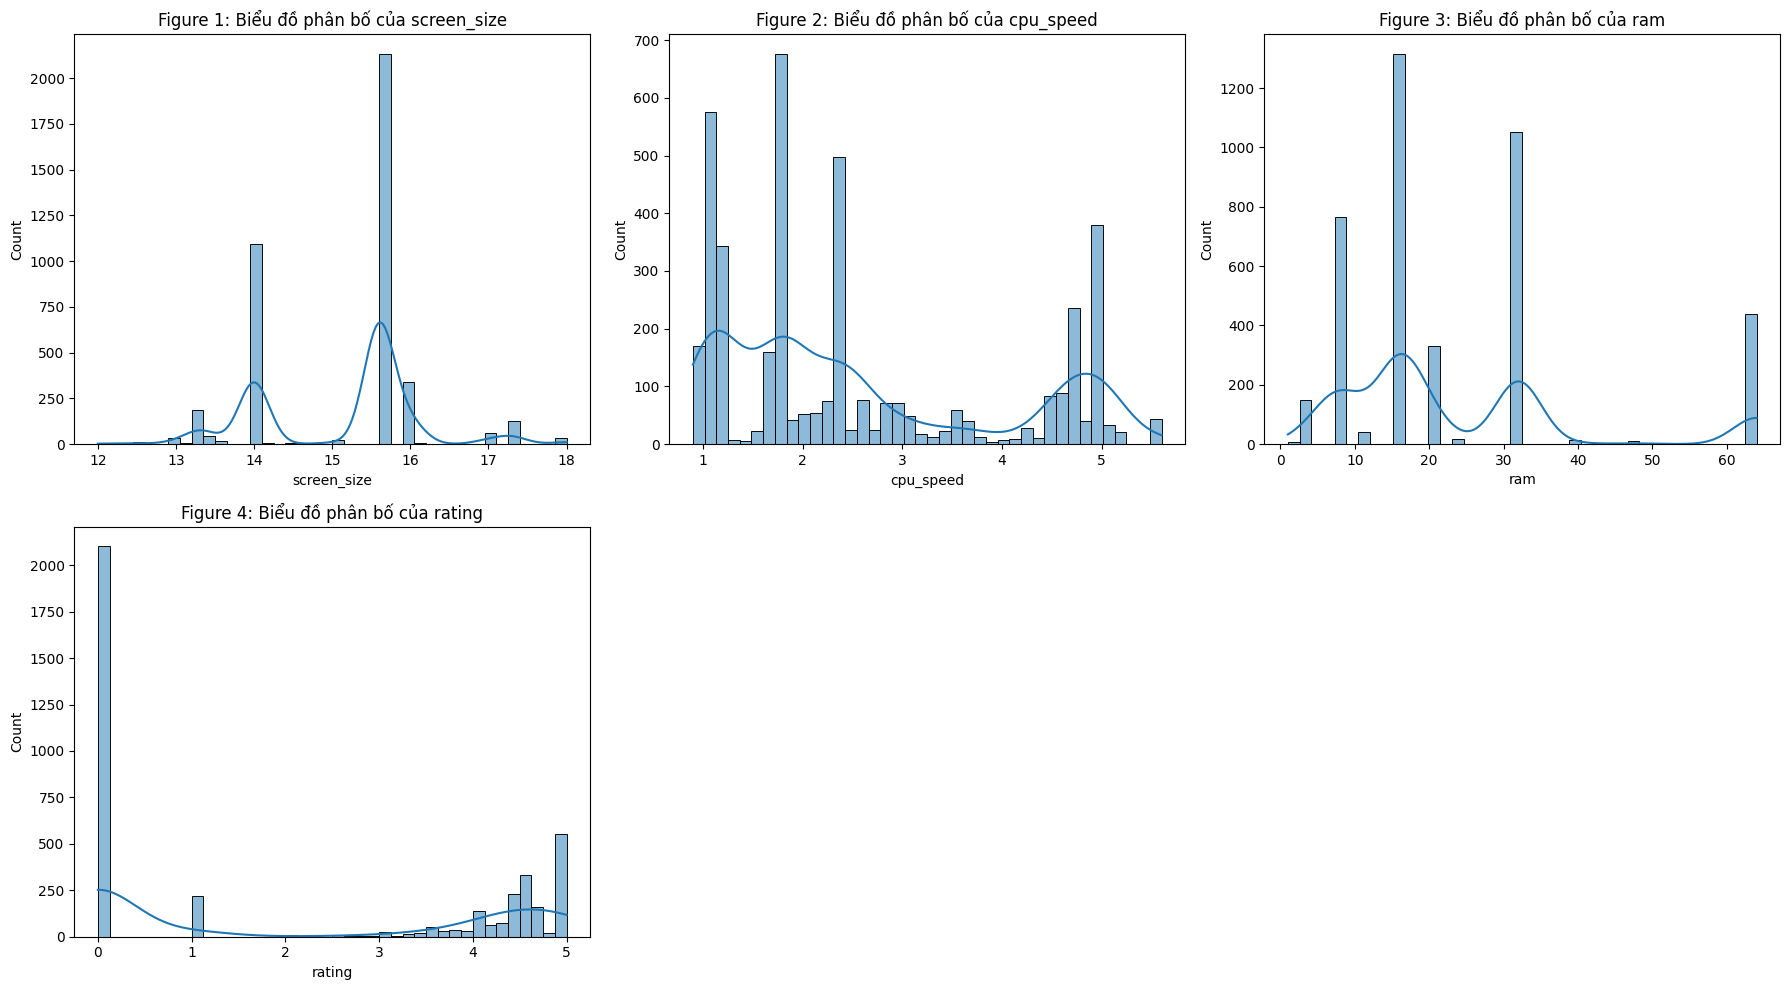

In [ ]:
visualize_hists(df_after_IQR, numerical_cols)

Tại sao dùng decisionTreeRegressor điền null cho cpu_speed

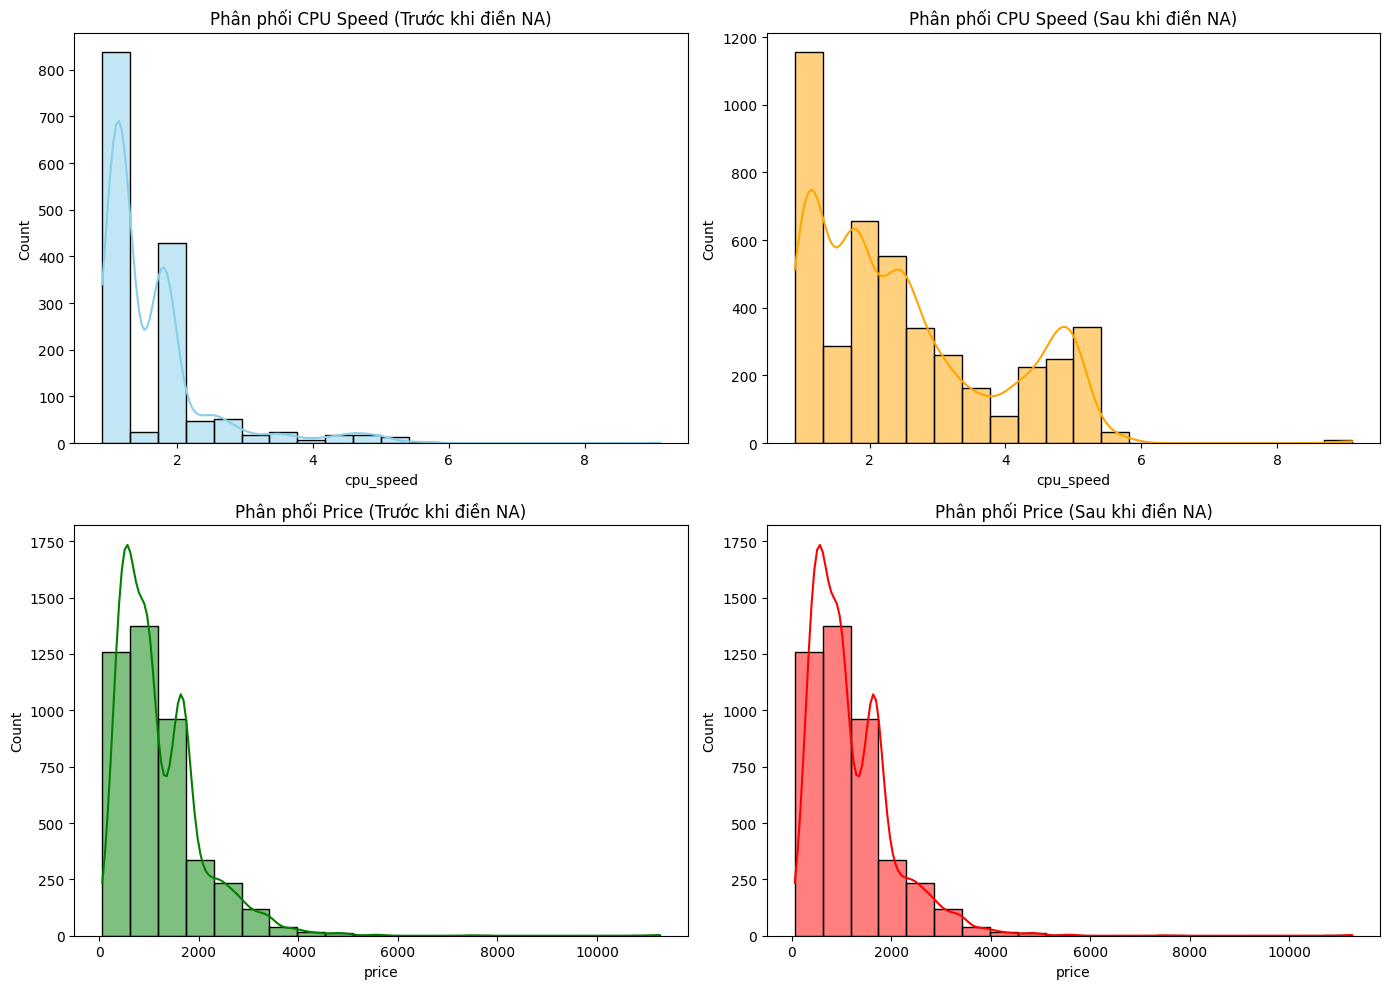

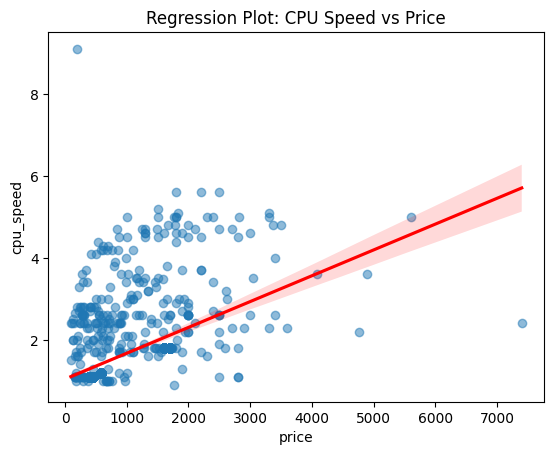

<ipython-input-127-0a0ea556ae6f>:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cpu_speed_by_group = df_before_fill_NA.groupby('price_group')['cpu_speed'].mean()


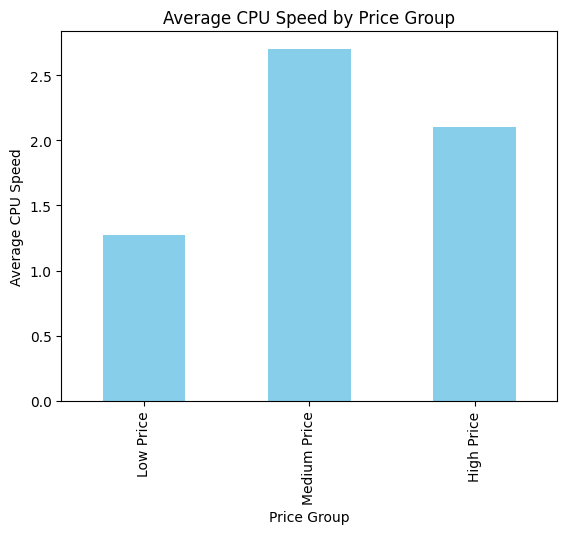

Hệ số tương quan giữa CPU Speed và Price: 0.52


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Biểu đồ phân phối CPU Speed trước khi điền
sns.histplot(df_before_fill_NA['cpu_speed'], kde=True, bins=20, ax=ax[0, 0], color='skyblue')
ax[0, 0].set_title('Phân phối CPU Speed (Trước khi điền NA)')

# Biểu đồ phân phối CPU Speed sau khi điền
sns.histplot(df_after_fill_NA['cpu_speed'], kde=True, bins=20, ax=ax[0, 1], color='orange')
ax[0, 1].set_title('Phân phối CPU Speed (Sau khi điền NA)')

# Biểu đồ phân phối Price trước khi điền
sns.histplot(df_before_fill_NA['price'], kde=True, bins=20, ax=ax[1, 0], color='green')
ax[1, 0].set_title('Phân phối Price (Trước khi điền NA)')

# Biểu đồ phân phối Price sau khi điền
sns.histplot(df_after_fill_NA['price'], kde=True, bins=20, ax=ax[1, 1], color='red')
ax[1, 1].set_title('Phân phối Price (Sau khi điền NA)')

# Tùy chỉnh layout
plt.tight_layout()
plt.show()

# 4. Thêm đường hồi quy để thấy xu hướng tuyến tính
sns.regplot(data=df_before_fill_NA, x='price', y='cpu_speed', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Regression Plot: CPU Speed vs Price')
plt.show()

# 5. Chia `price` thành nhóm để kiểm tra xu hướng
df_before_fill_NA['price_group'] = pd.qcut(df_before_fill_NA['price'], q=3, labels=['Low Price', 'Medium Price', 'High Price'])
cpu_speed_by_group = df_before_fill_NA.groupby('price_group')['cpu_speed'].mean()

# Vẽ biểu đồ trung bình `cpu_speed` theo nhóm `price`
cpu_speed_by_group.plot(kind='bar', color='skyblue')
plt.title('Average CPU Speed by Price Group')
plt.ylabel('Average CPU Speed')
plt.xlabel('Price Group')
plt.show()

# 6. Hệ số tương quan giữa `cpu_speed` và `price`
correlation = df_before_fill_NA['cpu_speed'].corr(df_before_fill_NA['price'])

print(f"Hệ số tương quan giữa CPU Speed và Price: {correlation:.2f}")

Trước khi dùng IQR

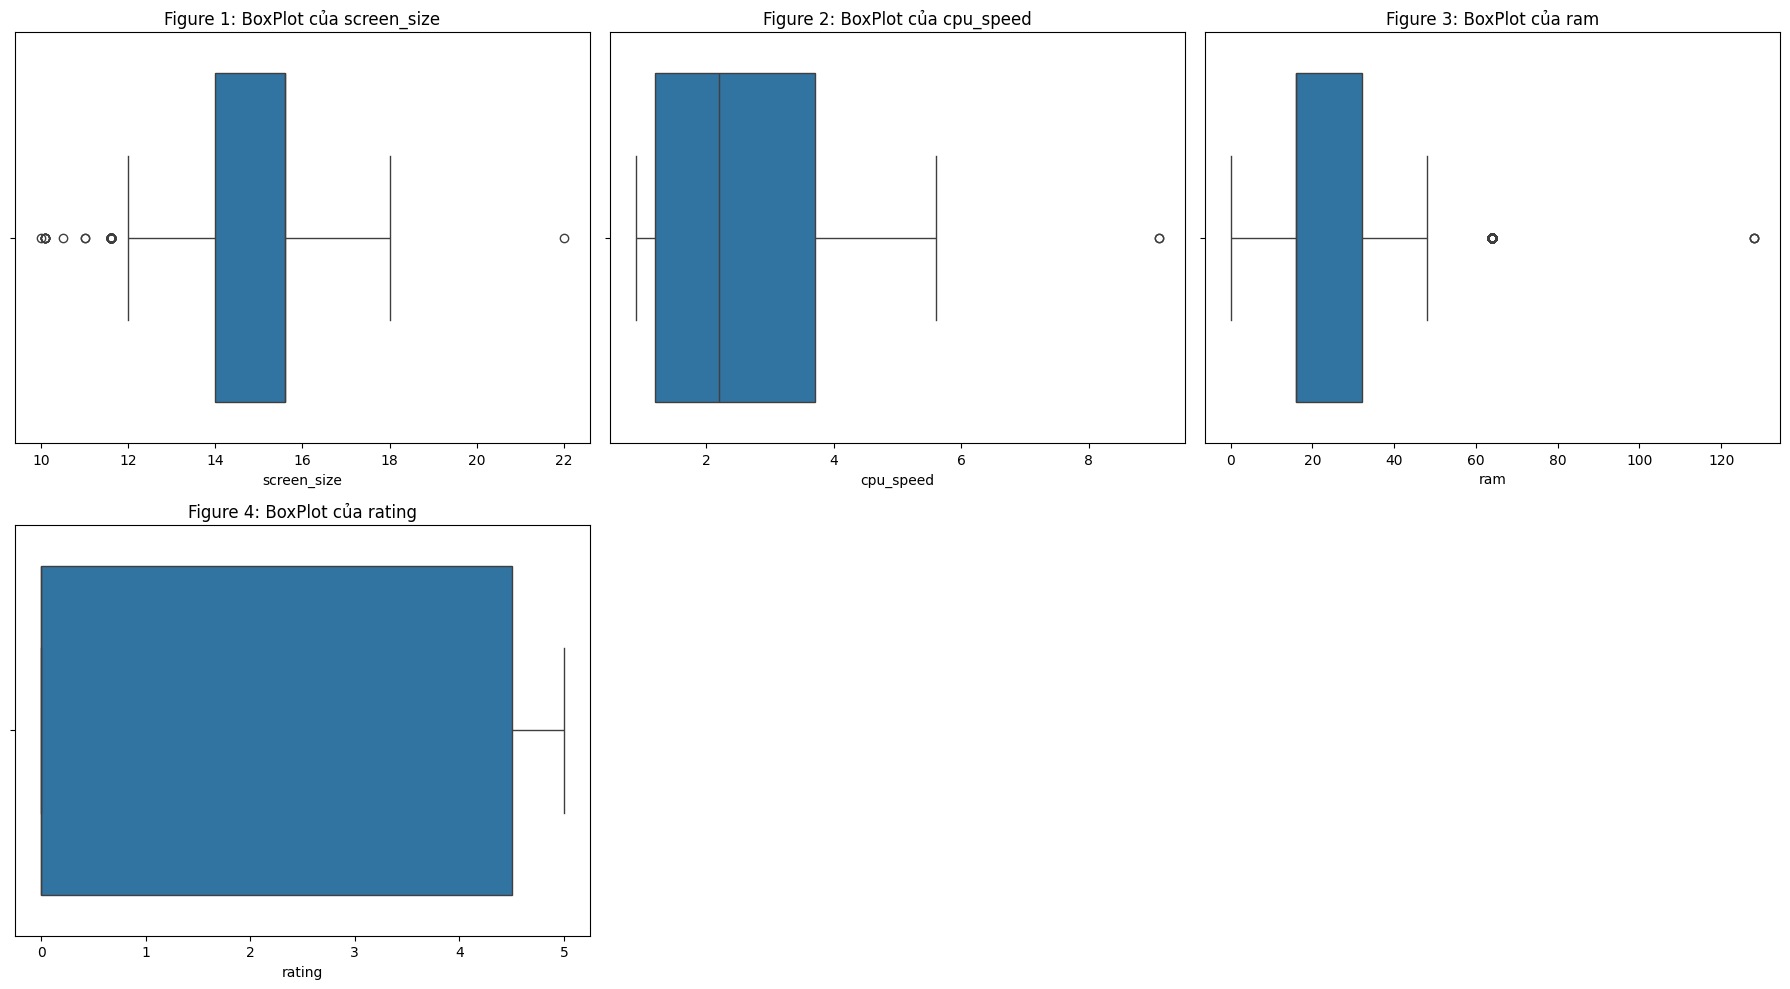

In [ ]:
visualize_boxplots(df_plot_before_IQR, numerical_cols)

Sau khi dùng IQR

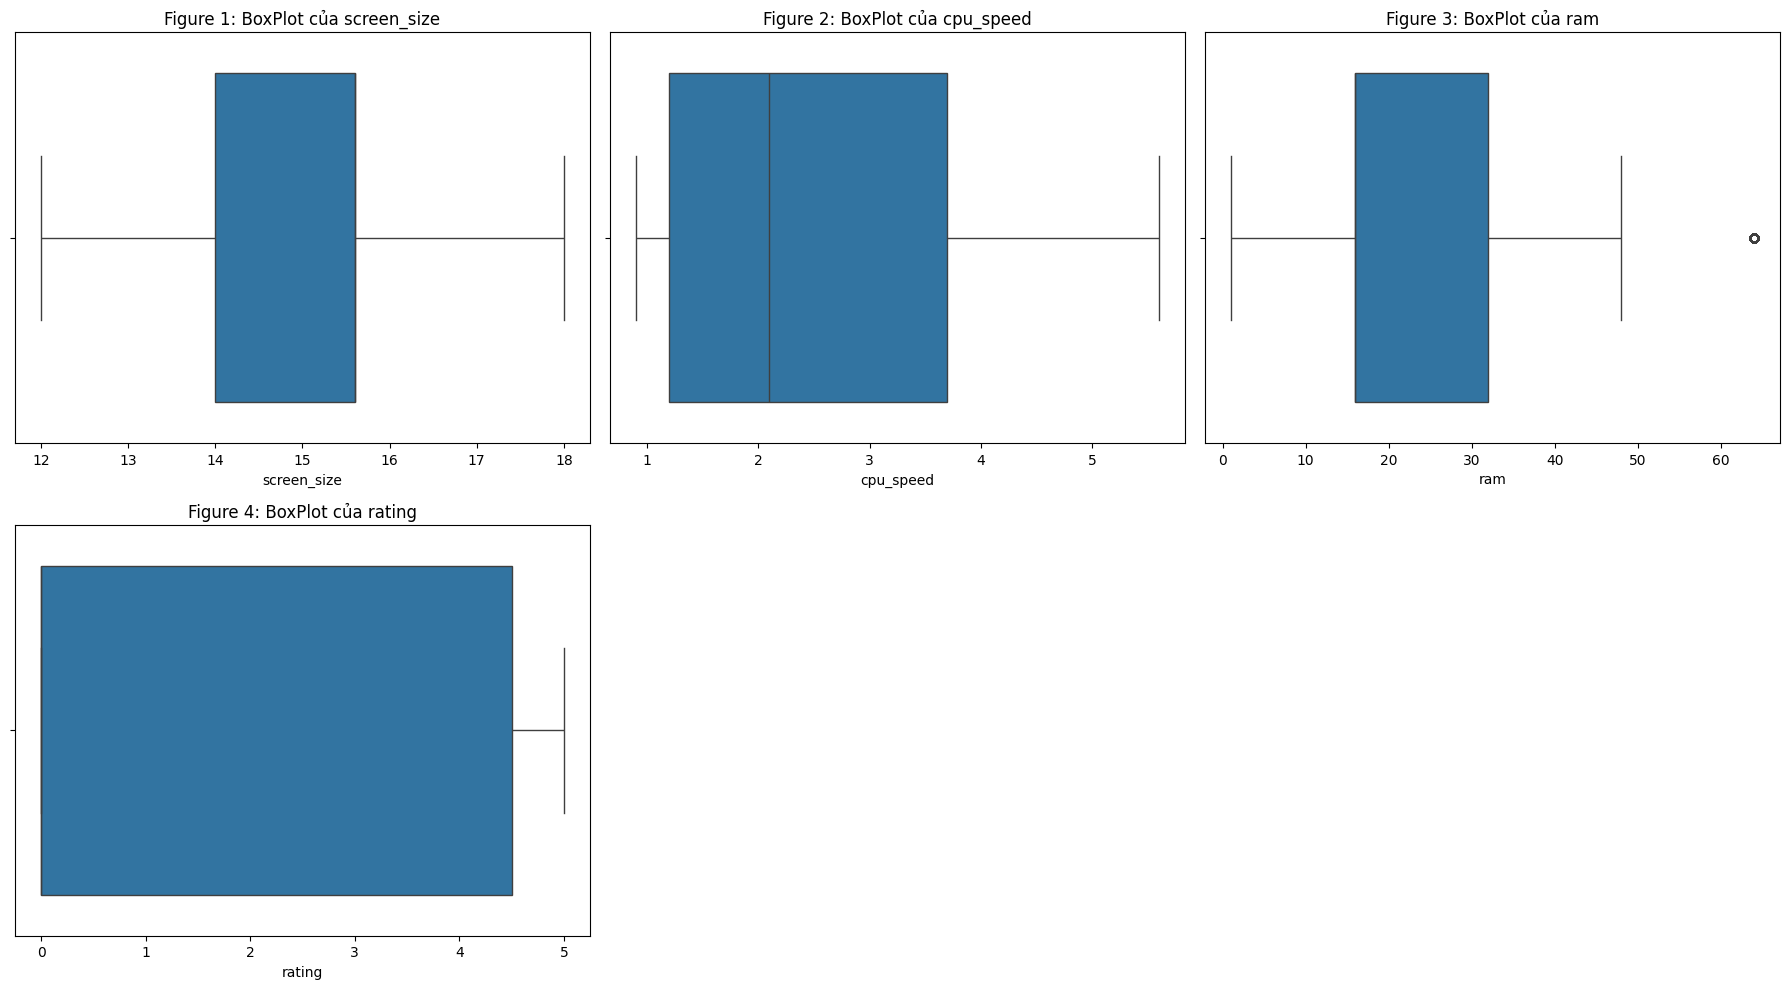

In [ ]:
visualize_boxplots(df_after_IQR, numerical_cols)

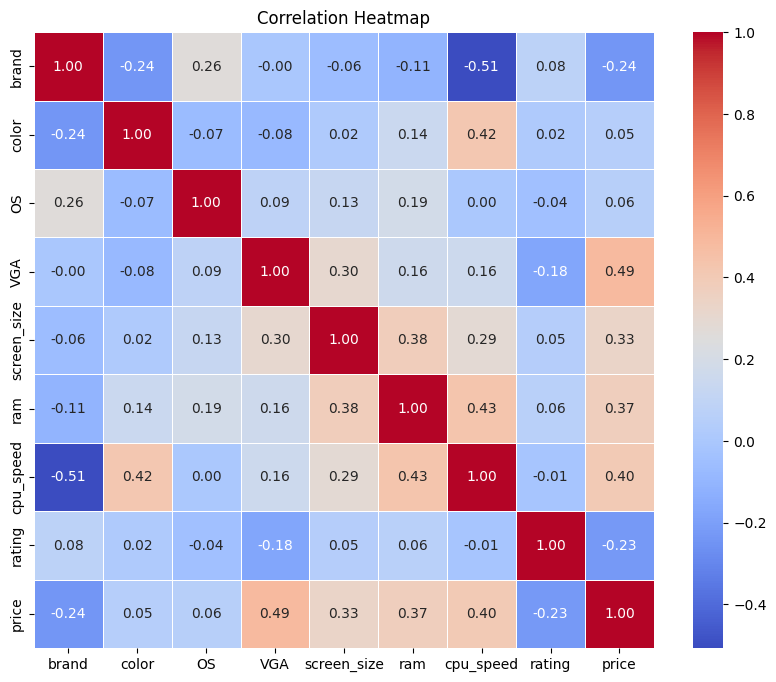

In [ ]:
plot_correlation_heatmap(refined_df)

## Kiểm định

### Biến phân loại

In [ ]:
categorical_df = Chi2_categorical_features(df[['brand','color','OS','VGA','price']])
print(categorical_df)

Có sự tác động của biến brand lên biến mục tiêu price!
Có sự tác động của biến color lên biến mục tiêu price!
Có sự tác động của biến OS lên biến mục tiêu price!
Có sự tác động của biến VGA lên biến mục tiêu price!
  Categorical_Features    Statistical  P-Value
0                brand  103047.242611      0.0
1                color   27429.896964      0.0
2                   OS   22902.941667      0.0
3                  VGA  270582.513057      0.0


### Biến kiểu số

In [ ]:
numerical_df = corr_numerical_features(df[['screen_size','harddisk','cpu','ram', 'cpu_speed' ,'rating','price']])
print(numerical_df)

Có sự tương quan giữa biến độc lập screen_size và biến phụ thuộc price!
Không có sự tương quan giữa biến độc lập harddisk và biến phụ thuộc price!
Không có sự tương quan giữa biến độc lập cpu và biến phụ thuộc price!
Có sự tương quan giữa biến độc lập ram và biến phụ thuộc price!
Có sự tương quan giữa biến độc lập cpu_speed và biến phụ thuộc price!
Có sự tương quan giữa biến độc lập rating và biến phụ thuộc price!
  Numerical_Features  Correlation        P-Value
0        screen_size     0.323092  2.505804e-101
1                ram     0.483563  6.090591e-242
2          cpu_speed     0.505711  4.593796e-268
3             rating    -0.212330   1.827478e-43


# Models Select/Train

## Split train test set


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(refined_df.drop(columns='price'), refined_df['price'], test_size=0.2, random_state=42)

## Utils functions

In [ ]:
n_features_range = range(4, 8) # (4,5,6,7)
all_feature_combinations = []
for n_features in n_features_range:
    all_feature_combinations.extend(list(combinations(X_train.columns, n_features)))
feature_combinations_str = [",".join(features) for features in all_feature_combinations]

def feature_selector(trial):
    selected_features_str = trial.suggest_categorical('selected_features', feature_combinations_str)
    selected_features = selected_features_str.split(",")
    return selected_features

def scorer(y_true, y_pred):
    return r2_score(y_true, y_pred), mean_absolute_error(y_true, y_pred), mean_squared_error(y_true, y_pred)

## Model select

### Linear Regression

In [ ]:
def objective_LR(trial):
    # Select features
    selected_features = feature_selector(trial)
    X_train_subset = X_train[list(selected_features)]

    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])

    model = LinearRegression(fit_intercept=fit_intercept)

    r2 = cross_val_score(model, X_train_subset, y_train, cv=5, scoring='r2').mean()

    return r2

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective_LR, n_trials=100)

[I 2024-12-14 04:46:58,068] A new study created in memory with name: no-name-11afb7df-e874-4231-bd5a-fb8ddd3a1f32
[I 2024-12-14 04:46:58,124] Trial 0 finished with value: 0.36388302132866046 and parameters: {'selected_features': 'brand,VGA,cpu_speed,rating', 'fit_intercept': True}. Best is trial 0 with value: 0.36388302132866046.
[I 2024-12-14 04:46:58,178] Trial 1 finished with value: -0.04219548806423612 and parameters: {'selected_features': 'brand,VGA,screen_size,ram', 'fit_intercept': False}. Best is trial 0 with value: 0.36388302132866046.
[I 2024-12-14 04:46:58,279] Trial 2 finished with value: 0.3620816413404346 and parameters: {'selected_features': 'OS,VGA,screen_size,ram,cpu_speed,rating', 'fit_intercept': False}. Best is trial 0 with value: 0.36388302132866046.
[I 2024-12-14 04:46:58,354] Trial 3 finished with value: 0.2529797558544097 and parameters: {'selected_features': 'color,OS,screen_size,ram,rating', 'fit_intercept': True}. Best is trial 0 with value: 0.363883021328660

In [ ]:
best_trial = study.best_trial
print(f"Best Parameters: {best_trial.params}")
print(f"Best R² Score: {best_trial.value}")
best_params = study.best_params
best_features = best_params['selected_features'].split(',')
best_params.pop('selected_features')

X_train_subset = X_train[best_features]
X_test_subset = X_test[best_features]

best_model = LinearRegression(**best_params)
best_model.fit(X_train_subset, y_train)
y_hat = best_model.predict(X_test_subset)

r2, mae, mse = scorer(y_test, y_hat)
print("============EVALUATED:==========")
print("R2 Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

Best Parameters: {'selected_features': 'brand,color,VGA,screen_size,ram,cpu_speed,rating', 'fit_intercept': True}
Best R² Score: 0.4175192451356843
============EVALUATED:==========
R2 Score: 0.4155544102128351
Mean Absolute Error (MAE): 403.3064700566847
Mean Squared Error (MSE): 257256.34971102385


### Ridge

In [ ]:
def objective_R(trial):
    # Select features
    selected_features = feature_selector(trial)
    X_train_subset = X_train[list(selected_features)]

    alpha = trial.suggest_float('alpha', 0.1, 10.0, log=True)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])

    model = Ridge(alpha=alpha, fit_intercept=fit_intercept)

    r2 = cross_val_score(model, X_train_subset, y_train, cv=5, scoring='r2').mean()

    return r2

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective_R, n_trials=100)

[I 2024-12-14 04:47:12,007] A new study created in memory with name: no-name-3aff8fbf-63b3-43ac-bc37-8d65f7befa5a
[I 2024-12-14 04:47:12,256] Trial 0 finished with value: 0.4157400913425529 and parameters: {'selected_features': 'brand,OS,VGA,screen_size,ram,cpu_speed,rating', 'alpha': 0.3511034264612037, 'fit_intercept': True}. Best is trial 0 with value: 0.4157400913425529.
[I 2024-12-14 04:47:12,366] Trial 1 finished with value: 0.31559771702005507 and parameters: {'selected_features': 'brand,color,VGA,screen_size', 'alpha': 0.13883128252575408, 'fit_intercept': True}. Best is trial 0 with value: 0.4157400913425529.
[I 2024-12-14 04:47:12,417] Trial 2 finished with value: -1.0298532580420372 and parameters: {'selected_features': 'color,screen_size,ram,rating', 'alpha': 6.985975772925155, 'fit_intercept': False}. Best is trial 0 with value: 0.4157400913425529.
[I 2024-12-14 04:47:12,534] Trial 3 finished with value: 0.22945979674526312 and parameters: {'selected_features': 'color,OS,s

In [ ]:
best_trial = study.best_trial
print(f"Best Parameters: {best_trial.params}")
print(f"Best R² Score: {best_trial.value}")
best_params = study.best_params
best_features = best_params['selected_features'].split(',')
best_params.pop('selected_features')

X_train_subset = X_train[best_features]
X_test_subset = X_test[best_features]

best_model =Ridge(**best_params)
best_model.fit(X_train_subset, y_train)
y_hat = best_model.predict(X_test_subset)

r2, mae, mse = scorer(y_test, y_hat)
print("============EVALUATED:==========")
print("R2 Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

Best Parameters: {'selected_features': 'brand,color,VGA,screen_size,ram,cpu_speed,rating', 'alpha': 0.590004324707323, 'fit_intercept': True}
Best R² Score: 0.4175203955025714
============EVALUATED:==========
R2 Score: 0.41555989997316745
Mean Absolute Error (MAE): 403.30593489852805
Mean Squared Error (MSE): 257253.93327444093


### Polynominal

In [ ]:
def objective_P(trial):
    # Select features
    selected_features = feature_selector(trial)
    X_train_subset = X_train[selected_features]

    degree = trial.suggest_int('degree', 2, 10)
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X_train_subset)

    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])

    model = LinearRegression(fit_intercept=fit_intercept)
    r2 = cross_val_score(model, X_poly, y_train, cv=5, scoring='r2').mean()

    return r2

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective_P, n_trials=20)

[I 2024-12-14 04:47:18,310] A new study created in memory with name: no-name-bac93eec-ddf7-45d5-82d1-627fef9cba52
[I 2024-12-14 04:47:19,009] Trial 0 finished with value: 0.19656391591035924 and parameters: {'selected_features': 'brand,ram,cpu_speed,rating', 'degree': 6, 'fit_intercept': True}. Best is trial 0 with value: 0.19656391591035924.
[I 2024-12-14 04:47:19,196] Trial 1 finished with value: 0.4863834879185223 and parameters: {'selected_features': 'brand,color,screen_size,ram,cpu_speed,rating', 'degree': 2, 'fit_intercept': False}. Best is trial 1 with value: 0.4863834879185223.
[I 2024-12-14 04:47:21,135] Trial 2 finished with value: -237351.31676070095 and parameters: {'selected_features': 'brand,OS,ram,cpu_speed', 'degree': 6, 'fit_intercept': False}. Best is trial 1 with value: 0.4863834879185223.
[I 2024-12-14 04:49:53,712] Trial 3 finished with value: -3274190706.7183337 and parameters: {'selected_features': 'OS,VGA,screen_size,ram,cpu_speed,rating', 'degree': 9, 'fit_inte

In [ ]:
best_trial = study.best_trial
print(f"Best Parameters: {best_trial.params}")
print(f"Best R² Score: {best_trial.value}")
selected_features = feature_selector(best_trial)
X_train_subset = X_train[selected_features]
X_test_subset = X_test[selected_features]

degree = best_trial.params['degree']
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train_subset)
X_test_poly = poly.transform(X_test_subset)

fit_intercept = best_trial.params['fit_intercept']
best_model = LinearRegression(fit_intercept=fit_intercept)
best_model.fit(X_train_poly, y_train)

y_hat = best_model.predict(X_test_poly)

r2, mae, mse = scorer(y_test, y_hat)
print("============EVALUATED:==========")
print("R² Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)


Best Parameters: {'selected_features': 'brand,screen_size,ram,cpu_speed,rating', 'degree': 4, 'fit_intercept': False}
Best R² Score: 0.5601732773168416
============EVALUATED:==========
R² Score: 0.5896839800226674
Mean Absolute Error (MAE): 269.75364977431417
Mean Squared Error (MSE): 180609.45855672238


### RandomForest

In [ ]:
def objective_RF(trial):
    selected_features = feature_selector(trial)
    X_train_subset = X_train[list(selected_features)]
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Compute R² using cross-validation
    r2 = cross_val_score(model, X_train_subset, y_train, cv=5, scoring='r2').mean()

    return r2

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective_RF, n_trials=100)


[I 2024-12-14 04:54:29,665] A new study created in memory with name: no-name-d3136d58-860c-4d02-883a-9f55f757eb41
[I 2024-12-14 04:54:35,351] Trial 0 finished with value: 0.6894794092474029 and parameters: {'selected_features': 'OS,VGA,ram,cpu_speed', 'n_estimators': 300, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 0.6894794092474029.
[I 2024-12-14 04:54:36,479] Trial 1 finished with value: 0.59635837495214 and parameters: {'selected_features': 'color,OS,cpu_speed,rating', 'n_estimators': 84, 'max_depth': 22, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.6894794092474029.
[I 2024-12-14 04:54:37,209] Trial 2 finished with value: 0.7245010627986839 and parameters: {'selected_features': 'brand,OS,VGA,ram,cpu_speed', 'n_estimators': 64, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7245010627986

In [ ]:
best_trial = study.best_trial
print(f"Best Parameters: {best_trial.params}")
print(f"Best R² Score: {best_trial.value}")
best_params = study.best_params
best_features = best_params['selected_features'].split(',')
best_params.pop('selected_features')

X_train_subset = X_train[best_features]
X_test_subset = X_test[best_features]

best_model =RandomForestRegressor(**best_params,random_state=42)
best_model.fit(X_train_subset, y_train)
y_hat = best_model.predict(X_test_subset)

r2, mae, mse = scorer(y_test, y_hat)
print("============EVALUATED:==========")
print("R2 Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

Best Parameters: {'selected_features': 'brand,color,VGA,screen_size,ram,cpu_speed,rating', 'n_estimators': 238, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best R² Score: 0.7840051840255609
============EVALUATED:==========
R2 Score: 0.7822480098644968
Mean Absolute Error (MAE): 175.38391902916095
Mean Squared Error (MSE): 95848.24165577207


### SVM

In [ ]:
def objective_SVM(trial):
    selected_features = feature_selector(trial)
    X_train_subset = X_train[list(selected_features)]

    C = trial.suggest_float('C', 0.1, 10.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    epsilon = trial.suggest_float('epsilon', 0.01, 1.0, step=0.01)
    model = SVR(C=C, kernel=kernel, epsilon=epsilon)
    r2 = cross_val_score(model, X_train_subset, y_train, cv=5, scoring='r2').mean()

    return r2

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective_SVM, n_trials=100)

[I 2024-12-14 04:59:39,580] A new study created in memory with name: no-name-2902ca28-5e56-4af5-b05c-a8812745aaa6
[I 2024-12-14 04:59:42,664] Trial 0 finished with value: -0.049673772655730364 and parameters: {'selected_features': 'brand,screen_size,cpu_speed,rating', 'C': 0.11063939237003899, 'kernel': 'sigmoid', 'epsilon': 0.56}. Best is trial 0 with value: -0.049673772655730364.
[I 2024-12-14 04:59:45,447] Trial 1 finished with value: -0.3304751517981848 and parameters: {'selected_features': 'VGA,screen_size,cpu_speed,rating', 'C': 2.0489212461829074, 'kernel': 'sigmoid', 'epsilon': 0.76}. Best is trial 0 with value: -0.049673772655730364.
[I 2024-12-14 04:59:47,229] Trial 2 finished with value: 0.07682308006275318 and parameters: {'selected_features': 'color,OS,cpu_speed,rating', 'C': 6.585266736322085, 'kernel': 'linear', 'epsilon': 0.64}. Best is trial 2 with value: 0.07682308006275318.
[I 2024-12-14 04:59:51,217] Trial 3 finished with value: -0.340145699319257 and parameters: {'

In [ ]:
best_trial = study.best_trial
print(f"Best Parameters: {best_trial.params}")
print(f"Best R² Score: {best_trial.value}")
best_params = study.best_params
best_features = best_params['selected_features'].split(',')
best_params.pop('selected_features')

X_train_subset = X_train[best_features]
X_test_subset = X_test[best_features]

best_model = SVR(**best_params)
best_model.fit(X_train_subset, y_train)
y_hat = best_model.predict(X_test_subset)

r2, mae, mse = scorer(y_test, y_hat)
print("============EVALUATED:==========")
print("R2 Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

Best Parameters: {'selected_features': 'brand,color,VGA,screen_size,ram,cpu_speed', 'C': 5.879194849710175, 'kernel': 'linear', 'epsilon': 0.22}
Best R² Score: 0.3288419475096798
============EVALUATED:==========
R2 Score: 0.3497810549889766
Mean Absolute Error (MAE): 377.713343209737
Mean Squared Error (MSE): 286207.9126431665


### CatBoost

In [ ]:
def objective_CatBoost(trial):
    selected_features = feature_selector(trial)
    X_train_subset = X_train[list(selected_features)]

    iterations = trial.suggest_int('iterations', 100, 1000, step=100)
    depth = trial.suggest_int('depth', 4, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1.0, 10.0)
    random_strength = trial.suggest_float('random_strength', 0.5, 2.0)

    model = CatBoostRegressor(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        random_strength=random_strength,
        random_state=42,
        verbose=0
    )

    r2 = cross_val_score(model, X_train_subset, y_train, cv=5, scoring='r2').mean()

    return r2

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective_CatBoost, n_trials=100)

[I 2024-12-14 05:05:17,308] A new study created in memory with name: no-name-6b68a210-2ad8-4ee9-a983-e6fe9f81188c
[I 2024-12-14 05:05:19,601] Trial 0 finished with value: 0.6655771939811979 and parameters: {'selected_features': 'brand,screen_size,cpu_speed,rating', 'iterations': 500, 'depth': 7, 'learning_rate': 0.04313952440122931, 'l2_leaf_reg': 3.3052669188861525, 'random_strength': 1.9481027222169625}. Best is trial 0 with value: 0.6655771939811979.
[I 2024-12-14 05:05:28,317] Trial 1 finished with value: 0.6588773629216295 and parameters: {'selected_features': 'brand,color,OS,screen_size,ram', 'iterations': 800, 'depth': 10, 'learning_rate': 0.033600012365828845, 'l2_leaf_reg': 9.53969266791651, 'random_strength': 0.6793740512288704}. Best is trial 0 with value: 0.6655771939811979.
[I 2024-12-14 05:05:37,224] Trial 2 finished with value: 0.41342126214651637 and parameters: {'selected_features': 'brand,color,OS,rating', 'iterations': 1000, 'depth': 10, 'learning_rate': 0.0114278462

In [ ]:
best_trial = study.best_trial
print(f"Best Parameters: {best_trial.params}")
print(f"Best R² Score: {best_trial.value}")
best_params = study.best_params
best_features = best_params['selected_features'].split(',')
best_params.pop('selected_features')

X_train_subset = X_train[best_features]
X_test_subset = X_test[best_features]

best_model = CatBoostRegressor(**best_params,random_state=42, verbose=0)
best_model.fit(X_train_subset, y_train)
y_hat = best_model.predict(X_test_subset)

r2, mae, mse = scorer(y_test, y_hat)
print("============EVALUATED:==========")
print("R2 Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

Best Parameters: {'selected_features': 'color,OS,VGA,screen_size,ram,cpu_speed,rating', 'iterations': 500, 'depth': 9, 'learning_rate': 0.0735007015305719, 'l2_leaf_reg': 2.952481950990995, 'random_strength': 1.5895366061382388}
Best R² Score: 0.7887007892682526
============EVALUATED:==========
R2 Score: 0.7977222635514039
Mean Absolute Error (MAE): 166.39340089511094
Mean Squared Error (MSE): 89036.91466903625


### XGBoost

In [ ]:
def objective_XGBoost(trial):
    selected_features = feature_selector(trial)
    X_train_subset = X_train[list(selected_features)]

    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0, step=0.1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1)
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 10.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 10.0)

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42,
        use_label_encoder=False,
        verbosity=0
    )

    r2 = cross_val_score(model, X_train_subset, y_train, cv=5, scoring='r2').mean()

    return r2

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective_XGBoost, n_trials=100)

[I 2024-12-14 05:13:36,225] A new study created in memory with name: no-name-fabcc6b5-4062-4da1-8ac4-125f63277952
[I 2024-12-14 05:13:37,703] Trial 0 finished with value: 0.7796054548195104 and parameters: {'selected_features': 'color,OS,VGA,screen_size,ram,cpu_speed', 'n_estimators': 198, 'max_depth': 10, 'learning_rate': 0.07378670165097236, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 8.728846217082243, 'reg_lambda': 2.4103071897523423}. Best is trial 0 with value: 0.7796054548195104.
[I 2024-12-14 05:13:38,869] Trial 1 finished with value: 0.6787826693205747 and parameters: {'selected_features': 'color,VGA,cpu_speed,rating', 'n_estimators': 210, 'max_depth': 10, 'learning_rate': 0.02111499032931895, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_alpha': 0.43643004379866235, 'reg_lambda': 5.577258293848162}. Best is trial 0 with value: 0.7796054548195104.
[I 2024-12-14 05:13:42,452] Trial 2 finished with value: 0.6499294902058794 and parameters: {'selected_features': 'br

In [ ]:
best_trial = study.best_trial
print(f"Best Parameters: {best_trial.params}")
print(f"Best R² Score: {best_trial.value}")
best_params = study.best_params
best_features = best_params['selected_features'].split(',')
best_params.pop('selected_features')

X_train_subset = X_train[best_features]
X_test_subset = X_test[best_features]

best_model = XGBRegressor(**best_params,random_state=42, verbose=0, use_label_encoder=False)
best_model.fit(X_train_subset, y_train)
y_hat = best_model.predict(X_test_subset)

r2, mae, mse = scorer(y_test, y_hat)
print("============EVALUATED:==========")
print("R2 Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:15:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'selected_features': 'brand,color,VGA,screen_size,ram,cpu_speed,rating', 'n_estimators': 128, 'max_depth': 9, 'learning_rate': 0.11472601245142033, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 3.427986304142532, 'reg_lambda': 6.05470614929537}
Best R² Score: 0.7940549581079587
============EVALUATED:==========
R2 Score: 0.797176739136477
Mean Absolute Error (MAE): 168.66563005362258
Mean Squared Error (MSE): 89277.03902297896


### LightGBM


In [ ]:
def objective_LightGBM(trial):
    selected_features = feature_selector(trial)
    X_train_subset = X_train[list(selected_features)]

    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', -1, 15)
    num_leaves = trial.suggest_int('num_leaves', 10, 100)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0, step=0.1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1)
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 10.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 10.0)

    model = LGBMRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        num_leaves=num_leaves,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda
    )

    r2 = cross_val_score(model, X_train_subset, y_train, cv=5, scoring='r2').mean()

    return r2

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective_LightGBM, n_trials=100)

[I 2024-12-14 05:15:23,625] A new study created in memory with name: no-name-a00a48f3-0d21-4458-9fb7-497eb945cdc8


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 4
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 4
[LightGBM] [Info] Start training from score 1127.013380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 26

[I 2024-12-14 05:15:24,158] Trial 0 finished with value: 0.4162231554591502 and parameters: {'selected_features': 'brand,color,OS,rating', 'n_estimators': 204, 'max_depth': 14, 'num_leaves': 25, 'learning_rate': 0.03234564161904552, 'subsample': 0.8, 'colsample_bytree': 0.9, 'reg_alpha': 1.3465706316361126, 'reg_lambda': 2.587049935975394}. Best is trial 0 with value: 0.4162231554591502.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 6
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:15:26,523] Trial 1 finished with value: 0.6750857541257217 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,rating', 'n_estimators': 286, 'max_depth': 14, 'num_leaves': 87, 'learning_rate': 0.015238785571493116, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 7.643293267255653, 'reg_lambda': 2.888196579722535}. Best is trial 1 with value: 0.6750857541257217.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 7
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-14 05:15:27,013] Trial 2 finished with value: 0.7072863939847103 and parameters: {'selected_features': 'brand,color,VGA,screen_size,ram,cpu_speed,rating', 'n_estimators': 80, 'max_depth': 4, 'num_leaves': 32, 'learning_rate': 0.0492736480896223, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_alpha': 4.686709616599355, 'reg_lambda': 1.1980104614470588}. Best is trial 2 with value: 0.7072863939847103.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-12-14 05:15:27,261] Trial 3 finished with value: 0.640147463947968 and parameters: {'selected_features': 'VGA,screen_size,ram,cpu_speed', 'n_estimators': 97, 'max_depth': 13, 'num_leaves': 10, 'learning_rate': 0.07155218874810162, 'subsample': 0.6, 'colsample_bytree': 0.6, 'reg_alpha': 4.9728992925418805, 'reg_lambda': 7.685030056530185}. Best is trial 2 with value: 0.7072863939847103.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 4
[LightGBM] [Info] Start training from score 1148.568427
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 4
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 5
[LightGBM] [Info] Start traini

[I 2024-12-14 05:15:27,764] Trial 4 finished with value: 0.7055235581932541 and parameters: {'selected_features': 'brand,VGA,screen_size,cpu_speed,rating', 'n_estimators': 93, 'max_depth': 10, 'num_leaves': 28, 'learning_rate': 0.26482558530294564, 'subsample': 0.8, 'colsample_bytree': 0.7, 'reg_alpha': 7.825518929692972, 'reg_lambda': 6.421647496439977}. Best is trial 2 with value: 0.7072863939847103.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-12-14 05:15:28,487] Trial 5 finished with value: 0.5092639208020324 and parameters: {'selected_features': 'OS,ram,cpu_speed,rating', 'n_estimators': 223, 'max_depth': 1, 'num_leaves': 64, 'learning_rate': 0.2099754520170088, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 1.4254383611685428, 'reg_lambda': 7.403164265727254}. Best is trial 2 with value: 0.7072863939847103.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:28,886] Trial 6 finished with value: 0.6577809091149149 and parameters: {'selected_features': 'color,OS,VGA,ram,rating', 'n_estimators': 72, 'max_depth': 7, 'num_leaves': 39, 'learning_rate': 0.2911317977455018, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_alpha': 1.2953361636191452, 'reg_lambda': 2.1725292668620746}. Best is trial 2 with value: 0.7072863939847103.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:29,432] Trial 7 finished with value: 0.7100607930473825 and parameters: {'selected_features': 'OS,VGA,screen_size,ram,cpu_speed', 'n_estimators': 158, 'max_depth': 13, 'num_leaves': 27, 'learning_rate': 0.09255544864782275, 'subsample': 0.8, 'colsample_bytree': 0.7, 'reg_alpha': 5.619547765361536, 'reg_lambda': 2.7972932018984444}. Best is trial 7 with value: 0.7100607930473825.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 5
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-14 05:15:30,631] Trial 8 finished with value: 0.6913670250569844 and parameters: {'selected_features': 'brand,color,OS,VGA,screen_size,ram,rating', 'n_estimators': 202, 'max_depth': 8, 'num_leaves': 94, 'learning_rate': 0.02352342393018704, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 3.838208009477788, 'reg_lambda': 1.174891869345831}. Best is trial 7 with value: 0.7100607930473825.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 5
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:15:32,059] Trial 9 finished with value: 0.6597391603475837 and parameters: {'selected_features': 'color,VGA,screen_size,ram,rating', 'n_estimators': 280, 'max_depth': 8, 'num_leaves': 98, 'learning_rate': 0.2301600039965614, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_alpha': 3.1564678769354004, 'reg_lambda': 4.682089159139479}. Best is trial 7 with value: 0.7100607930473825.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:32,825] Trial 10 finished with value: 0.5952230308726791 and parameters: {'selected_features': 'brand,VGA,screen_size,rating', 'n_estimators': 145, 'max_depth': -1, 'num_leaves': 54, 'learning_rate': 0.09941809780934073, 'subsample': 0.6, 'colsample_bytree': 0.5, 'reg_alpha': 9.984763024888384, 'reg_lambda': 9.710202920280285}. Best is trial 7 with value: 0.7100607930473825.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:33,529] Trial 11 finished with value: 0.7283122196822662 and parameters: {'selected_features': 'brand,color,VGA,screen_size,ram,cpu_speed,rating', 'n_estimators': 149, 'max_depth': 4, 'num_leaves': 43, 'learning_rate': 0.046501227616454435, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_alpha': 6.6591384544837915, 'reg_lambda': 0.31134127899726083}. Best is trial 11 with value: 0.7283122196822662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 7
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-14 05:15:34,229] Trial 12 finished with value: 0.6494040996257271 and parameters: {'selected_features': 'brand,color,OS,screen_size,ram,rating', 'n_estimators': 151, 'max_depth': 4, 'num_leaves': 51, 'learning_rate': 0.11312431030298341, 'subsample': 0.6, 'colsample_bytree': 0.8, 'reg_alpha': 6.928256858588833, 'reg_lambda': 0.10229608495559767}. Best is trial 11 with value: 0.7283122196822662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 2652, num

[I 2024-12-14 05:15:34,547] Trial 13 finished with value: 0.6451288643419582 and parameters: {'selected_features': 'brand,color,OS,VGA,ram', 'n_estimators': 130, 'max_depth': 11, 'num_leaves': 11, 'learning_rate': 0.04195924942208214, 'subsample': 0.7, 'colsample_bytree': 0.6, 'reg_alpha': 6.376049510294715, 'reg_lambda': 4.264320800821472}. Best is trial 11 with value: 0.7283122196822662.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 5
[LightGBM] [Info] Start training from score 1148.568427
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 5
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bin

[I 2024-12-14 05:15:35,315] Trial 14 finished with value: 0.7437047304632599 and parameters: {'selected_features': 'brand,OS,VGA,screen_size,ram,cpu_speed,rating', 'n_estimators': 164, 'max_depth': 4, 'num_leaves': 70, 'learning_rate': 0.13076207192622966, 'subsample': 0.5, 'colsample_bytree': 0.7, 'reg_alpha': 8.727747548420277, 'reg_lambda': 0.09118927946680061}. Best is trial 14 with value: 0.7437047304632599.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:36,340] Trial 15 finished with value: 0.6086059155719609 and parameters: {'selected_features': 'brand,ram,cpu_speed,rating', 'n_estimators': 238, 'max_depth': 4, 'num_leaves': 77, 'learning_rate': 0.011452790527384278, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_alpha': 9.427881919956748, 'reg_lambda': 0.1755332263383799}. Best is trial 14 with value: 0.7437047304632599.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:37,019] Trial 16 finished with value: 0.4943209901136245 and parameters: {'selected_features': 'brand,color,OS,cpu_speed', 'n_estimators': 173, 'max_depth': 2, 'num_leaves': 68, 'learning_rate': 0.1335509733234811, 'subsample': 0.5, 'colsample_bytree': 0.6, 'reg_alpha': 8.742739855062057, 'reg_lambda': 1.407050742300584}. Best is trial 14 with value: 0.7437047304632599.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:37,677] Trial 17 finished with value: 0.7687731934840377 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 117, 'max_depth': 6, 'num_leaves': 44, 'learning_rate': 0.16508692855038606, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 8.394787111335864, 'reg_lambda': 0.029891008601335242}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 7
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-14 05:15:38,231] Trial 18 finished with value: 0.6789448524528996 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 109, 'max_depth': 2, 'num_leaves': 71, 'learning_rate': 0.15420295858019406, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 8.626010471092894, 'reg_lambda': 4.0725019257720465}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:39,073] Trial 19 finished with value: 0.7447011977958086 and parameters: {'selected_features': 'color,screen_size,ram,cpu_speed,rating', 'n_estimators': 119, 'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.17406588214396918, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 8.140597719205756, 'reg_lambda': 6.126352710476679}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:39,557] Trial 20 finished with value: 0.733553652052539 and parameters: {'selected_features': 'color,screen_size,ram,cpu_speed,rating', 'n_estimators': 59, 'max_depth': 6, 'num_leaves': 58, 'learning_rate': 0.17671151833676627, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 7.6871003256753205, 'reg_lambda': 5.863587684015991}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 5
[LightGBM] [Info] Start training from score 1148.568427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:15:40,441] Trial 21 finished with value: 0.6596782906265316 and parameters: {'selected_features': 'brand,OS,VGA,ram,rating', 'n_estimators': 122, 'max_depth': 6, 'num_leaves': 80, 'learning_rate': 0.07657649253230545, 'subsample': 0.6, 'colsample_bytree': 0.9, 'reg_alpha': 8.719221507418839, 'reg_lambda': 9.16366039347491}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 5
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:15:41,909] Trial 22 finished with value: 0.6372102013971339 and parameters: {'selected_features': 'brand,OS,VGA,ram', 'n_estimators': 182, 'max_depth': 10, 'num_leaves': 44, 'learning_rate': 0.16576658131892197, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 9.632211583536211, 'reg_lambda': 5.558625138493634}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:42,593] Trial 23 finished with value: 0.7589598740665963 and parameters: {'selected_features': 'brand,OS,VGA,screen_size,ram,cpu_speed,rating', 'n_estimators': 122, 'max_depth': 6, 'num_leaves': 61, 'learning_rate': 0.12825825834790358, 'subsample': 0.6, 'colsample_bytree': 0.9, 'reg_alpha': 8.229035964862957, 'reg_lambda': 3.466205941980337}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

[I 2024-12-14 05:15:43,265] Trial 24 finished with value: 0.7255144265405182 and parameters: {'selected_features': 'OS,VGA,ram,cpu_speed,rating', 'n_estimators': 122, 'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.069748005486838, 'subsample': 0.6, 'colsample_bytree': 1.0, 'reg_alpha': 6.023792485911355, 'reg_lambda': 3.6494408006749324}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:43,656] Trial 25 finished with value: 0.7188870889743086 and parameters: {'selected_features': 'brand,color,OS,VGA,cpu_speed', 'n_estimators': 50, 'max_depth': 9, 'num_leaves': 47, 'learning_rate': 0.1979394801774422, 'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 7.8201817805968705, 'reg_lambda': 6.82041441000839}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:44,255] Trial 26 finished with value: 0.6631325149929335 and parameters: {'selected_features': 'brand,OS,ram,cpu_speed', 'n_estimators': 111, 'max_depth': 7, 'num_leaves': 39, 'learning_rate': 0.1287096817152452, 'subsample': 0.6, 'colsample_bytree': 1.0, 'reg_alpha': 7.100702282297917, 'reg_lambda': 5.243099221186018}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:44,706] Trial 27 finished with value: 0.5619710439595816 and parameters: {'selected_features': 'brand,OS,VGA,rating', 'n_estimators': 86, 'max_depth': 5, 'num_leaves': 51, 'learning_rate': 0.09108255668134797, 'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 8.241981931150315, 'reg_lambda': 3.47182772680824}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:45,259] Trial 28 finished with value: 0.6384090308489584 and parameters: {'selected_features': 'OS,VGA,screen_size,ram,rating', 'n_estimators': 129, 'max_depth': 2, 'num_leaves': 61, 'learning_rate': 0.23421179550452634, 'subsample': 0.9, 'colsample_bytree': 1.0, 'reg_alpha': 9.26180030136384, 'reg_lambda': 8.038005619644762}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:45,788] Trial 29 finished with value: 0.7165865254567512 and parameters: {'selected_features': 'VGA,screen_size,ram,cpu_speed,rating', 'n_estimators': 190, 'max_depth': 8, 'num_leaves': 19, 'learning_rate': 0.027307665980528407, 'subsample': 0.8, 'colsample_bytree': 0.9, 'reg_alpha': 2.2083474378099845, 'reg_lambda': 2.259165712868297}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 5
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:15:46,495] Trial 30 finished with value: 0.695448848097679 and parameters: {'selected_features': 'brand,color,ram,cpu_speed', 'n_estimators': 104, 'max_depth': 11, 'num_leaves': 77, 'learning_rate': 0.059740062632640784, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.44280741300652426, 'reg_lambda': 6.204956591582121}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:47,323] Trial 31 finished with value: 0.7583405700609562 and parameters: {'selected_features': 'brand,OS,VGA,screen_size,ram,cpu_speed,rating', 'n_estimators': 163, 'max_depth': 5, 'num_leaves': 73, 'learning_rate': 0.141375641380356, 'subsample': 0.5, 'colsample_bytree': 0.7, 'reg_alpha': 8.990738644126061, 'reg_lambda': 1.22777068881707}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:48,008] Trial 32 finished with value: 0.6845968438044151 and parameters: {'selected_features': 'color,OS,screen_size,cpu_speed,rating', 'n_estimators': 137, 'max_depth': 5, 'num_leaves': 65, 'learning_rate': 0.15767171729862545, 'subsample': 0.6, 'colsample_bytree': 0.9, 'reg_alpha': 7.323981397572458, 'reg_lambda': 1.6382172620410582}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:48,886] Trial 33 finished with value: 0.6106613670823119 and parameters: {'selected_features': 'color,screen_size,ram,rating', 'n_estimators': 167, 'max_depth': 7, 'num_leaves': 82, 'learning_rate': 0.10971731797989946, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_alpha': 8.128492453457481, 'reg_lambda': 0.8433530963820485}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 4
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-12-14 05:15:49,525] Trial 34 finished with value: 0.7533754495993352 and parameters: {'selected_features': 'brand,OS,VGA,screen_size,ram,cpu_speed,rating', 'n_estimators': 112, 'max_depth': 5, 'num_leaves': 73, 'learning_rate': 0.1799783892326145, 'subsample': 0.6, 'colsample_bytree': 0.6, 'reg_alpha': 9.943149152797389, 'reg_lambda': 3.3353851207878606}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 188
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 7
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-14 05:15:49,884] Trial 35 finished with value: 0.6761628652174997 and parameters: {'selected_features': 'brand,color,VGA,screen_size,cpu_speed', 'n_estimators': 70, 'max_depth': 3, 'num_leaves': 85, 'learning_rate': 0.2645261116056765, 'subsample': 0.6, 'colsample_bytree': 0.6, 'reg_alpha': 9.989699843173263, 'reg_lambda': 3.1082072205996827}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Info] Total Bins 148
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 5
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-12-14 05:15:50,381] Trial 36 finished with value: 0.7254364328848435 and parameters: {'selected_features': 'color,VGA,screen_size,ram,cpu_speed', 'n_estimators': 91, 'max_depth': 5, 'num_leaves': 89, 'learning_rate': 0.08476602558953344, 'subsample': 0.5, 'colsample_bytree': 0.6, 'reg_alpha': 9.14683508731712, 'reg_lambda': 1.9196436517149573}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:51,328] Trial 37 finished with value: 0.7334384455917844 and parameters: {'selected_features': 'brand,OS,VGA,screen_size,ram,cpu_speed,rating', 'n_estimators': 224, 'max_depth': 3, 'num_leaves': 75, 'learning_rate': 0.19744239494618349, 'subsample': 0.6, 'colsample_bytree': 0.7, 'reg_alpha': 9.311213240719606, 'reg_lambda': 0.8565691995733085}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:51,817] Trial 38 finished with value: 0.6091149328814942 and parameters: {'selected_features': 'brand,OS,VGA,screen_size,ram,cpu_speed,rating', 'n_estimators': 100, 'max_depth': 1, 'num_leaves': 32, 'learning_rate': 0.2980982857329634, 'subsample': 0.5, 'colsample_bytree': 0.5, 'reg_alpha': 5.244306864152655, 'reg_lambda': 2.660290893113794}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 188
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 7
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-14 05:15:53,046] Trial 39 finished with value: 0.7295315204000038 and parameters: {'selected_features': 'color,OS,VGA,screen_size,cpu_speed,rating', 'n_estimators': 140, 'max_depth': 9, 'num_leaves': 71, 'learning_rate': 0.05920415850807984, 'subsample': 0.6, 'colsample_bytree': 0.7, 'reg_alpha': 7.445556053738748, 'reg_lambda': 4.793447460150532}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 6
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-14 05:15:53,870] Trial 40 finished with value: 0.7466156576810189 and parameters: {'selected_features': 'brand,OS,VGA,screen_size,ram,cpu_speed', 'n_estimators': 74, 'max_depth': 15, 'num_leaves': 55, 'learning_rate': 0.1456965550642748, 'subsample': 0.6, 'colsample_bytree': 0.6, 'reg_alpha': 8.942149664457412, 'reg_lambda': 0.841005813270471}. Best is trial 17 with value: 0.7687731934840377.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-12-14 05:15:54,666] Trial 41 finished with value: 0.7307871496051261 and parameters: {'selected_features': 'brand,VGA,ram,cpu_speed,rating', 'n_estimators': 79, 'max_depth': 15, 'num_leaves': 56, 'learning_rate': 0.13675899053858598, 'subsample': 0.6, 'colsample_bytree': 0.6, 'reg_alpha': 8.908069608264947, 'reg_lambda': 0.8511311095309553}. Best is trial 17 with value: 0.7687731934840377.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-12-14 05:15:55,304] Trial 42 finished with value: 0.680357029326756 and parameters: {'selected_features': 'color,ram,cpu_speed,rating', 'n_estimators': 75, 'max_depth': 7, 'num_leaves': 65, 'learning_rate': 0.10714925465384516, 'subsample': 0.5, 'colsample_bytree': 0.7, 'reg_alpha': 9.73811428299892, 'reg_lambda': 2.211616923120464}. Best is trial 17 with value: 0.7687731934840377.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-12-14 05:15:55,949] Trial 43 finished with value: 0.6787836904946547 and parameters: {'selected_features': 'brand,OS,screen_size,cpu_speed,rating', 'n_estimators': 64, 'max_depth': 13, 'num_leaves': 52, 'learning_rate': 0.2238817735405222, 'subsample': 0.6, 'colsample_bytree': 0.5, 'reg_alpha': 4.384565801651104, 'reg_lambda': 1.6202662066578764}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 5
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-14 05:15:56,571] Trial 44 finished with value: 0.6736266333588949 and parameters: {'selected_features': 'brand,color,ram,cpu_speed,rating', 'n_estimators': 91, 'max_depth': 5, 'num_leaves': 38, 'learning_rate': 0.14417700803644473, 'subsample': 0.6, 'colsample_bytree': 0.6, 'reg_alpha': 8.287561378175317, 'reg_lambda': 3.1866428027610647}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 5
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-14 05:15:57,244] Trial 45 finished with value: 0.6322870821740321 and parameters: {'selected_features': 'brand,VGA,screen_size,cpu_speed', 'n_estimators': 159, 'max_depth': 3, 'num_leaves': 46, 'learning_rate': 0.11519891057738692, 'subsample': 0.8, 'colsample_bytree': 0.7, 'reg_alpha': 9.515969530268304, 'reg_lambda': 0.46778419182334585}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 4
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-14 05:15:58,003] Trial 46 finished with value: 0.7494772404106708 and parameters: {'selected_features': 'brand,OS,VGA,screen_size,ram,cpu_speed', 'n_estimators': 114, 'max_depth': 8, 'num_leaves': 74, 'learning_rate': 0.25690045804199774, 'subsample': 0.5, 'colsample_bytree': 0.6, 'reg_alpha': 8.448246425743246, 'reg_lambda': 1.0362890013405177}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:15:58,701] Trial 47 finished with value: 0.70300401513116 and parameters: {'selected_features': 'brand,OS,VGA,screen_size,cpu_speed', 'n_estimators': 115, 'max_depth': 8, 'num_leaves': 89, 'learning_rate': 0.26985024468914526, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_alpha': 8.264886746718789, 'reg_lambda': 4.18661081923531}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 146
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 5
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-14 05:15:59,386] Trial 48 finished with value: 0.7015483066563991 and parameters: {'selected_features': 'VGA,ram,cpu_speed,rating', 'n_estimators': 130, 'max_depth': 6, 'num_leaves': 67, 'learning_rate': 0.1913085698507377, 'subsample': 0.5, 'colsample_bytree': 0.5, 'reg_alpha': 6.61802305815395, 'reg_lambda': 2.450546147101025}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:16:00,262] Trial 49 finished with value: 0.642086063863825 and parameters: {'selected_features': 'brand,OS,VGA,cpu_speed', 'n_estimators': 150, 'max_depth': 9, 'num_leaves': 74, 'learning_rate': 0.23326386262215626, 'subsample': 0.5, 'colsample_bytree': 0.6, 'reg_alpha': 7.82979635736401, 'reg_lambda': 1.3015621451738073}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 4
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:16:01,909] Trial 50 finished with value: 0.6973700900673618 and parameters: {'selected_features': 'color,OS,VGA,cpu_speed,rating', 'n_estimators': 300, 'max_depth': 7, 'num_leaves': 83, 'learning_rate': 0.018945840381864688, 'subsample': 0.5, 'colsample_bytree': 0.7, 'reg_alpha': 6.070995521824239, 'reg_lambda': 1.9164318635125788}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:16:02,714] Trial 51 finished with value: 0.7515620676071254 and parameters: {'selected_features': 'brand,OS,VGA,screen_size,ram,cpu_speed', 'n_estimators': 106, 'max_depth': 12, 'num_leaves': 63, 'learning_rate': 0.17861480930030102, 'subsample': 0.6, 'colsample_bytree': 0.6, 'reg_alpha': 9.084120933914859, 'reg_lambda': 0.4561052429476791}. Best is trial 17 with value: 0.7687731934840377.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:16:03,480] Trial 52 finished with value: 0.7728516723490451 and parameters: {'selected_features': 'color,OS,VGA,screen_size,ram,cpu_speed', 'n_estimators': 98, 'max_depth': 12, 'num_leaves': 73, 'learning_rate': 0.25020302048413273, 'subsample': 1.0, 'colsample_bytree': 0.6, 'reg_alpha': 8.50409628879754, 'reg_lambda': 0.4530979250470053}. Best is trial 52 with value: 0.7728516723490451.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:16:04,110] Trial 53 finished with value: 0.516253268668269 and parameters: {'selected_features': 'OS,VGA,screen_size,rating', 'n_estimators': 96, 'max_depth': 12, 'num_leaves': 63, 'learning_rate': 0.18109742919604416, 'subsample': 1.0, 'colsample_bytree': 0.5, 'reg_alpha': 9.98453927984402, 'reg_lambda': 0.4776088658641059}. Best is trial 52 with value: 0.7728516723490451.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 108
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 4
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:16:04,819] Trial 54 finished with value: 0.703764606738676 and parameters: {'selected_features': 'color,OS,ram,cpu_speed,rating', 'n_estimators': 105, 'max_depth': 12, 'num_leaves': 79, 'learning_rate': 0.20863072217742532, 'subsample': 0.9, 'colsample_bytree': 0.6, 'reg_alpha': 9.089561533437553, 'reg_lambda': 0.00036822288221996513}. Best is trial 52 with value: 0.7728516723490451.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:16:05,744] Trial 55 finished with value: 0.6482144340309567 and parameters: {'selected_features': 'brand,color,OS,screen_size,ram', 'n_estimators': 135, 'max_depth': 12, 'num_leaves': 93, 'learning_rate': 0.0354403588145715, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 9.508485634240945, 'reg_lambda': 0.4613466651683755}. Best is trial 52 with value: 0.7728516723490451.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 5
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-12-14 05:16:06,363] Trial 56 finished with value: 0.5643494940408742 and parameters: {'selected_features': 'color,OS,VGA,screen_size', 'n_estimators': 84, 'max_depth': 14, 'num_leaves': 69, 'learning_rate': 0.1221836979929226, 'subsample': 0.9, 'colsample_bytree': 0.7, 'reg_alpha': 8.741535552398961, 'reg_lambda': 3.787549254902956}. Best is trial 52 with value: 0.7728516723490451.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 4
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-12-14 05:16:08,132] Trial 57 finished with value: 0.7806612064154452 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 202, 'max_depth': 10, 'num_leaves': 72, 'learning_rate': 0.1711002373931414, 'subsample': 0.7, 'colsample_bytree': 0.6, 'reg_alpha': 7.903857130921834, 'reg_lambda': 1.45129136468322}. Best is trial 57 with value: 0.7806612064154452.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:16:10,043] Trial 58 finished with value: 0.7807848091537646 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 214, 'max_depth': 10, 'num_leaves': 72, 'learning_rate': 0.1634411533602755, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 6.8510485367782215, 'reg_lambda': 1.7805458161948262}. Best is trial 58 with value: 0.7807848091537646.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:16:11,795] Trial 59 finished with value: 0.7718482135898999 and parameters: {'selected_features': 'color,OS,VGA,screen_size,ram,cpu_speed', 'n_estimators': 205, 'max_depth': 10, 'num_leaves': 67, 'learning_rate': 0.09763838290507285, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 7.255365922251084, 'reg_lambda': 1.607586363581738}. Best is trial 58 with value: 0.7807848091537646.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:16:13,082] Trial 60 finished with value: 0.7820167361711677 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 209, 'max_depth': 10, 'num_leaves': 57, 'learning_rate': 0.09515563385837464, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 7.002804745883911, 'reg_lambda': 1.7815327823826643}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 4
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-12-14 05:16:14,157] Trial 61 finished with value: 0.6239645245809928 and parameters: {'selected_features': 'brand,color,screen_size,ram', 'n_estimators': 207, 'max_depth': 10, 'num_leaves': 59, 'learning_rate': 0.10066673183052252, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 6.9019253486021075, 'reg_lambda': 1.7370274231318836}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:16:15,616] Trial 62 finished with value: 0.7489482934128612 and parameters: {'selected_features': 'brand,VGA,screen_size,ram,cpu_speed,rating', 'n_estimators': 239, 'max_depth': 11, 'num_leaves': 49, 'learning_rate': 0.07534733835497749, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 7.280640120484277, 'reg_lambda': 2.8143512614061295}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

[I 2024-12-14 05:16:16,792] Trial 63 finished with value: 0.6942335375438317 and parameters: {'selected_features': 'color,VGA,screen_size,cpu_speed', 'n_estimators': 208, 'max_depth': 10, 'num_leaves': 67, 'learning_rate': 0.08405205678966012, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 6.363955592107484, 'reg_lambda': 1.4753852846218296}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 4
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-14 05:16:18,080] Trial 64 finished with value: 0.7740786337974664 and parameters: {'selected_features': 'color,OS,VGA,screen_size,ram,cpu_speed', 'n_estimators': 193, 'max_depth': 10, 'num_leaves': 56, 'learning_rate': 0.1212968644650774, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 7.615579172279948, 'reg_lambda': 2.113846758574573}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 7
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:16:19,238] Trial 65 finished with value: 0.7794297384838215 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 195, 'max_depth': 10, 'num_leaves': 42, 'learning_rate': 0.1626734900381784, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 7.606433307603217, 'reg_lambda': 1.9533817218430625}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 7
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:16:20,143] Trial 66 finished with value: 0.781326718628317 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 192, 'max_depth': 10, 'num_leaves': 32, 'learning_rate': 0.09579338038452598, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 5.688173183393119, 'reg_lambda': 1.9450400343958159}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 7
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:16:21,097] Trial 67 finished with value: 0.6369008502777714 and parameters: {'selected_features': 'OS,screen_size,cpu_speed,rating', 'n_estimators': 192, 'max_depth': 11, 'num_leaves': 34, 'learning_rate': 0.12283502272102287, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 5.5146678407513265, 'reg_lambda': 2.238284671841326}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 7
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:16:22,005] Trial 68 finished with value: 0.77484408479531 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 219, 'max_depth': 9, 'num_leaves': 22, 'learning_rate': 0.06859104642195558, 'subsample': 0.9, 'colsample_bytree': 0.5, 'reg_alpha': 5.9866958960816525, 'reg_lambda': 2.607469329156939}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 2652, nu

[I 2024-12-14 05:16:23,069] Trial 69 finished with value: 0.7711703758175347 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 222, 'max_depth': 9, 'num_leaves': 22, 'learning_rate': 0.05038253561125589, 'subsample': 0.9, 'colsample_bytree': 0.5, 'reg_alpha': 4.946450744078523, 'reg_lambda': 2.54466532933819}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 secon

[I 2024-12-14 05:16:23,995] Trial 70 finished with value: 0.7734994878875481 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 250, 'max_depth': 9, 'num_leaves': 16, 'learning_rate': 0.08373618597162043, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 5.7965402345248895, 'reg_lambda': 3.027549255958774}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 7
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 7
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[I 2024-12-14 05:16:25,012] Trial 71 finished with value: 0.770974057988586 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 257, 'max_depth': 9, 'num_leaves': 16, 'learning_rate': 0.06342186628433186, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 5.942636382370242, 'reg_lambda': 1.9749372608318192}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 7
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:16:26,157] Trial 72 finished with value: 0.7786324282189193 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 218, 'max_depth': 10, 'num_leaves': 26, 'learning_rate': 0.08667034047599785, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 6.853515474719041, 'reg_lambda': 3.040960525063369}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:16:27,212] Trial 73 finished with value: 0.7797168345307659 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 219, 'max_depth': 11, 'num_leaves': 26, 'learning_rate': 0.07058216902518485, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 6.825796569807315, 'reg_lambda': 2.4324201338377023}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 7
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:16:27,897] Trial 74 finished with value: 0.7052496763086664 and parameters: {'selected_features': 'brand,color,screen_size,cpu_speed,rating', 'n_estimators': 215, 'max_depth': 11, 'num_leaves': 26, 'learning_rate': 0.06879225456164986, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 6.3974357069324626, 'reg_lambda': 2.476124206095227}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 5
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 7
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[I 2024-12-14 05:16:28,585] Trial 75 finished with value: 0.7656231589720773 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 182, 'max_depth': 10, 'num_leaves': 23, 'learning_rate': 0.043243725646650404, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 6.888851181893804, 'reg_lambda': 2.9005278412724516}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 7
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 7
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2024-12-14 05:16:29,374] Trial 76 finished with value: 0.7757174524642915 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 199, 'max_depth': 11, 'num_leaves': 29, 'learning_rate': 0.053837521114179866, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 6.672712972356102, 'reg_lambda': 3.893114973024751}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 7
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:16:30,425] Trial 77 finished with value: 0.6610485550011882 and parameters: {'selected_features': 'color,OS,VGA,screen_size,ram', 'n_estimators': 200, 'max_depth': 11, 'num_leaves': 29, 'learning_rate': 0.049469143631523695, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 6.409907493882165, 'reg_lambda': 3.9640630548212847}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:16:31,553] Trial 78 finished with value: 0.6455602072467077 and parameters: {'selected_features': 'brand,color,screen_size,cpu_speed', 'n_estimators': 231, 'max_depth': 13, 'num_leaves': 36, 'learning_rate': 0.09101375734584938, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 6.694799228083619, 'reg_lambda': 4.463375691838353}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:16:32,538] Trial 79 finished with value: 0.6574532191454828 and parameters: {'selected_features': 'brand,VGA,cpu_speed,rating', 'n_estimators': 213, 'max_depth': 10, 'num_leaves': 31, 'learning_rate': 0.05592000823438233, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 7.042025132163969, 'reg_lambda': 1.8605818169156243}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 4
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-12-14 05:16:33,475] Trial 80 finished with value: 0.5226716209729041 and parameters: {'selected_features': 'brand,color,OS,screen_size', 'n_estimators': 180, 'max_depth': 11, 'num_leaves': 40, 'learning_rate': 0.16062819304988635, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 7.95105612808851, 'reg_lambda': 3.5528335776661777}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 7
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:16:34,380] Trial 81 finished with value: 0.7760903170924908 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 196, 'max_depth': 8, 'num_leaves': 28, 'learning_rate': 0.06680667470442571, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 6.15496099947297, 'reg_lambda': 2.7008704262513796}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 7
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:16:35,333] Trial 82 finished with value: 0.7481011666429047 and parameters: {'selected_features': 'color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 195, 'max_depth': 8, 'num_leaves': 29, 'learning_rate': 0.038669900213310376, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 5.4853351314258125, 'reg_lambda': 3.2494770315226877}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 7
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:16:36,470] Trial 83 finished with value: 0.7815688786124644 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 229, 'max_depth': 10, 'num_leaves': 35, 'learning_rate': 0.07545520573314143, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 6.216040380365452, 'reg_lambda': 1.1813306276636675}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:16:37,867] Trial 84 finished with value: 0.6479611777145784 and parameters: {'selected_features': 'brand,color,VGA,cpu_speed', 'n_estimators': 229, 'max_depth': 10, 'num_leaves': 35, 'learning_rate': 0.07661139788934244, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 7.513289990590554, 'reg_lambda': 1.2497209025423475}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 4
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-12-14 05:16:39,255] Trial 85 finished with value: 0.6323688836847812 and parameters: {'selected_features': 'color,VGA,screen_size,ram', 'n_estimators': 239, 'max_depth': 9, 'num_leaves': 25, 'learning_rate': 0.06362085531714239, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 6.182758483001981, 'reg_lambda': 1.450427883984617}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 4
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-12-14 05:16:40,572] Trial 86 finished with value: 0.6198624106395672 and parameters: {'selected_features': 'color,OS,cpu_speed,rating', 'n_estimators': 173, 'max_depth': 10, 'num_leaves': 40, 'learning_rate': 0.07802367461314456, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 5.221664541148472, 'reg_lambda': 2.3686484501651632}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 6
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-14 05:16:41,948] Trial 87 finished with value: 0.740052564152513 and parameters: {'selected_features': 'brand,OS,screen_size,ram,cpu_speed,rating', 'n_estimators': 186, 'max_depth': 8, 'num_leaves': 33, 'learning_rate': 0.1049777525209521, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 4.1371059567544926, 'reg_lambda': 1.1124519155026298}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 151
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 5
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-14 05:16:43,187] Trial 88 finished with value: 0.7158329774086563 and parameters: {'selected_features': 'brand,color,VGA,cpu_speed,rating', 'n_estimators': 247, 'max_depth': 11, 'num_leaves': 37, 'learning_rate': 0.08603564839639204, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 5.653614085252034, 'reg_lambda': 2.057489105378343}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 4
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-14 05:16:43,840] Trial 89 finished with value: 0.6919756734240455 and parameters: {'selected_features': 'brand,VGA,ram,cpu_speed', 'n_estimators': 234, 'max_depth': 9, 'num_leaves': 19, 'learning_rate': 0.09631335880136883, 'subsample': 0.8, 'colsample_bytree': 0.6, 'reg_alpha': 7.137858792738729, 'reg_lambda': 1.7194136345130326}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 4
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-14 05:16:44,991] Trial 90 finished with value: 0.6354080414438934 and parameters: {'selected_features': 'color,OS,screen_size,cpu_speed', 'n_estimators': 211, 'max_depth': 10, 'num_leaves': 43, 'learning_rate': 0.06392622720376678, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 6.806749656929718, 'reg_lambda': 2.792344031296648}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 7
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-14 05:16:45,846] Trial 91 finished with value: 0.7753589570505494 and parameters: {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 201, 'max_depth': 11, 'num_leaves': 28, 'learning_rate': 0.055846791979250056, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 6.4521709622296655, 'reg_lambda': 2.319102782453669}. Best is trial 60 with value: 0.7820167361711677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 7
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-14 05:16:46,761] Trial 92 finished with value: 0.7821252625399652 and parameters: {'selected_features': 'color,OS,VGA,screen_size,ram,cpu_speed,rating', 'n_estimators': 199, 'max_depth': 12, 'num_leaves': 30, 'learning_rate': 0.053597762026148625, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 6.6323498418872955, 'reg_lambda': 0.9555386089798041}. Best is trial 92 with value: 0.7821252625399652.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 5
[LightGBM] [Info] Start training from sc

[I 2024-12-14 05:16:47,662] Trial 93 finished with value: 0.6424407955998268 and parameters: {'selected_features': 'brand,OS,screen_size,ram,rating', 'n_estimators': 219, 'max_depth': 12, 'num_leaves': 31, 'learning_rate': 0.07207613246232747, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 7.45216017226579, 'reg_lambda': 0.9140349805828261}. Best is trial 92 with value: 0.7821252625399652.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 5
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-12-14 05:16:48,525] Trial 94 finished with value: 0.727762653339241 and parameters: {'selected_features': 'color,OS,VGA,screen_size,ram,cpu_speed,rating', 'n_estimators': 226, 'max_depth': 13, 'num_leaves': 24, 'learning_rate': 0.011839118252372847, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 6.252361163445267, 'reg_lambda': 1.3801134227287586}. Best is trial 92 with value: 0.7821252625399652.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 7
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 151
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 6
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[I 2024-12-14 05:16:49,675] Trial 95 finished with value: 0.752079002630855 and parameters: {'selected_features': 'brand,color,OS,VGA,screen_size,cpu_speed', 'n_estimators': 186, 'max_depth': 12, 'num_leaves': 41, 'learning_rate': 0.0795321905989019, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 6.570649563863063, 'reg_lambda': 0.655234455207054}. Best is trial 92 with value: 0.7821252625399652.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 2652, number of used features: 7
[LightGBM] [Info] Start training from score 1140.567517
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 7
[LightGBM] [Info] Start training from score 1127.013380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2024-12-14 05:16:50,266] Trial 96 finished with value: 0.7337446693870314 and parameters: {'selected_features': 'brand,color,OS,VGA,screen_size,cpu_speed,rating', 'n_estimators': 171, 'max_depth': 13, 'num_leaves': 20, 'learning_rate': 0.04579128852296532, 'subsample': 0.8, 'colsample_bytree': 0.6, 'reg_alpha': 7.954170621688814, 'reg_lambda': 1.0676518441313303}. Best is trial 92 with value: 0.7821252625399652.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 7
[LightGBM] [Info] Start training from score 1148.568427
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 2653, number of used features: 7
[LightGBM] [Info] Start training from score 1133.040752
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2024-12-14 05:16:51,393] Trial 97 finished with value: 0.6507998001988614 and parameters: {'selected_features': 'brand,VGA,screen_size,ram', 'n_estimators': 215, 'max_depth': 11, 'num_leaves': 27, 'learning_rate': 0.11200683129131608, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 7.0267382942177665, 'reg_lambda': 0.6950733454888005}. Best is trial 92 with value: 0.7821252625399652.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:16:52,516] Trial 98 finished with value: 0.7244549166518895 and parameters: {'selected_features': 'brand,OS,screen_size,ram,cpu_speed', 'n_estimators': 205, 'max_depth': 10, 'num_leaves': 31, 'learning_rate': 0.09087795221586012, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 5.838036242386247, 'reg_lambda': 1.781706534164937}. Best is trial 92 with value: 0.7821252625399652.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 05:16:53,938] Trial 99 finished with value: 0.6291229777965208 and parameters: {'selected_features': 'brand,color,OS,VGA,screen_size,rating', 'n_estimators': 187, 'max_depth': 8, 'num_leaves': 34, 'learning_rate': 0.06033542619755917, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 7.684005588010127, 'reg_lambda': 1.573810859813487}. Best is trial 92 with value: 0.7821252625399652.


In [ ]:
best_trial = study.best_trial
print(f"Best Parameters: {best_trial.params}")
print(f"Best R² Score: {best_trial.value}")
best_params = study.best_params
best_features = best_params['selected_features'].split(',')
best_params.pop('selected_features')

X_train_subset = X_train[best_features]
X_test_subset = X_test[best_features]

best_model = LGBMRegressor(**best_params,random_state=42)
best_model.fit(X_train_subset, y_train)
y_hat = best_model.predict(X_test_subset)

r2, mae, mse = scorer(y_test, y_hat)
print("============EVALUATED:==========")
print("R2 Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

Best Parameters: {'selected_features': 'color,OS,VGA,screen_size,ram,cpu_speed,rating', 'n_estimators': 199, 'max_depth': 12, 'num_leaves': 30, 'learning_rate': 0.053597762026148625, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_alpha': 6.6323498418872955, 'reg_lambda': 0.9555386089798041}
Best R² Score: 0.7821252625399652
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 188
[LightGBM] [Info] Number of data points in the train set: 3316, number of used features: 7
[LightGBM] [Info] Start training from score 1135.957914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
============EVALUATED:==========
R2 Score:

# Evaluation

## Utils functions

In [ ]:
def feature_selection_func(X_train, X_test, selected_features):
    X_train_subset = X_train[selected_features]
    X_test_subset = X_test[selected_features]
    return X_train_subset, X_test_subset

In [ ]:
def plot_prediction(y_test, y_pred):
    """
    Hàm vẽ biểu đồ dự đoán và giá trị thực tế
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, color="blue", edgecolor='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("True vs Predicted Values")
    plt.grid(True)
    plt.show()

In [ ]:
def plot_learning_curve(model, X_train, y_train):
  """
  Hàm vẽ learning curve cho mô hình hồi quy
  """
  train_sizes, train_scores, test_scores = learning_curve(
      model, X_train_subset, y_train, cv=5, scoring="neg_mean_squared_error",
      train_sizes=np.linspace(0.1, 1.0, 20), random_state=42
  )
  train_errors_mean = -train_scores.mean(axis=1)
  test_errors_mean = -test_scores.mean(axis=1)
  train_errors_smooth = make_interp_spline(train_sizes, train_errors_mean)(train_sizes)
  test_errors_smooth = make_interp_spline(train_sizes, test_errors_mean)(train_sizes)
  # Vẽ biểu đồ learning curve
  plt.figure(figsize=(10, 6))
  plt.plot(train_sizes, train_errors_smooth, label="Train Error", marker='o')
  plt.plot(train_sizes, test_errors_smooth, label="Test Error", marker='o')
  plt.title("Learning Curve")
  plt.xlabel("Training Set Size")
  plt.ylabel("Mean Squared Error")
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
def hist_residual(y_test, y_pred):
  """
  Hàm vẽ histogram của các sai số (residuals) trong mô hình hồi quy
  """
  residuals = y_test - y_pred
  sns.histplot(residuals, kde=True, color="blue")
  plt.axvline(0, color="red", linestyle="--")
  plt.title("Distribution of Residuals")
  plt.show()

## Linear Regression

In [ ]:
best_params = {'selected_features': 'brand,VGA,screen_size,ram,cpu_speed,rating', 'fit_intercept': True}
X_train_subset, X_test_subset = feature_selection_func(X_train, X_test, best_params['selected_features'].split(','))

In [ ]:
linearRegression = LinearRegression(fit_intercept=best_params['fit_intercept'])
linearRegression.fit(X_train_subset, y_train)
y_hat = linearRegression.predict(X_test_subset)
r2_lr, mae_lr, mse_lr = scorer(y_test, y_hat)
print("R2 Score:", r2_lr)
print("Mean Absolute Error (MAE):", mae_lr)
print("Mean Squared Error (MSE):", mse_lr)

R2 Score: 0.41460170731596335
Mean Absolute Error (MAE): 403.70398358837014
Mean Squared Error (MSE): 257675.70246839107


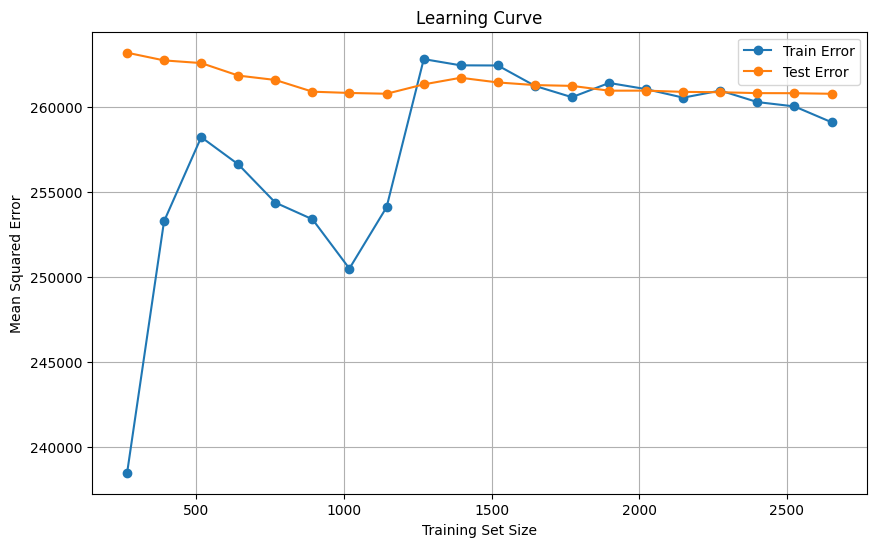

In [ ]:
plot_learning_curve(linearRegression, X_train_subset, y_train)

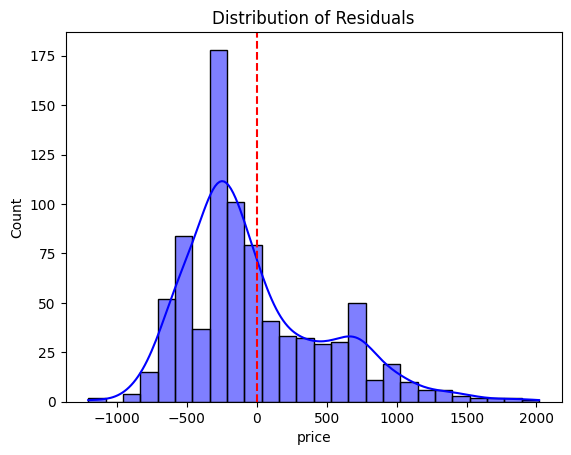

In [ ]:
hist_residual(y_test, y_hat)

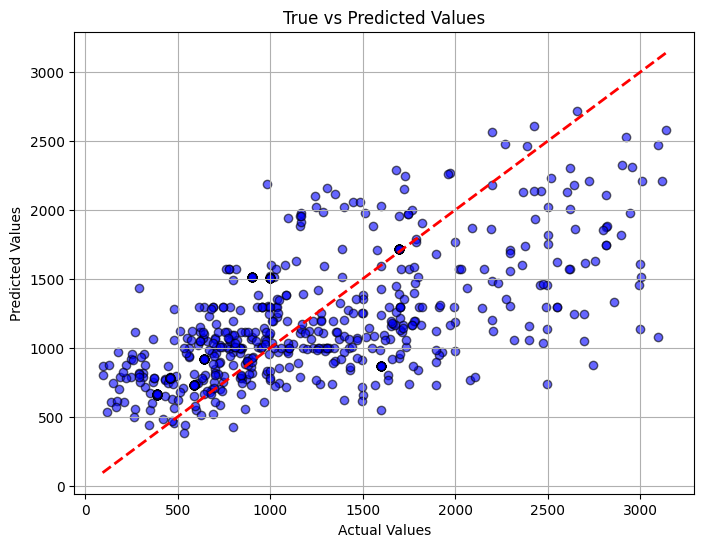

In [ ]:
plot_prediction(y_test, y_hat)

## Ridge

In [ ]:
best_params = {'selected_features': 'brand,color,VGA,screen_size,ram,cpu_speed,rating', 'alpha': 4.277429124583701, 'fit_intercept': True}
X_train_subset, X_test_subset = feature_selection_func(X_train, X_test, best_params['selected_features'].split(','))

In [ ]:
ridge = Ridge(alpha=best_params['alpha'], fit_intercept=best_params['fit_intercept'])
ridge.fit(X_train_subset, y_train)
y_hat = ridge.predict(X_test_subset)
r2_ridge, mae_ridge, mse_ridge = scorer(y_test, y_hat)
print("R2 Score:", r2_ridge)
print("Mean Absolute Error (MAE):", mae_ridge)
print("Mean Squared Error (MSE):", mse_ridge)

R2 Score: 0.41559400268472635
Mean Absolute Error (MAE): 403.30258661037465
Mean Squared Error (MSE): 257238.92222936815


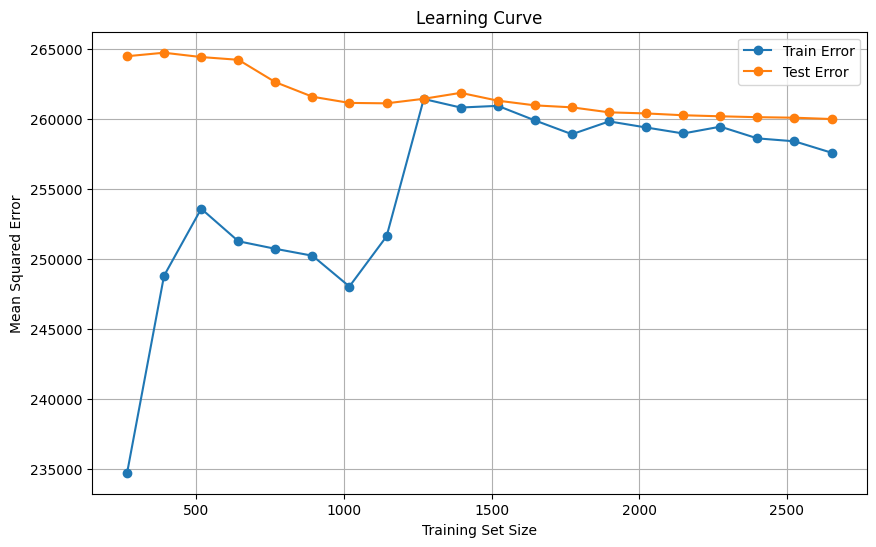

In [ ]:
plot_learning_curve(ridge, X_train_subset, y_train)

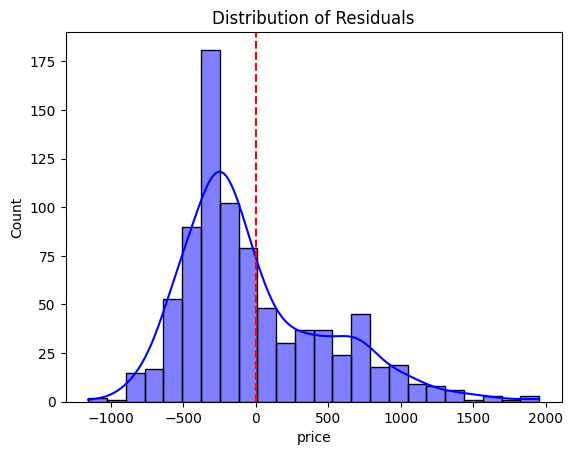

In [ ]:
hist_residual(y_test, y_hat)

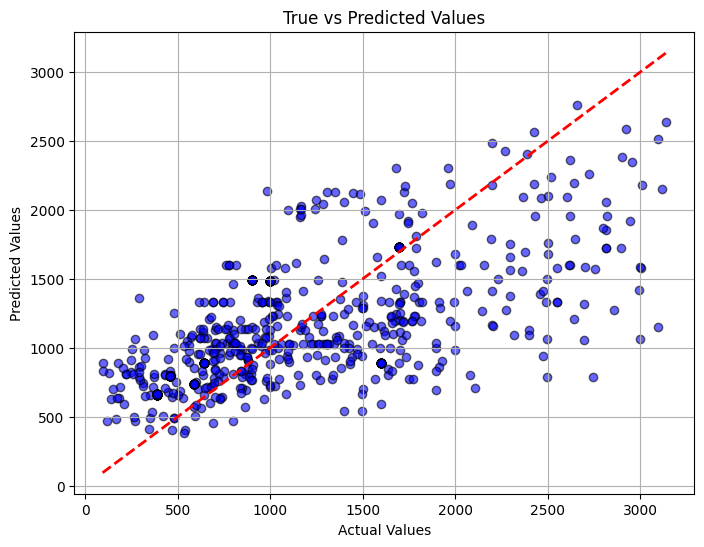

In [ ]:
plot_prediction(y_test, y_hat)

## Polynomial

In [ ]:
best_params = {'selected_features': 'brand,color,OS,screen_size,ram,cpu_speed', 'degree': 3, 'fit_intercept': True}
X_train_subset, X_test_subset = feature_selection_func(X_train, X_test, best_params['selected_features'].split(','))

In [ ]:
degree = best_params['degree']
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train_subset)
X_test_poly = poly.transform(X_test_subset)

fit_intercept = best_params['fit_intercept']
linearRegression = LinearRegression(fit_intercept=fit_intercept)
linearRegression.fit(X_train_poly, y_train)

y_hat = linearRegression.predict(X_test_poly)
r2_poly, mae_poly, mse_poly = scorer(y_test, y_hat)
print("R2 Score:", r2_poly)
print("Mean Absolute Error (MAE):", mae_poly)
print("Mean Squared Error (MSE):", mse_poly)

R2 Score: 0.5445644038644974
Mean Absolute Error (MAE): 313.9638360007328
Mean Squared Error (MSE): 200469.8145347465


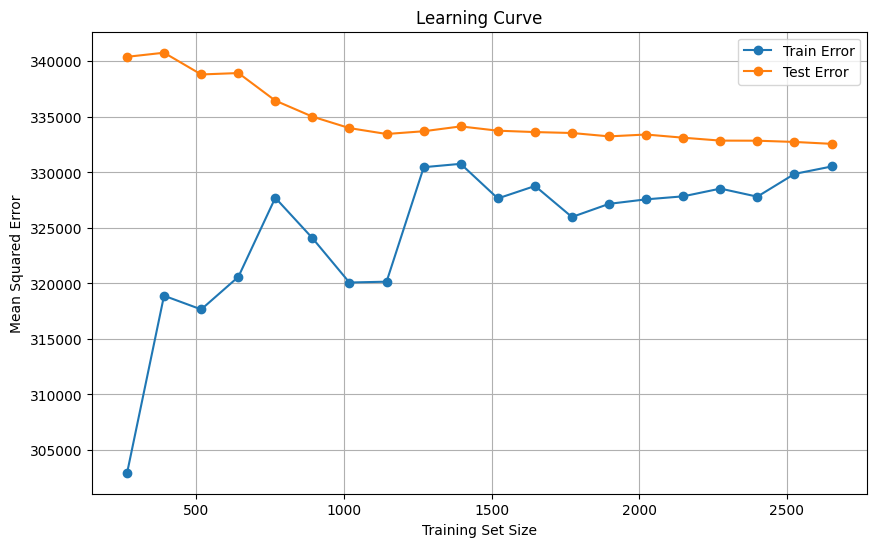

In [ ]:
plot_learning_curve(linearRegression, X_train_poly, y_train)

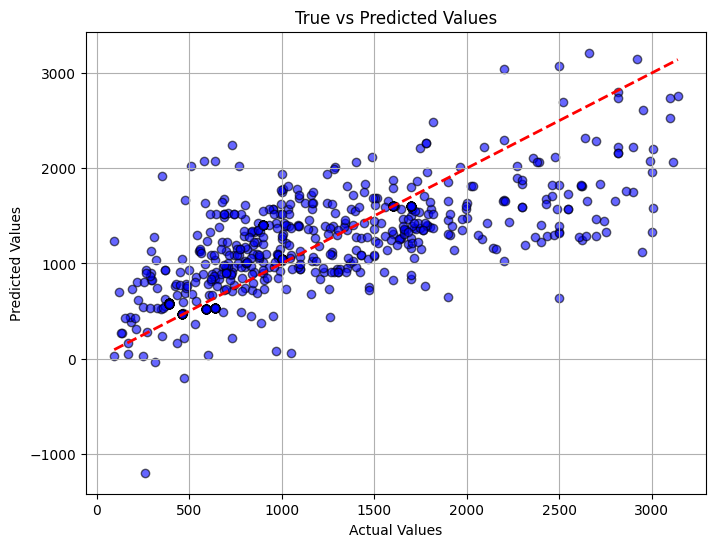

In [ ]:
plot_prediction(y_test, y_hat)

## RandomForest

In [ ]:
best_params = {'selected_features': 'brand,color,OS,VGA,screen_size,ram,cpu_speed', 'n_estimators': 265, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}
X_train_subset, X_test_subset = feature_selection_func(X_train, X_test, best_params['selected_features'].split(','))

In [ ]:
randomForest = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'], max_features=best_params['max_features'])
randomForest.fit(X_train_subset, y_train)
y_hat = randomForest.predict(X_test_subset)
r2_rf, mae_rf, mse_rf = scorer(y_test, y_hat)
print("R2 Score:", r2_rf)
print("Mean Absolute Error (MAE):", mae_rf)
print("Mean Squared Error (MSE):", mse_rf)

R2 Score: 0.7918799320963998
Mean Absolute Error (MAE): 169.49215342028492
Mean Squared Error (MSE): 91608.54304673272


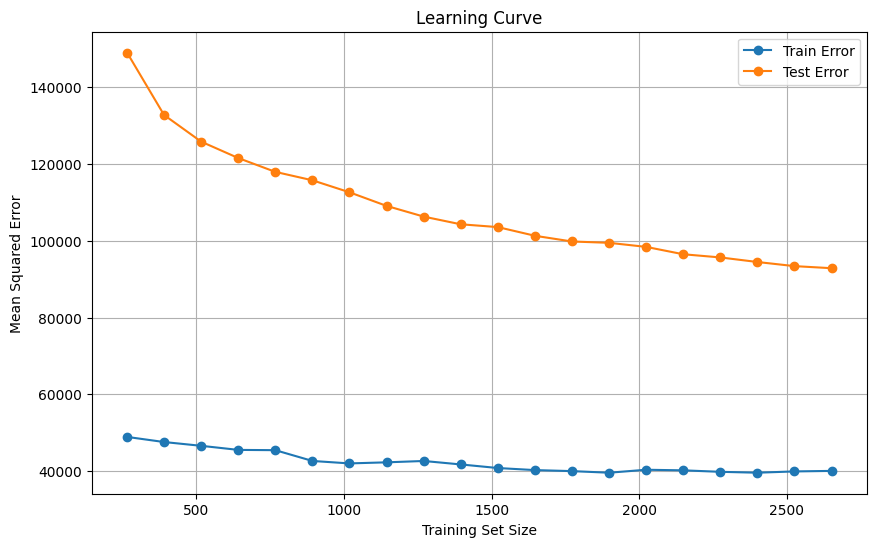

In [ ]:
plot_learning_curve(randomForest, X_train_subset, y_train)

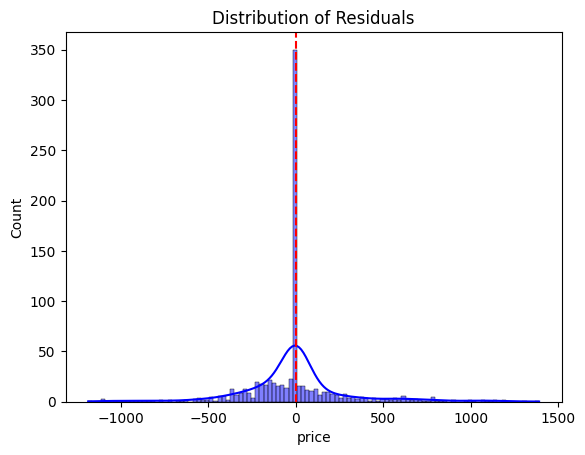

In [ ]:
hist_residual(y_test, y_hat)

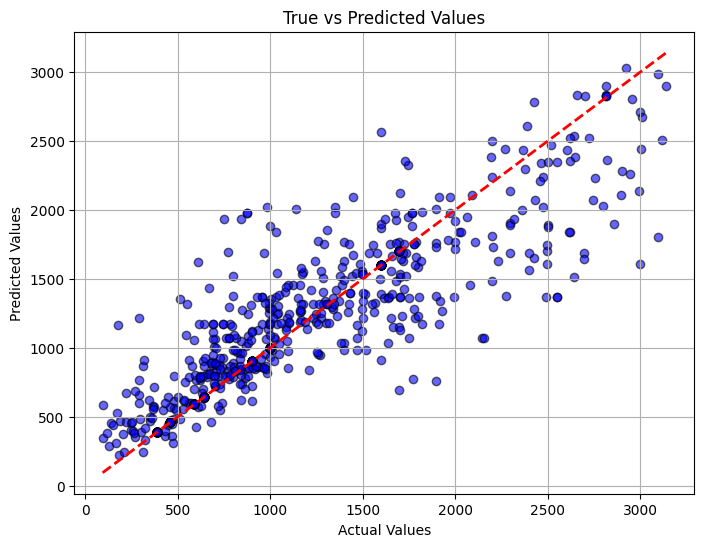

In [ ]:
plot_prediction(y_test, y_hat)

## SVM

In [ ]:
best_params = {'selected_features': 'brand,color,OS,VGA,screen_size,ram,cpu_speed', 'C': 1.6043721616053637, 'kernel': 'linear', 'epsilon': 0.2}
X_train_subset, X_test_subset = feature_selection_func(X_train, X_test, best_params['selected_features'].split(','))

In [ ]:
svm = SVR(C=best_params['C'], kernel=best_params['kernel'], epsilon=best_params['epsilon'])
svm.fit(X_train_subset, y_train)
y_hat = svm.predict(X_test_subset)
r2_svm, mae_svm, mse_svm = scorer(y_test, y_hat)
print("R2 Score:", r2_svm)
print("Mean Absolute Error (MAE):", mae_svm)
print("Mean Squared Error (MSE):", mse_svm)

R2 Score: 0.34310333612367805
Mean Absolute Error (MAE): 375.5381085961922
Mean Squared Error (MSE): 289147.2548329309


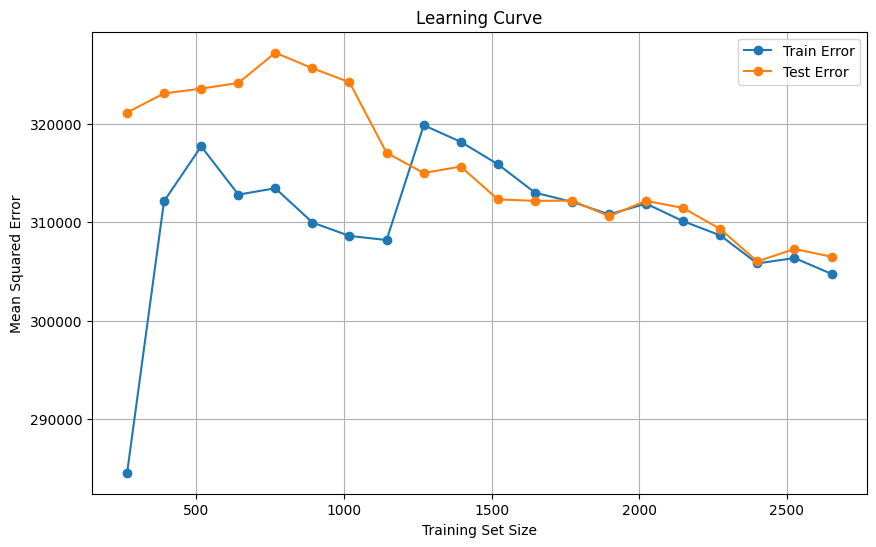

In [ ]:
plot_learning_curve(svm, X_train_subset, y_train)

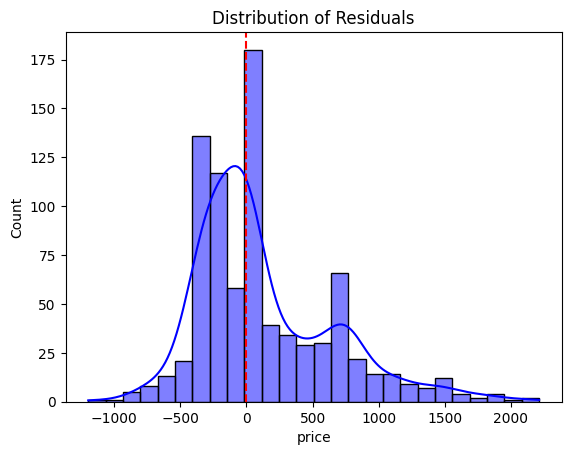

In [ ]:
hist_residual(y_test, y_hat)

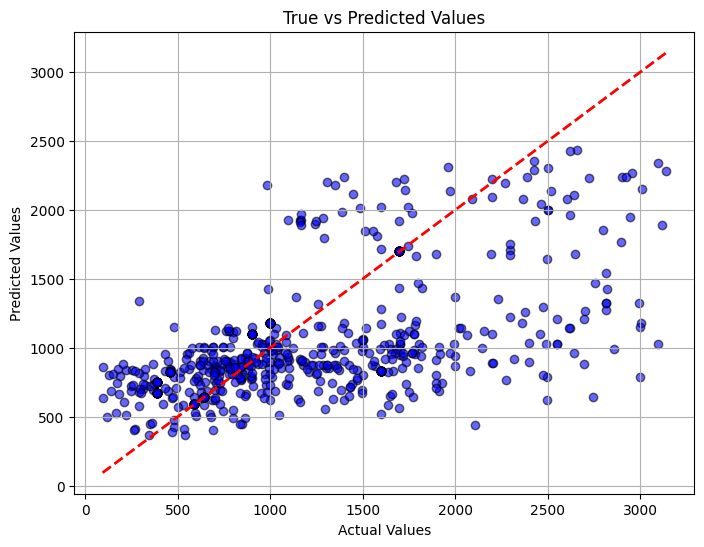

In [ ]:
plot_prediction(y_test, y_hat)

## CatBoost

In [ ]:
best_params = {'selected_features': 'color,OS,VGA,screen_size,ram,cpu_speed,rating', 'iterations': 300, 'depth': 6, 'learning_rate': 0.1933016714978588, 'l2_leaf_reg': 6.2483018883943995, 'random_strength': 1.1488317478293042}
X_train_subset, X_test_subset = feature_selection_func(X_train, X_test, best_params['selected_features'].split(','))

In [ ]:
catBoost = CatBoostRegressor(iterations=best_params['iterations'], depth=best_params['depth'], learning_rate=best_params['learning_rate'], l2_leaf_reg=best_params['l2_leaf_reg'], random_strength=best_params['random_strength'], random_state = 42, verbose = 0)
catBoost.fit(X_train_subset, y_train)
y_hat = catBoost.predict(X_test_subset)
r2_cb, mae_cb, mse_cb = scorer(y_test, y_hat)
print("R2 Score:", r2_cb)
print("Mean Absolute Error (MAE):", mae_cb)
print("Mean Squared Error (MSE):", mse_cb)

R2 Score: 0.7857368133725798
Mean Absolute Error (MAE): 174.46577359432774
Mean Squared Error (MSE): 94312.56943746467


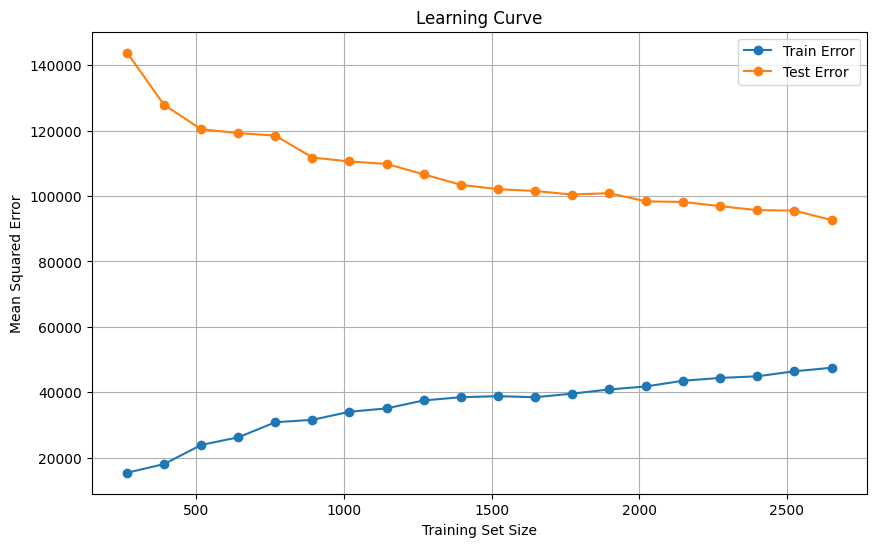

In [ ]:
plot_learning_curve(catBoost, X_train_subset, y_train)

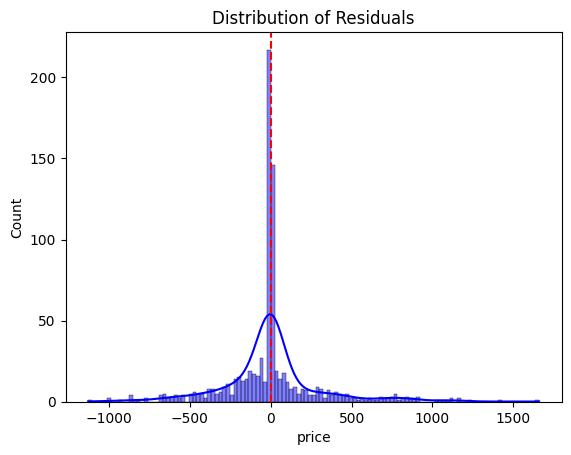

In [ ]:
hist_residual(y_test, y_hat)

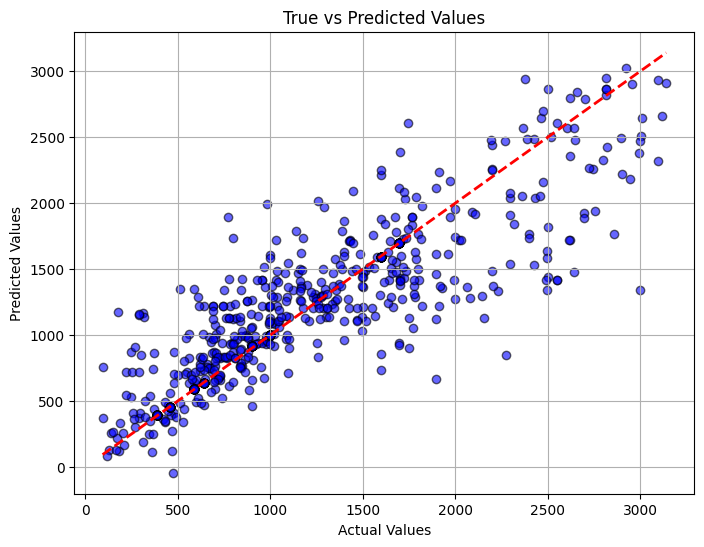

In [ ]:
plot_prediction(y_test, y_hat)

## XGBoost

In [ ]:
best_params = {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 263, 'max_depth': 7, 'learning_rate': 0.06206295558359045, 'subsample': 0.5, 'colsample_bytree': 0.7, 'reg_alpha': 1.530855006191424, 'reg_lambda': 3.297497132423819}
X_train_subset, X_test_subset = feature_selection_func(X_train, X_test, best_params['selected_features'].split(','))

In [ ]:
xgboost = XGBRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], learning_rate=best_params['learning_rate'], subsample=best_params['subsample'], colsample_bytree=best_params['colsample_bytree'], reg_alpha=best_params['reg_alpha'], reg_lambda=best_params['reg_lambda'], random_state=42, use_label_encoder=False, verbosity=0)
xgboost.fit(X_train_subset, y_train)
y_hat = xgboost.predict(X_test_subset)
r2_xgb, mae_xgb, mse_xgb = scorer(y_test, y_hat)
print("R2 Score:", r2_xgb)
print("Mean Absolute Error (MAE):", mae_xgb)

R2 Score: 0.7847757676044004
Mean Absolute Error (MAE): 174.12130268727336


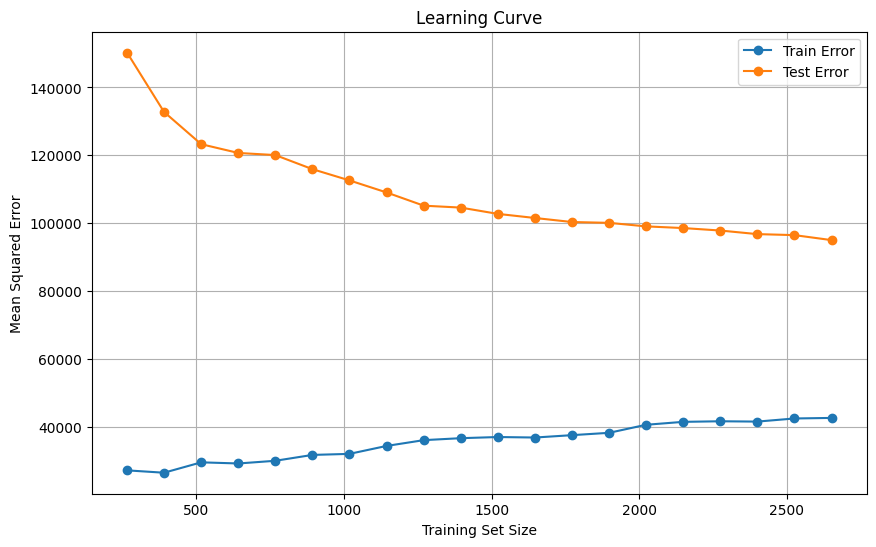

In [ ]:
plot_learning_curve(xgboost, X_train_subset, y_train)

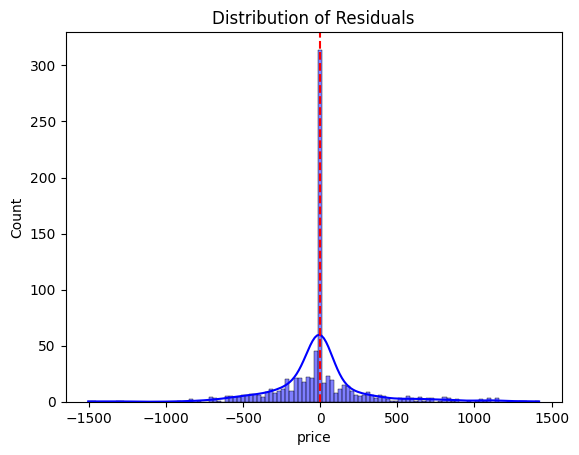

In [ ]:
hist_residual(y_test, y_hat)

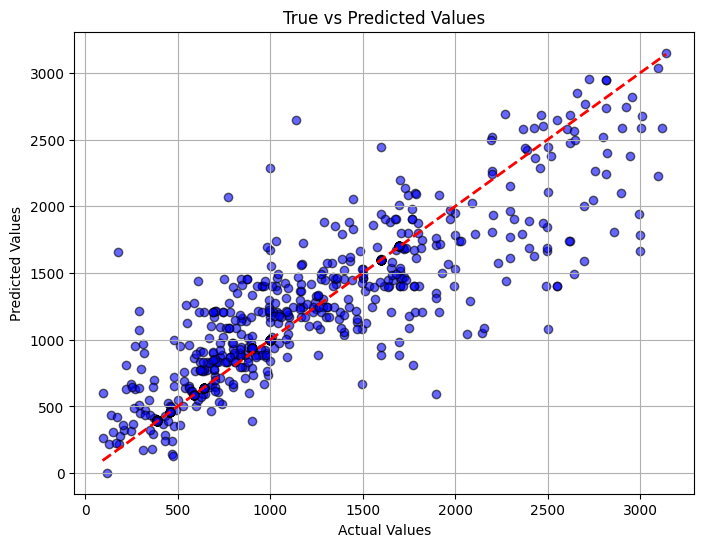

In [ ]:
plot_prediction(y_test, y_hat)

## LightBM

In [ ]:
best_params = {'selected_features': 'color,OS,VGA,screen_size,ram,cpu_speed,rating', 'n_estimators': 176, 'max_depth': 14, 'num_leaves': 21, 'learning_rate': 0.132104502745965, 'subsample': 0.9, 'colsample_bytree': 0.5, 'reg_alpha': 8.99801451444517, 'reg_lambda': 0.5588314804048262}
X_train_subset, X_test_subset = feature_selection_func(X_train, X_test, best_params['selected_features'].split(','))

In [ ]:
lightBM = LGBMRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], num_leaves=best_params['num_leaves'], learning_rate=best_params['learning_rate'], subsample=best_params['subsample'], colsample_bytree=best_params['colsample_bytree'], reg_alpha=best_params['reg_alpha'], reg_lambda=best_params['reg_lambda'])
lightBM.fit(X_train_subset, y_train)
y_hat = lightBM.predict(X_test_subset)
r2_lbm, mae_lbm, mse_lbm = scorer(y_test, y_hat)
print("R2 Score:", r2_lbm)
print("Mean Absolute Error (MAE):", mae_lbm)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 188
[LightGBM] [Info] Number of data points in the train set: 3316, number of used features: 7
[LightGBM] [Info] Start training from score 1135.957914
R2 Score: 0.7791442494337248
Mean Absolute Error (MAE): 176.93316670340656


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 7
[LightGBM] [Info] Start training from score 1170.639126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

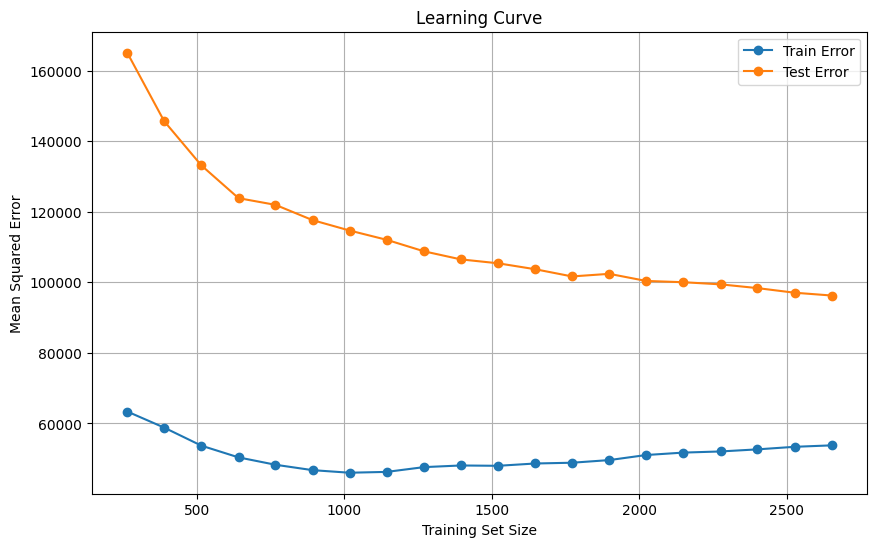

In [ ]:
plot_learning_curve(lightBM, X_train_subset, y_train)

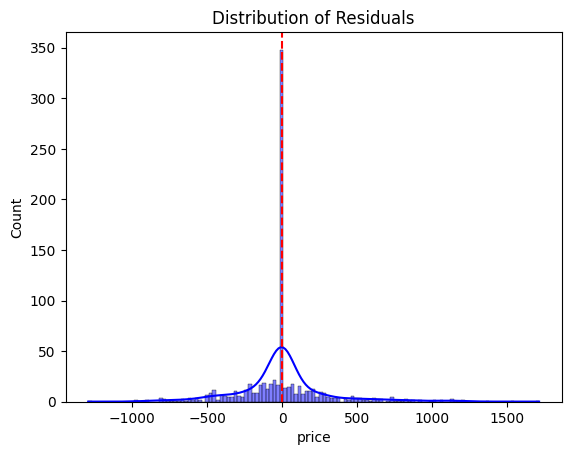

In [ ]:
hist_residual(y_test, y_hat)

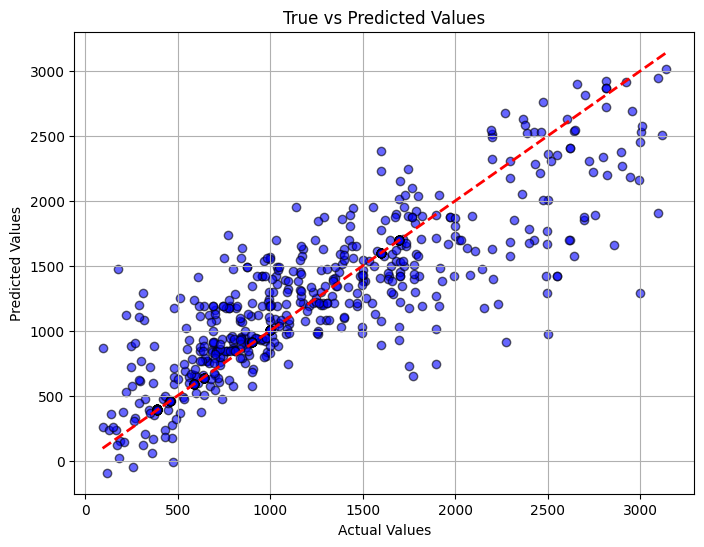

In [ ]:
plot_prediction(y_test, y_hat)

## Feature Importance for every models

Logistic Regression

In [ ]:
best_params = {'selected_features': 'brand,VGA,screen_size,ram,cpu_speed,rating', 'fit_intercept': True}
linearRegression = LinearRegression(fit_intercept=best_params['fit_intercept'])
linearRegression.fit(X_train, y_train)

LinearRegression()

In [ ]:
lg_importance = np.abs(linearRegression.coef_) / np.sum(np.abs(linearRegression.coef_))

Ridge

In [ ]:
best_params = {'selected_features': 'brand,color,VGA,screen_size,ram,cpu_speed,rating', 'alpha': 4.277429124583701, 'fit_intercept': True}
ridge = Ridge(alpha=best_params['alpha'], fit_intercept=best_params['fit_intercept'])
ridge.fit(X_train, y_train)

Ridge(alpha=4.277429124583701)

In [ ]:
ridge_importance = np.abs(ridge.coef_) / np.sum(np.abs(ridge.coef_))

Polynomial

In [ ]:
best_params = {'selected_features': 'brand,color,OS,screen_size,ram,cpu_speed', 'degree': 3, 'fit_intercept': True}
degree = best_params['degree']
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

fit_intercept = best_params['fit_intercept']
poly = LinearRegression(fit_intercept=fit_intercept)
poly.fit(X_train_poly, y_train)

LinearRegression()

Random Forest

In [ ]:
best_params = {'selected_features': 'brand,color,OS,VGA,screen_size,ram,cpu_speed', 'n_estimators': 265, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}
randomForest = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'], max_features=best_params['max_features'])
randomForest.fit(X_train, y_train)

RandomForestRegressor(max_depth=23, max_features='log2', min_samples_split=4,
                      n_estimators=265)

In [ ]:
rf_importance = randomForest.feature_importances_

SVM

In [ ]:
best_params = {'selected_features': 'brand,color,OS,VGA,screen_size,ram,cpu_speed', 'C': 1.6043721616053637, 'kernel': 'linear', 'epsilon': 0.2}
svm = SVR(C=best_params['C'], kernel=best_params['kernel'], epsilon=best_params['epsilon'])
svm.fit(X_train, y_train)

SVR(C=1.6043721616053637, epsilon=0.2, kernel='linear')

In [ ]:
svm_importance = np.abs(svm.coef_[0]) / np.sum(np.abs(svm.coef_[0]))

CatBoost

In [ ]:
best_params = {'selected_features': 'color,OS,VGA,screen_size,ram,cpu_speed,rating', 'iterations': 300, 'depth': 6, 'learning_rate': 0.1933016714978588, 'l2_leaf_reg': 6.2483018883943995, 'random_strength': 1.1488317478293042}
catBoost = CatBoostRegressor(iterations=best_params['iterations'], depth=best_params['depth'], learning_rate=best_params['learning_rate'], l2_leaf_reg=best_params['l2_leaf_reg'], random_strength=best_params['random_strength'], random_state = 42, verbose = 0)
catBoost.fit(X_train, y_train)

In [ ]:
cb_importance = catBoost.feature_importances_ / catBoost.feature_importances_.sum()

XGBoost

In [ ]:
best_params = {'selected_features': 'brand,color,OS,VGA,ram,cpu_speed,rating', 'n_estimators': 263, 'max_depth': 7, 'learning_rate': 0.06206295558359045, 'subsample': 0.5, 'colsample_bytree': 0.7, 'reg_alpha': 1.530855006191424, 'reg_lambda': 3.297497132423819}
xgboost = XGBRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], learning_rate=best_params['learning_rate'], subsample=best_params['subsample'], colsample_bytree=best_params['colsample_bytree'], reg_alpha=best_params['reg_alpha'], reg_lambda=best_params['reg_lambda'], random_state=42, use_label_encoder=False, verbosity=0)
xgboost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06206295558359045,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=263, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
xgb_importance = xgboost.feature_importances_

LightBM

In [ ]:
best_params = {'selected_features': 'color,OS,VGA,screen_size,ram,cpu_speed,rating', 'n_estimators': 176, 'max_depth': 14, 'num_leaves': 21, 'learning_rate': 0.132104502745965, 'subsample': 0.9, 'colsample_bytree': 0.5, 'reg_alpha': 8.99801451444517, 'reg_lambda': 0.5588314804048262}
lightBM = LGBMRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], num_leaves=best_params['num_leaves'], learning_rate=best_params['learning_rate'], subsample=best_params['subsample'], colsample_bytree=best_params['colsample_bytree'], reg_alpha=best_params['reg_alpha'], reg_lambda=best_params['reg_lambda'])
lightBM.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 3316, number of used features: 8
[LightGBM] [Info] Start training from score 1135.957914


LGBMRegressor(colsample_bytree=0.5, learning_rate=0.132104502745965,
              max_depth=14, n_estimators=176, num_leaves=21,
              reg_alpha=8.99801451444517, reg_lambda=0.5588314804048262,
              subsample=0.9)

In [ ]:
lightBM_importance = lightBM.feature_importances_ / lightBM.feature_importances_.sum()
lightBM_importance

array([0.128125  , 0.07130682, 0.08465909, 0.10681818, 0.12642045,
       0.05028409, 0.30795455, 0.12443182])

In [ ]:
features_name = X_train.columns.to_list()

In [ ]:
importance_df = pd.DataFrame({
    'Feature': features_name,
    'Linear Regression': lg_importance,
    'Ridge': ridge_importance,
    'Random Forest': rf_importance,
    'SVM': svm_importance,
    'CatBoost': cb_importance,
    'XGBoost': xgb_importance,
    'LightGBM': lightBM_importance
})

In [ ]:
importance_df

Feature  Linear Regression     Ridge  Random Forest       SVM  \
0        brand           0.013837  0.013890       0.078165  0.025495   
1        color           0.024444  0.024424       0.063681  0.039277   
2           OS           0.022831  0.022592       0.028313  0.007091   
3          VGA           0.020060  0.020097       0.225063  0.036502   
4  screen_size           0.130721  0.130870       0.100316  0.089898   
5          ram           0.281341  0.281465       0.184688  0.155327   
6    cpu_speed           0.273861  0.273786       0.261420  0.318329   
7       rating           0.232906  0.232877       0.058354  0.328081   

   CatBoost   XGBoost  LightGBM  
0  0.057734  0.060719  0.128125  
1  0.109328  0.087349  0.071307  
2  0.036680  0.063610  0.084659  
3  0.155640  0.237022  0.106818  
4  0.077171  0.098380  0.126420  
5  0.211182  0.189040  0.050284  
6  0.280555  0.187085  0.307955  
7  0.071710  0.076794  0.124432

## **Tạo dataframe cho các kết quả các mô hình**

In [ ]:
result = {
    'Linear Regression': [r2_lr, mae_lr, mse_lr],
    'Ridge': [r2_ridge, mae_ridge, mse_ridge],
    'Polynomial': [r2_poly, mae_poly, mse_poly],
    'Random Forest': [r2_rf, mae_rf, mse_rf],
    'SVM': [r2_svm, mae_svm, mse_svm],
    'CatBoost': [r2_cb, mae_cb, mse_cb],
    'XGBoost': [r2_xgb, mae_xgb, mse_xgb],
    'LightGBM': [r2_lbm, mae_lbm, mse_lbm]
}

df_result = pd.DataFrame(result, index=['R2 Score', 'MAE', 'MSE'])

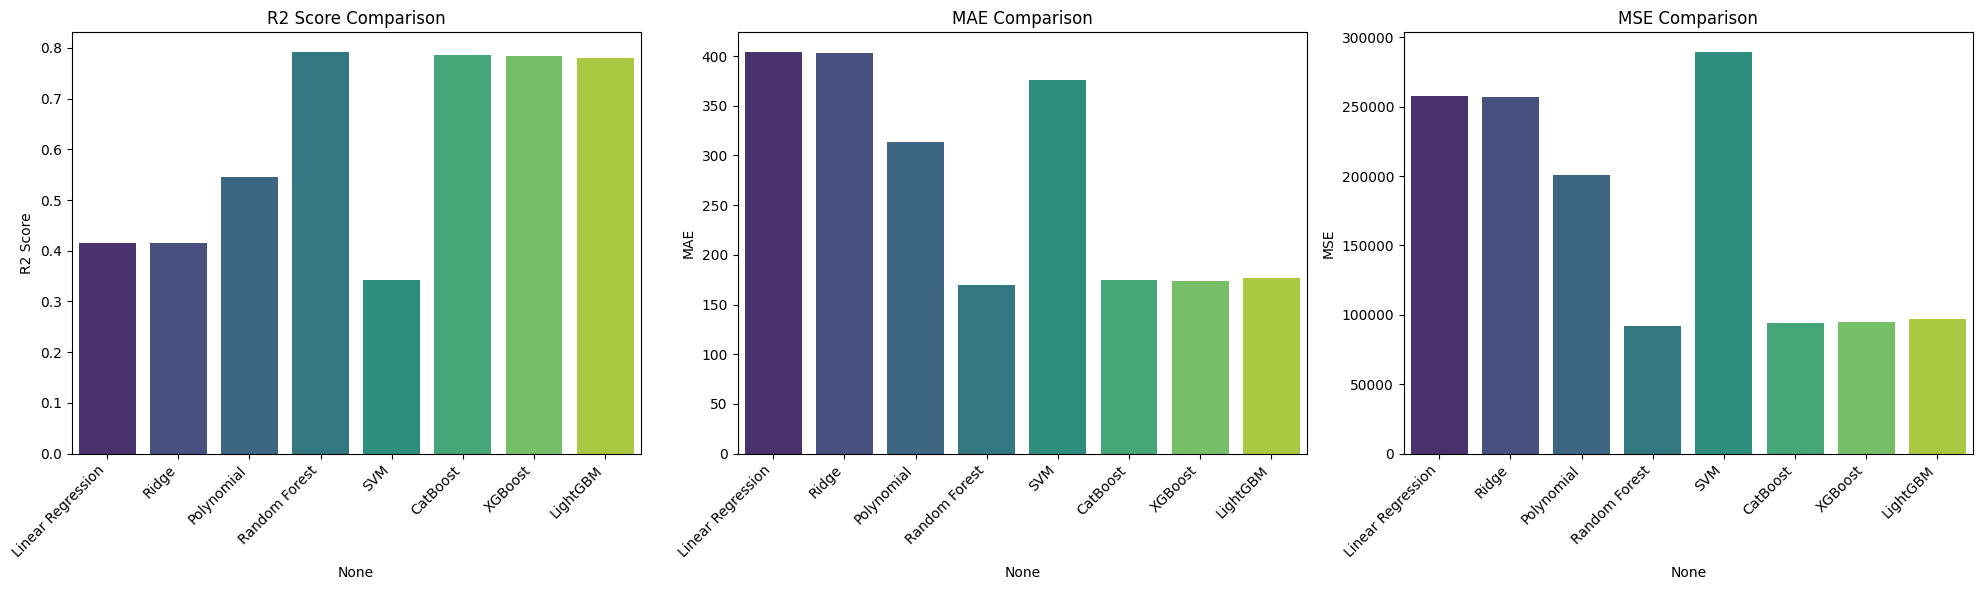

In [ ]:
plt.figure(figsize=(20, 6))

for i, metric in enumerate(df_result.index):
    plt.subplot(1, 3, i + 1)
    sns.barplot(x=df_result.columns, y=df_result.loc[metric], hue=df_result.columns, palette='viridis', legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

**Nhận xét:**

Thông qua huấn luyện và đánh giá với các chỉ số như r2, mae, mse, các mô hình như Linear Regression, Ridge Regression, Polynomial và SVM cho kết quả rất thấp so với các mô hình còn lại. Các mô hình còn lại cho thấy hiệu suất tốt như Random Forest, CatBoost, XGBoost và LightBM  với r2 trung bình là 0.78 và thông qua histogram của residuals thì cho thấy mô hình dự đoán kết quả tốt.

Mô hình Random Forest có kết quả cao nhất và thông qua các biểu đổ chứng minh được hiệu suất tốt nhất trong các mô hình trên.


## Final Evaluation with Random Forest

In [ ]:
best_params = {'selected_features': 'brand,color,OS,VGA,screen_size,ram,cpu_speed', 'n_estimators': 265, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}
X_train_subset, X_test_subset = feature_selection_func(X_train, X_test, best_params['selected_features'].split(','))

Predicted Result

In [ ]:
randomForest = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'], max_features=best_params['max_features'])
randomForest.fit(X_train_subset, y_train)
y_hat = randomForest.predict(X_test_subset)
r2_rf, mae_rf, mse_rf = scorer(y_test, y_hat)
print("R2 Score:", r2_rf)
print("Mean Absolute Error (MAE):", mae_rf)
print("Mean Squared Error (MSE):", mse_rf)

R2 Score: 0.791139566315078
Mean Absolute Error (MAE): 170.07364353936302
Mean Squared Error (MSE): 91934.4310364482


In [ ]:
print("Train R²:", randomForest.score(X_train_subset, y_train))
print("Test R²:", randomForest.score(X_test_subset, y_test))

Train R²: 0.9119838076334028
Test R²: 0.791139566315078


Feature Importance

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': best_params['selected_features'].split(','),
    'Importance': randomForest.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

       Feature  Importance
6    cpu_speed    0.257660
3          VGA    0.226165
5          ram    0.183985
4  screen_size    0.115613
0        brand    0.102079
1        color    0.076878
2           OS    0.037619



Model stability test

In [ ]:
def model_stability_test(model, X_train, y_train, n_splits = 5):
  r2_scores = cross_val_score(model, X_train_subset, y_train, cv = n_splits, scoring = 'r2')
  print("R2 Scores for each fold:", r2_scores)
  print("Mean R2 Score:", np.mean(r2_scores))
  print("Standard Deviation of R2 Scores:", np.std(r2_scores))
  print('========================================================================================')
  mse_scores = cross_val_score(model, X_train_subset, y_train, cv = n_splits, scoring='neg_mean_squared_error')
  mse_scores = -mse_scores
  print("MSE Scores for each fold:", mse_scores)
  print("Mean MSE:", np.mean(mse_scores))
  print("Standard Deviation of MSE:", np.std(mse_scores))

In [ ]:
model_stability_test(randomForest, X_train_subset, y_train)

R2 Scores for each fold: [0.80501281 0.77128136 0.80921232 0.78337629 0.79111133]
Mean R2 Score: 0.7919988225403924
Standard Deviation of R2 Scores: 0.013928513105188433
MSE Scores for each fold: [88870.67151987 95478.49762537 87683.67722784 92429.51970342
 98278.46905326]
Mean MSE: 92548.16702595302
Standard Deviation of MSE: 3965.463658299137


Learning curve visualization

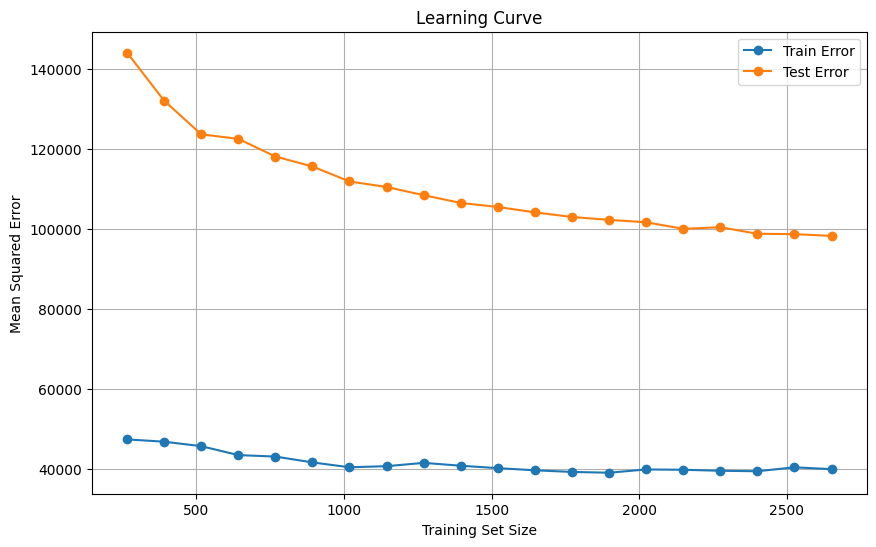

In [ ]:
plot_learning_curve(randomForest, X_train_subset, y_train)

Histograms of residuals

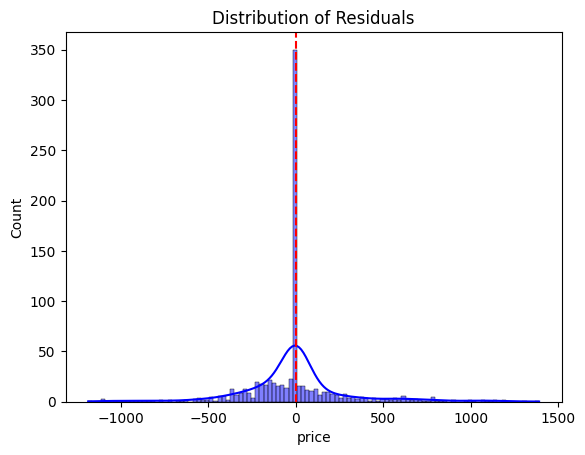

In [ ]:
hist_residual(y_test, y_hat)

Comparison between Predicted Values and Actual Values

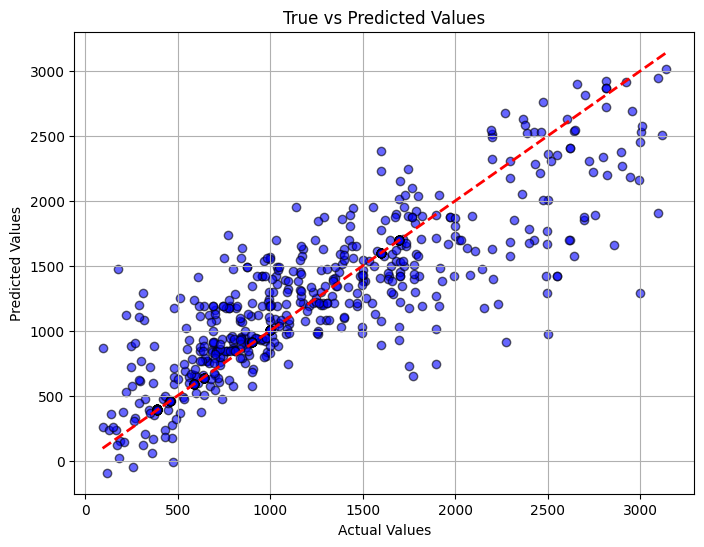

In [ ]:
plot_prediction(y_test, y_hat)

Extract csv file

In [ ]:
from google.colab import files

In [ ]:
file_name = 'preprocessed_data.csv'
refined_df.to_csv(file_name, index=False)
files.download(file_name)

In [ ]:
file_name_2 = 'evaluation_df.csv'
df_result.to_csv(file_name_2, index=False)
files.download(file_name_2)

In [ ]:
file_name = 'importance_df.csv'
importance_df.to_csv(file_name, index=False)
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>